## Objetivo del Análisis
En este notebook, continuaremos con el proceso de segmentación de clientes iniciado en el análisis anterior. Tras haber creado una tabla consolidada con las variables clave y realizar los primeros pasos de clustering, el objetivo de este notebook es analizar y ajustar en profundidad cada una de las variables seleccionadas.

---

## Pasos a Realizar
1. **Análisis Descriptivo de Variables**  
   Exploraremos la distribución y características de cada variable para detectar posibles outliers, sesgos y valores atípicos.

2. **Ajuste y Normalización**  
   Realizaremos los ajustes necesarios para optimizar la calidad de los datos, incluyendo:
   - Imputación de valores nulos
   - Transformación de distribuciones (log, sqrt, etc.)
   - Estandarización o normalización si es necesario

3. **Identificación de Correlaciones**  
   Estudiaremos las correlaciones entre variables para detectar redundancias y posibles insights.

4. **Selección de Variables para Clustering Final**  
   Basándonos en el análisis anterior, determinaremos qué variables son más representativas para el modelo de clustering.

---

## Objetivo Final
Concluido este notebook, dispondremos de un conjunto de variables optimizadas y listas para una nueva iteración del modelo K-Means, donde podremos evaluar mejoras en la segmentación y extraer insights más profundos sobre el comportamiento de los clientes.

##### Creación de Tablas de Clientes Activos e Inactivos

## Objetivo
El objetivo de esta parte del proceso es segmentar los clientes en dos grupos diferenciados:
1. **Clientes Activos**: Aquellos que han tenido al menos una sesión registrada.
2. **Clientes Inactivos**: Aquellos que no han tenido sesiones en absoluto.

Esta separación permite enfocar los esfuerzos de segmentación exclusivamente en los clientes activos, mientras que los inactivos pueden ser gestionados en un clúster independiente o con estrategias distintas.

---

## Proceso Realizado
1. **Conexión a PostgreSQL**  
   Se establece una conexión a la base de datos mediante SQLAlchemy para realizar operaciones SQL de forma eficiente.

2. **Creación de Tablas**  
   A partir de la tabla original `customer_segmentation_features`:
   - Se filtran los clientes con sesiones (`num_sessions > 0`) y se almacenan en `clientes_activos`.
   - Los clientes sin sesiones (`num_sessions = 0`) se almacenan en `clientes_inactivos`.

3. **Índices para Optimización**  
   Se crean índices en las columnas `customer_id` de ambas tablas para acelerar las búsquedas.

4. **Validación**  
   Finalmente, se muestra el número de registros creados en cada tabla para asegurar la correcta separación.

---

## Resultados
Se han creado dos nuevas tablas:
- `clientes_activos`: Contiene **50.704** clientes.
- `clientes_inactivos`: Contiene **49.296** clientes.

---

## Próximos Pasos
Continuaremos el análisis y segmentación únicamente sobre la tabla `clientes_activos`, ya que los inactivos se considerarán un clúster aparte para análisis futuros.


In [1]:
import pandas as pd
from sqlalchemy import create_engine,text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuración de conexión
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexión a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [3]:
%%time
# SQL para crear la tabla de clientes activos
create_clientes_activos = """
    DROP TABLE IF EXISTS customer_segmentation_actives;    

    CREATE TABLE customer_segmentation_actives AS (
        SELECT * 
        FROM customer_segmentation_features
        WHERE num_sessions > 0
    );
"""

create_clientes_inactivos = """
    DROP TABLE IF EXISTS customer_segmentation_inactives; 
    CREATE TABLE customer_segmentation_inactives AS (
        SELECT * 
        FROM customer_segmentation_features
        WHERE num_sessions = 0
    );
"""

# Ejecutar las queries
# Ejecutar las queries en PostgreSQL
with engine.connect() as connection:
    print("Creando tabla 'customer_segmentation_actives'...")
    connection.execute(text(create_clientes_activos))
    print("✅ Tabla 'customer_segmentation_actives' creada correctamente.")
    
    print("Creando tabla 'customer_segmentation_inactives'...")
    connection.execute(text(create_clientes_inactivos))
    print("✅ Tabla 'customer_segmentation_inactives' creada correctamente.")
    
    connection.commit()

Creando tabla 'customer_segmentation_actives'...
✅ Tabla 'customer_segmentation_actives' creada correctamente.
Creando tabla 'customer_segmentation_inactives'...
✅ Tabla 'customer_segmentation_inactives' creada correctamente.
CPU times: total: 15.6 ms
Wall time: 360 ms


## Análisis Exploratorio de Variables Numéricas

En esta sección se realiza un análisis exploratorio de las variables numéricas agregadas por cliente, que formarán parte del proceso de segmentación mediante clustering.

El objetivo principal es:

- Comprender la distribución y escala de cada variable.
- Detectar posibles valores atípicos (outliers).
- Identificar la necesidad de normalización o transformación antes de aplicar algoritmos de agrupamiento como K-Means.

### Variables Analizadas

A continuación se detallan las variables numéricas incluidas en el análisis:

- `total_amount_sum`: Importe total gastado por el cliente.
- `product_quantity_sum`: Número total de unidades adquiridas.
- `num_purchases`: Total de compras realizadas.
- `avg_order_value`: Valor medio por compra.
- `recency_days`: Días desde la última compra hasta la fecha de referencia.
- `first_purchase_days`: Antigüedad del cliente desde su primera compra.
- `average_time_transaction`: Tiempo promedio en sesiones con compra.
- `num_sessions`: Número total de sesiones registradas.
- `num_events`: Número total de eventos generados.
- `distinct_product_views`: Cantidad de productos distintos visualizados.
- `num_searches`: Número de búsquedas realizadas.
- `promo_usage_rate`: Proporción de compras en las que se aplicó una promoción.
- `avg_promo_discount`: Descuento medio aplicado en compras con promoción.
- `age`: Edad del cliente

Estas variables proporcionan una visión integral del comportamiento y valor de cada cliente, y son fundamentales para construir segmentos coherentes y accionables.


## Análisis de Correlación antes de Normalización

### **¿Por qué es conveniente analizar la correlación antes de normalizar?**

Realizar un análisis de correlación previo a la normalización de las variables numéricas es una práctica recomendada en el proceso de preprocesamiento de datos. Las razones clave son las siguientes:

---

### **Detección de Multicolinealidad**
Cuando dos o más variables están fuertemente correlacionadas, esto indica redundancia en la información. En algoritmos de clustering como **K-Means** o modelos predictivos, esta redundancia puede afectar negativamente los resultados, haciendo que ciertos atributos influyan de manera desproporcionada.

**Ejemplo:**  
Si `total_amount_sum` y `num_purchases` están fuertemente correlacionados, podría indicar que ambas están midiendo el comportamiento de compra del cliente de forma similar.

---

### **Selección de Variables Relevantes**
Un análisis de correlación permite identificar variables que no tienen relación significativa con el resto. Si una variable tiene muy poca o ninguna correlación con las demás, podría considerarse su eliminación del modelo sin pérdida de información relevante.

**Ejemplo:**  
Si `average_time_transaction` no está correlacionada con otras variables de comportamiento, su aporte al modelo podría ser mínimo.

---

### **Optimización del Preprocesamiento**
Conocer la estructura de correlación antes de normalizar ayuda a identificar transformaciones necesarias para mejorar la distribución de los datos. En casos de alta dispersión, se podrían aplicar transformaciones logarítmicas, raíz cuadrada, o estandarización avanzada.

**Ejemplo:**  
Si `recency_days` muestra una alta desviación con respecto al resto, podríamos considerar una transformación para reducir su efecto sobre el modelo.

---

### **Conclusión**
Analizar la correlación antes de normalizar permite tomar decisiones más informadas sobre la selección y transformación de variables, optimizando así los resultados del clustering y los modelos predictivos.

---


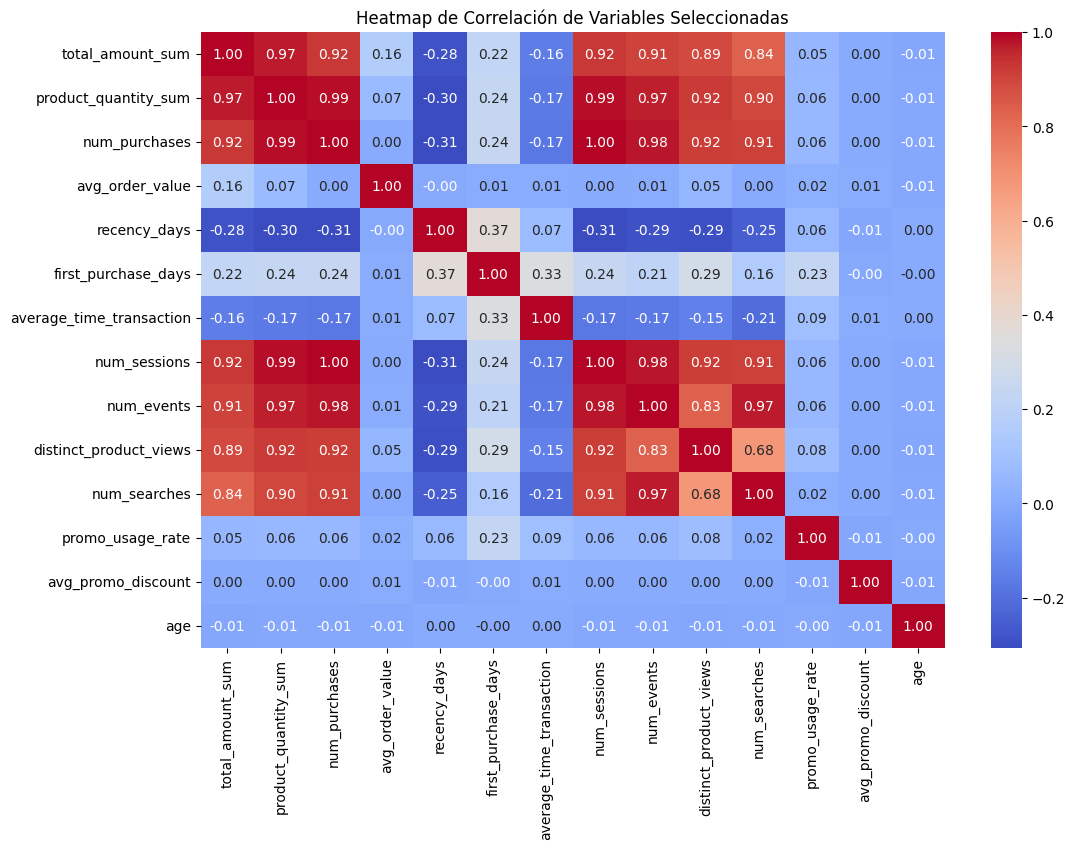

CPU times: total: 609 ms
Wall time: 640 ms


In [4]:
%%time
# Definir las variables del análisis
variables = [
    'total_amount_sum', 'product_quantity_sum', 'num_purchases', 
    'avg_order_value', 'recency_days', 'first_purchase_days',
    'average_time_transaction', 'num_sessions', 'num_events',
    'distinct_product_views', 'num_searches', 'promo_usage_rate',
    'avg_promo_discount', 'age'
]

# Cargar datos
query = f"""
SELECT {', '.join(variables)}
FROM customer_segmentation_actives
"""
df = pd.read_sql_query(query, engine)

# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Visualización del heatmap de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlación de Variables Seleccionadas')
plt.show()

## Análisis de Correlación de Variables Numéricas

### **Objetivo del Análisis**
El propósito del análisis de correlación es identificar relaciones lineales entre las variables numéricas seleccionadas del dataset `clientes_activos`. Esto permite detectar multicolinealidad, eliminar redundancias y optimizar el preprocesamiento antes de aplicar algoritmos de clustering.

---

### **Interpretación del Heatmap**
El heatmap de correlación permite visualizar de manera clara las relaciones entre variables:
- **Color rojo intenso:** Correlación positiva fuerte.
- **Color azul intenso:** Correlación negativa fuerte.
- **Color neutro:** Ausencia de correlación significativa.

---

### **Correlaciones Más Destacadas**
A continuación se destacan las correlaciones más relevantes observadas en el heatmap:

| Variables                    | Correlación | Observación                        |
|------------------------------|-------------|-----------------------------------|
| `product_quantity_sum ` ↔ `num_purchases`    | **0.99**     | Relación prácticamente lineal: más sesiones implican más productos comprados. |
| `num_sessions` ↔ `num_purchases` | **1.00**     | Sesiones y número de compras contienen la misma información. |
| `product_quantity_sum ` ↔ `num_purchases`      | **0.99**     | 	El número de productos adquiridos se relaciona estrechamente con las compras. |
| `num_events` ↔ `num_purchases`         | **0.99**     | 	Mayor número de compras implica mayor actividad. |
| `num_events` ↔ `num_sessions`            | **0.98**     | La actividad del cliente está muy ligada al número de sesiones. |
| `distinct_product_views` ↔ `num_sessions`| **0.97**     | 	Los clientes más activos visualizan más productos distintos. |

---

### **Posible Multicolinealidad y Redundancia**
Las correlaciones muy cercanas a 1.00 entre ciertas variables indican redundancia, es decir, estas variables están capturando prácticamente la misma información. Para optimizar el modelo, **se propone eliminar las siguientes variables**:

| Variable Eliminada          | Justificación                                                                         |
|------------------------------|---------------------------------------------------------------------------------------|
| `num_purchases`             | Está altamente correlacionada con `total_amount_sum` y `num_sessions`, siendo redundante. |
| `product_quantity_sum`      | Su relación con `num_purchases` es casi perfecta, capturando la misma información.        |
| `num_events`                | Correlaciona en un 0.98 con `num_sessions`, duplicando el registro de actividad del usuario. |
| `num_searches`              | Correlación del 0.97 con `distinct_product_views`, midiendo esencialmente la misma interacción. |

---

### **Próximos Pasos**
1. Eliminar las variables redundantes indicadas en la tabla.
2. Evaluar si las variables restantes necesitan transformación o normalización antes del clustering.
3. Proceder con un análisis exploratorio más profundo para detectar posibles outliers y optimizar las escalas.

---

**Variables Finales para el Modelo**:
- `total_amount_sum`
- `avg_order_value`
- `recency_days`
- `first_purchase_days`
- `average_time_transaction`
- `num_sessions`
- `distinct_product_views`
- `promo_usage_rate`
- `avg_promo_discount`
- `age`

---


✅ Tabla 'customer_segmentation_optimized' creada correctamente.

Muestra de Datos Optimizada:


customer_id  total_amount_sum  avg_order_value  recency_days  \
0          654          177176.0         177176.0          1193   
1         6573          183631.0         183631.0          1082   
2        38802          316600.0         316600.0          3166   
3        84282        12684858.0        6342429.0          1153   
4        57707          510997.0         510997.0          1516   

   first_purchase_days  average_time_transaction  num_sessions  \
0                 1195                 18.883594             1   
1                 1083                 31.010945             1   
2                 3169                 40.116373             1   
3                 1257              22880.298261             2   
4                 1517                 38.663068             1   

   distinct_product_views  promo_usage_rate  avg_promo_discount  age  
0                       2               0.0                 0.0   21  
1                       1               0.0                 0.0   27  
2                       3               1.0              5824.0   26  
3                       8               0.0                 0.0   31  
4                       1               0.0                 0.0   32

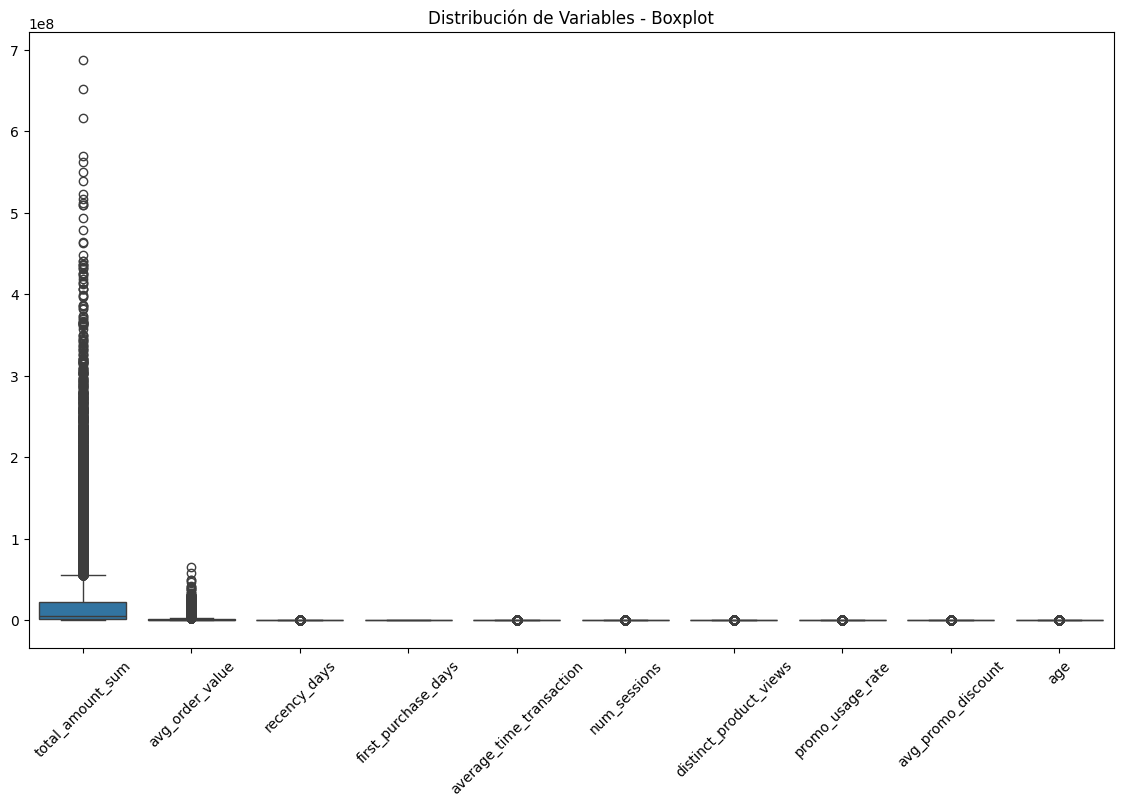

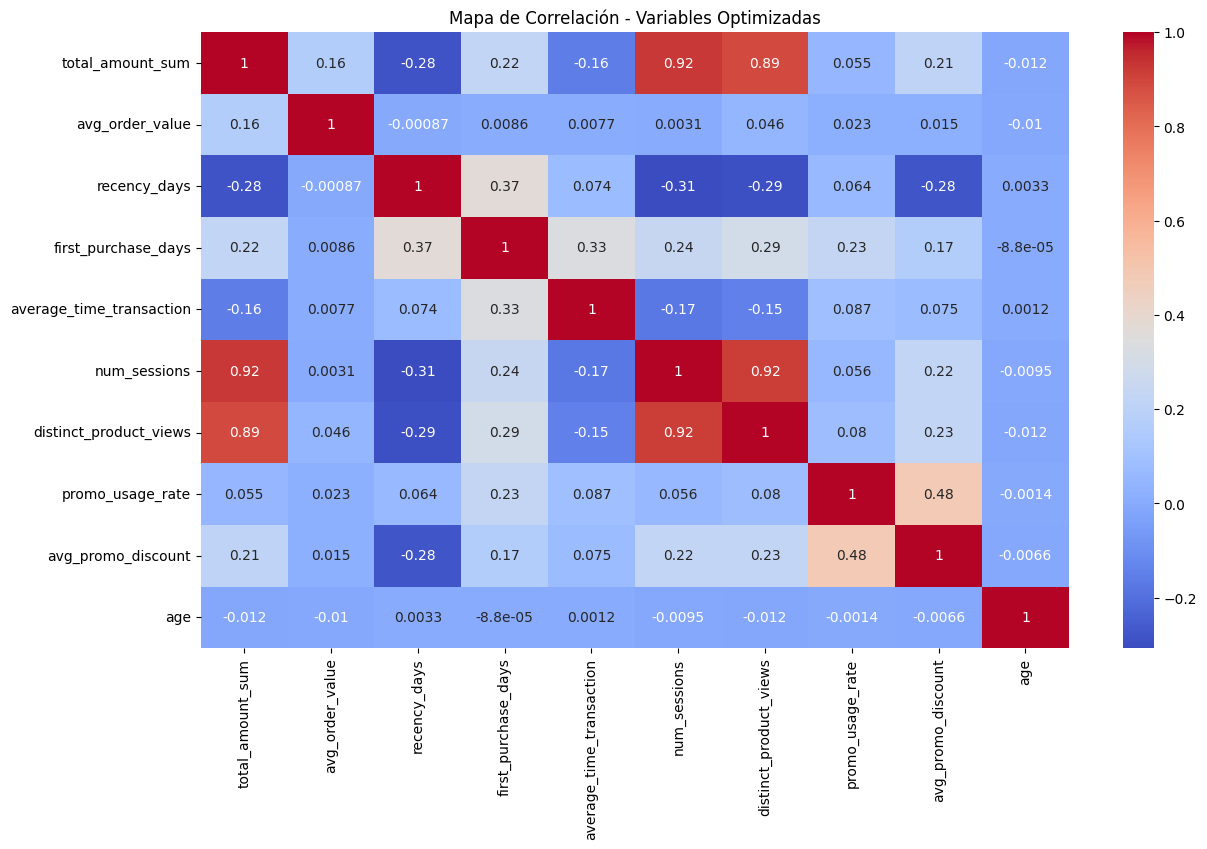

CPU times: total: 1.67 s
Wall time: 1.79 s


In [5]:
%%time
# ==============================
#    CREACIÓN DE TABLA OPTIMIZADA
# ==============================
create_table_query = """
DROP INDEX IF EXISTS idx_customer_segmentation_optimized_id;
DROP TABLE IF EXISTS customer_segmentation_optimized;

CREATE TABLE customer_segmentation_optimized AS (
    SELECT 
        customer_id,
        total_amount_sum,
        avg_order_value,
        recency_days,
        first_purchase_days,
        average_time_transaction,
        num_sessions,
        distinct_product_views,
        promo_usage_rate,
        avg_promo_discount,
        age
    FROM customer_segmentation_actives
);

CREATE INDEX idx_customer_segmentation_optimized_id ON customer_segmentation_optimized (customer_id);
"""

# Ejecutar la creación
with engine.connect() as connection:
    connection.execute(text(create_table_query))
    connection.commit()  # Forzar el commit
print("✅ Tabla 'customer_segmentation_optimized' creada correctamente.")

# ==============================
#    VALIDACIÓN DE LOS DATOS
# ==============================
query = """
SELECT * FROM customer_segmentation_optimized;
"""
df = pd.read_sql_query(query, engine)
df['avg_promo_discount'] = df['avg_promo_discount'].fillna(0)
print("\nMuestra de Datos Optimizada:")
display(df.head())



# ==============================
#    ANÁLISIS EXPLORATORIO
# ==============================
plt.figure(figsize=(14, 8))
sns.boxplot(data=df.drop(columns=['customer_id']))
plt.title('Distribución de Variables - Boxplot')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df.drop(columns=['customer_id']).corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlación - Variables Optimizadas')
plt.show()


## Análisis Exploratorio y Conclusiones

---

### **Análisis de Distribución (Boxplot)**
El análisis de distribución mediante un **Boxplot** ha revelado que:
- La variable `total_amount_sum` presenta un valor extremadamente elevado (outlier) en comparación con el resto de los clientes.
- Las demás variables tienen escalas significativamente menores, lo cual indica la necesidad de una estandarización antes de aplicar modelos de clustering.
- Este outlier podría distorsionar el comportamiento del clustering, especialmente en algoritmos sensibles como **K-Means**.

---

### **Análisis de Correlación (Heatmap)**
El mapa de correlación revela relaciones moderadas y algunas altas, lo cual sugiere **redundancia de información**. Las más destacadas son:

| Variables                    | Correlación | Justificación para Eliminación |
|------------------------------|-------------|--------------------------------|
| `total_amount_sum` ↔ `num_sessions` | **0.92** | Ambas capturan el volumen de interacción del cliente con la plataforma. |
| `total_amount_sum` ↔ `distinct_product_views`           | **0.89** | También muy correlacionadas, sugieren redundancia. |
| `distinct_product_views` ↔ `num_sessions`     | **0.92** | La cantidad de productos distintos visualizados es prácticamente lineal al número de sesiones. |

---

### **Decisión Final de Eliminación**
Para evitar redundancia y reducir la multicolinealidad, se propone eliminar las siguientes variables del análisis de clustering:
1. `distinct_product_views` → Altamente correlacionada con `num_sessions`.
2. `num_sessions` → Su relación con `total_amount_sum` y `distinct_product_views` no aporta nueva información única.

---

### **Próximos Pasos**
1. Procederemos a eliminar estas variables del dataset optimizado:  
   - Se actualizará la tabla `customer_segmentation_optimized`.
   
2. Aplicaremos técnicas de detección y tratamiento de **outliers**:
   - Winsorization.
   - Transformación logarítmica si es necesario.

3. Normalización y estandarización del conjunto final:
   - Preparación para el modelo de clustering.

---


✅ Tabla 'customer_segmentation_optimized_v2' creada correctamente.

Muestra de Datos Optimizada:


customer_id  total_amount_sum  avg_order_value  recency_days  \
0          654          177176.0         177176.0          1193   
1         6573          183631.0         183631.0          1082   
2        38802          316600.0         316600.0          3166   
3        84282        12684858.0        6342429.0          1153   
4        57707          510997.0         510997.0          1516   

   first_purchase_days  average_time_transaction  promo_usage_rate  \
0                 1195                 18.883594               0.0   
1                 1083                 31.010945               0.0   
2                 3169                 40.116373               1.0   
3                 1257              22880.298261               0.0   
4                 1517                 38.663068               0.0   

   avg_promo_discount  age  
0                 NaN   21  
1                 NaN   27  
2              5824.0   26  
3                 NaN   31  
4                 NaN   32

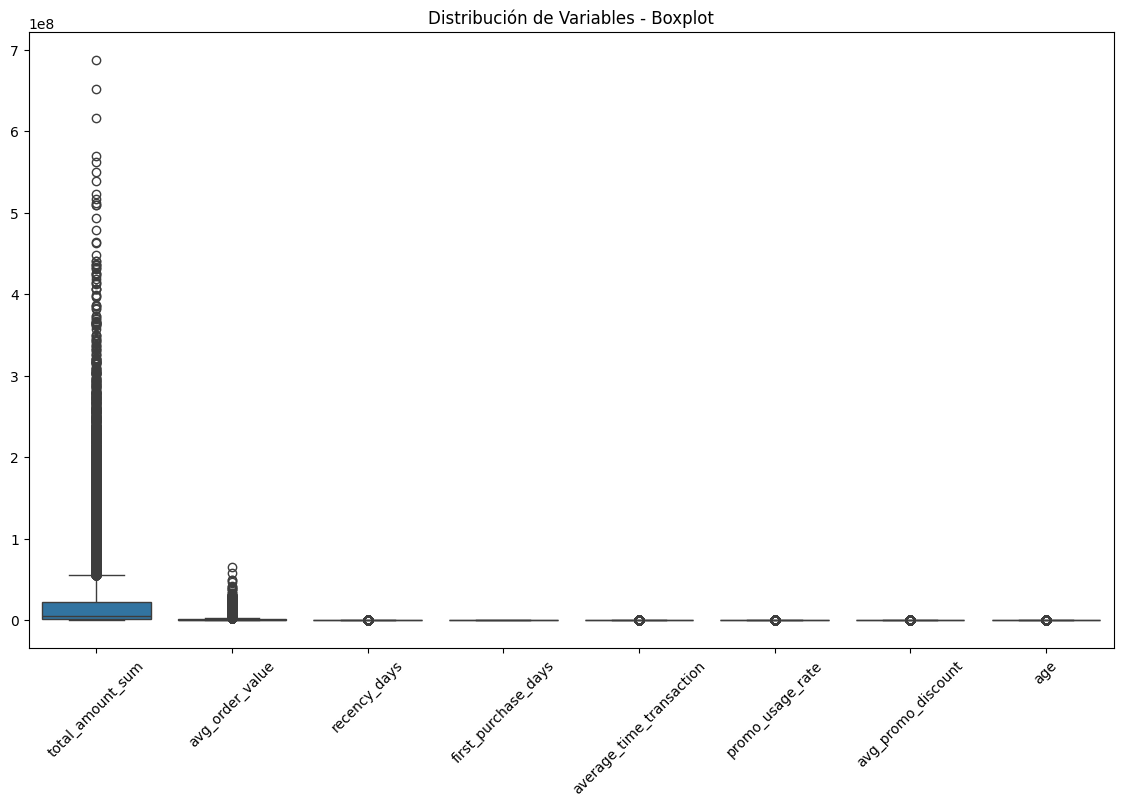

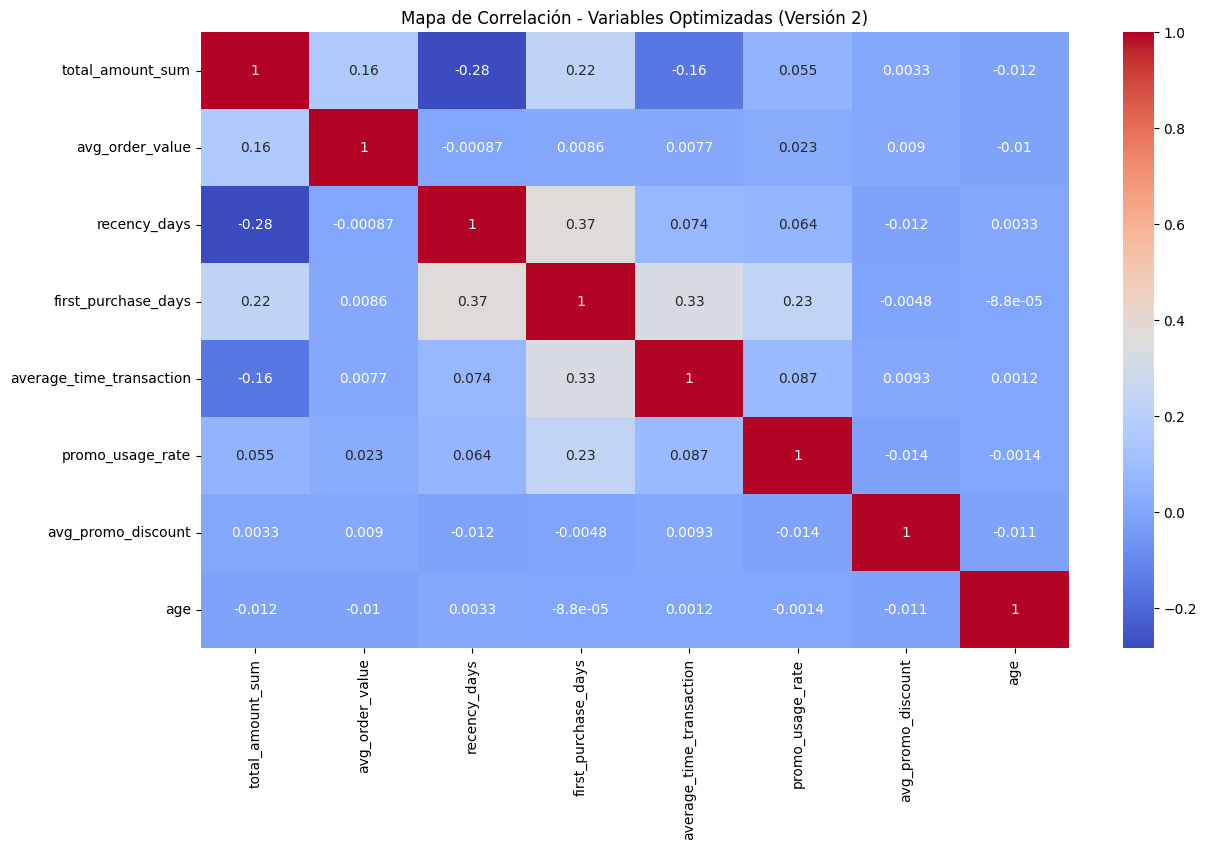

In [6]:
# ==============================
#    CREACIÓN DE TABLA OPTIMIZADA
# ==============================
create_table_query = """
DROP INDEX IF EXISTS idx_customer_segmentation_optimized_v2_id;
DROP TABLE IF EXISTS customer_segmentation_optimized_v2;

CREATE TABLE customer_segmentation_optimized_v2 AS (
    SELECT 
        customer_id,
        total_amount_sum,
        avg_order_value,
        recency_days,
        first_purchase_days,
        average_time_transaction,
        promo_usage_rate,
        avg_promo_discount,
        age
    FROM customer_segmentation_optimized
);

CREATE INDEX idx_customer_segmentation_optimized_v2_id ON customer_segmentation_optimized_v2 (customer_id);
"""

# Ejecutar la creación
try:
    with engine.connect() as connection:
        connection.execute(text(create_table_query))
        connection.commit()
        print("✅ Tabla 'customer_segmentation_optimized_v2' creada correctamente.")
except Exception as e:
    print("❌ Error en la creación de la tabla:", e)

# ==============================
#    VALIDACIÓN DE LOS DATOS
# ==============================
query = """
SELECT * FROM customer_segmentation_optimized_v2;
"""
df = pd.read_sql_query(query, engine)
print("\nMuestra de Datos Optimizada:")
display(df.head())

# ==============================
#    ANÁLISIS EXPLORATORIO
# ==============================
plt.figure(figsize=(14, 8))
sns.boxplot(data=df.drop(columns=['customer_id']))
plt.title('Distribución de Variables - Boxplot')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df.drop(columns=['customer_id']).corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlación - Variables Optimizadas (Versión 2)')
plt.show()

## Análisis Exploratorio Concluido - Preparación para el Tratamiento de Outliers  

---

### **Decisión Final sobre las Variables Seleccionadas**  
Después del análisis de correlación y distribución, se ha realizado una optimización del conjunto de variables.  
Las variables seleccionadas para la fase de clustering son las siguientes:

- `total_amount_sum`
- `avg_order_value`
- `recency_days`
- `first_purchase_days`
- `average_time_transaction`
- `promo_usage_rate`
- `avg_promo_discount`
- `age`

---

### **Tratamiento de Outliers**  
En el análisis previo, se detectaron varios valores atípicos en algunas variables, en especial:
- `total_amount_sum`: Un cliente presenta un gasto total extremadamente elevado.
- `avg_order_value`: Algunos valores están fuera de un rango considerado normal.
- `average_time_transaction`: Tiempo de transacción en algunas ocasiones es excesivamente alto.

---

### **Próximos Pasos: Tratamiento de Outliers**  
Para preparar el conjunto de datos para el clustering, se procederá a:
1. Aplicar un método de **Winsorization** para reducir el impacto de los valores extremos sin eliminarlos.
2. Alternativamente, se explorará el uso del método **IQR (Interquartile Range)** para recortar outliers.
3. Visualización posterior del boxplot para validar la reducción de outliers.

---

**Objetivo:** Optimizar el conjunto de datos, reducir el sesgo provocado por valores extremos y preparar las variables para el proceso de normalización.  

---


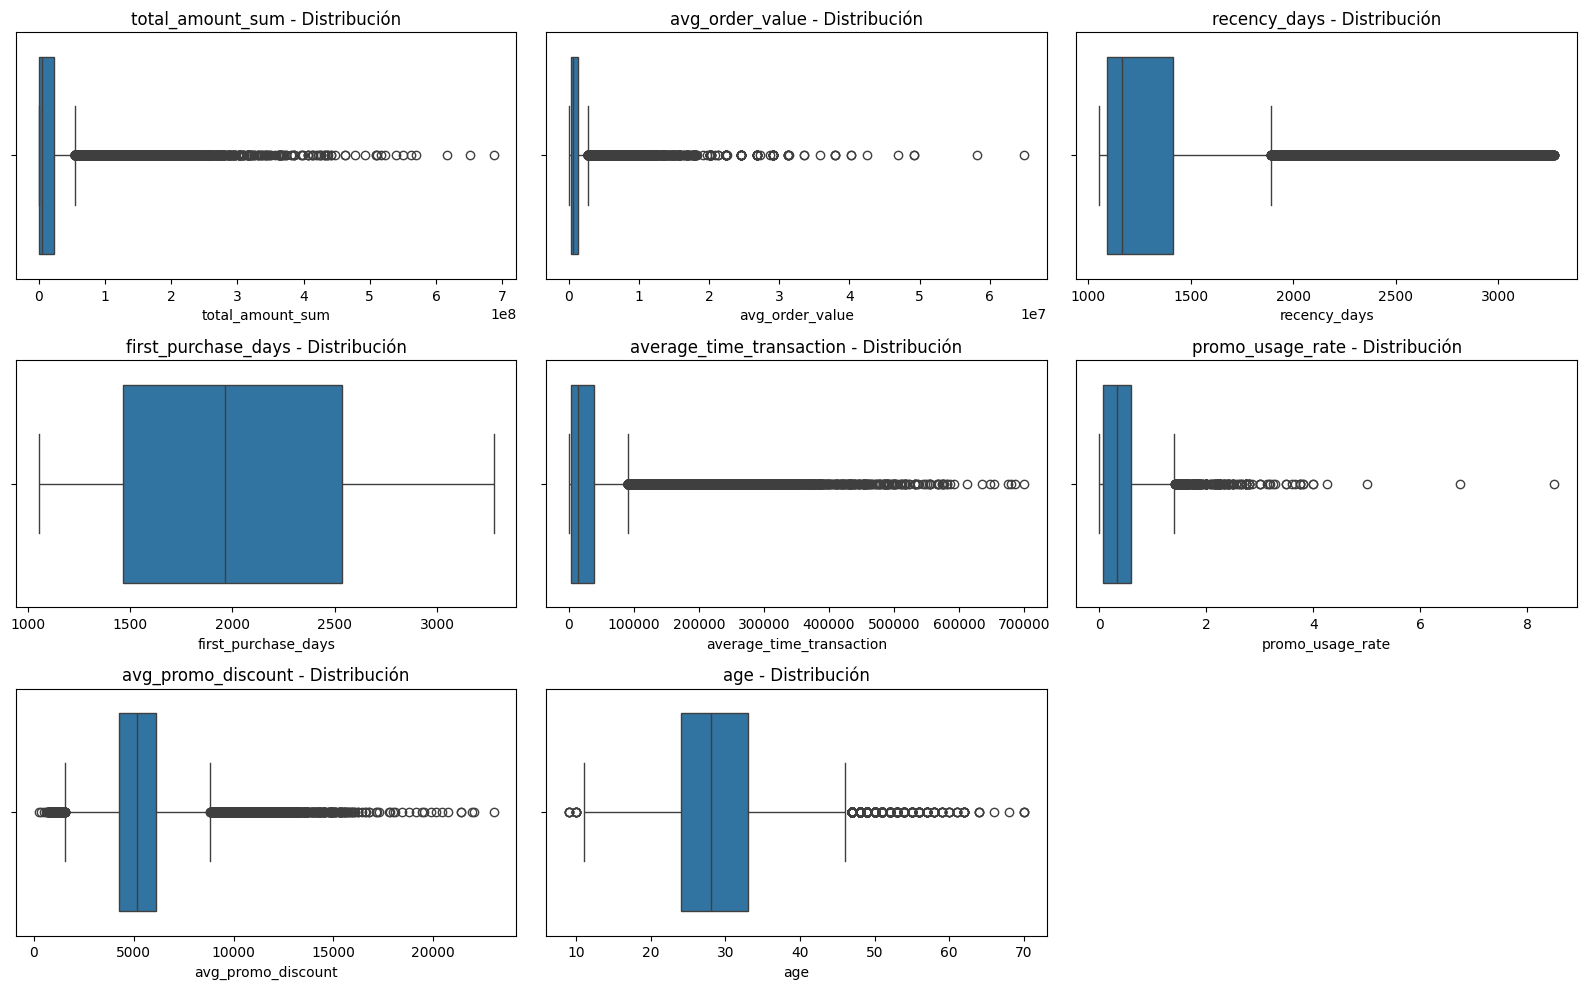


 Conteo de Outliers por Variable:
                          Número de Outliers
recency_days                            5420
total_amount_sum                        5354
average_time_transaction                4738
avg_order_value                         3872
avg_promo_discount                      1854
age                                      871
promo_usage_rate                         354
first_purchase_days                        0


In [7]:
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    total_amount_sum,
    avg_order_value,
    recency_days,
    first_purchase_days,
    average_time_transaction,
    promo_usage_rate,
    avg_promo_discount,
    age
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    VISUALIZACIÓN Y OUTLIERS
# ==============================
# Función para detectar outliers usando el método IQR
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# ==============================
#    VISUALIZACIÓN INDIVIDUAL
# ==============================
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} - Distribución')
plt.tight_layout()
plt.show()

# ==============================
#    CONTEO DE OUTLIERS POR VARIABLE
# ==============================
outliers_info = {}
for col in df.columns:
    outliers = detect_outliers(df[col])
    outliers_info[col] = len(outliers)
    
# Visualización del conteo de outliers
outliers_df = pd.DataFrame.from_dict(outliers_info, orient='index', columns=['Número de Outliers'])
print("\n Conteo de Outliers por Variable:")
print(outliers_df.sort_values(by='Número de Outliers', ascending=False))


## Tratamiento Progresivo de Outliers  

---

### **Objetivo del Análisis:**  
El objetivo principal es corregir los valores atípicos (outliers) presentes en las variables seleccionadas para el proceso de clustering.  
Un outlier puede distorsionar la media, afectar el escalado de las variables y perjudicar el rendimiento de los algoritmos de agrupamiento, especialmente en técnicas basadas en distancia como K-Means.

---

### **Estrategia de Tratamiento:**  
Se abordará el tratamiento de los outliers de manera **progresiva y controlada**, variable por variable.  
Para cada una, se realizarán los siguientes pasos:  
1. **Visualización Inicial:**  
   - Un **boxplot** para detectar la magnitud y dispersión de los valores extremos.  
   
2. **Aplicación de la Técnica de Tratamiento:**  
   - Se aplicará **Winsorization** al 5% para reducir el impacto de los outliers sin eliminarlos.  
   - Esta técnica "limita" los valores extremos al percentil 5% y 95%, preservando el orden sin distorsionar la distribución.

3. **Visualización Posterior:**  
   - Un **boxplot** actualizado para verificar la reducción de outliers.  
   
4. **Comparación Estadística:**  
   - Se contrastarán las estadísticas descriptivas antes y después del tratamiento.  

---

### **Variable Seleccionada para el Tratamiento:**  
La primera variable seleccionada para el proceso es **`total_amount_sum`**, que presenta un elevado número de outliers (**5354**).  
Estos valores extremos pueden estar influyendo de manera significativa en el comportamiento general del modelo, por lo que su corrección es prioritaria.

---

In [8]:
def tratar_outliers(variable):    
    # ==============================
    #    CARGA DE DATOS
    # ==============================
    query = f"""
    SELECT 
        {variable}
    FROM customer_segmentation_optimized_v2
    """
    
    # Leer los datos en un DataFrame
    df = pd.read_sql_query(query, engine)
    
    # ==============================
    #    CONTEO DE OUTLIERS ANTES DEL TRATAMIENTO
    # ==============================
    outliers_before = detect_outliers(df[variable])
    
    
    # ==============================
    #    VISUALIZACIÓN ANTES DEL TRATAMIENTO
    # ==============================
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[variable])
    plt.title(f'Distribución Original - {variable}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title(f'Histograma Original - {variable}')
    
    plt.tight_layout()
    plt.show()
    
    # ==============================
    #    TRANSFORMACIÓN 1: WINSORIZATION (10%)
    # ==============================
    df[f'{variable}_winsorized'] = mstats.winsorize(df[variable], limits=[0.1, 0.1])
    
    # ==============================
    #    CONTEO DE OUTLIERS DESPUÉS DE WINSORIZATION
    # ==============================
    outliers_winsorized = detect_outliers(df[f'{variable}_winsorized'])
    
    
    # ==============================
    #    VISUALIZACIÓN POSTERIOR A WINSORIZATION
    # ==============================
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[f'{variable}_winsorized'])
    plt.title(f'Winsorized (10%) - {variable}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[f'{variable}_winsorized'], bins=30, kde=True)
    plt.title(f'Histograma Winsorized - {variable}')
    
    plt.tight_layout()
    plt.show()
    
    # ==============================
    #    TRANSFORMACIÓN 2: LOGARÍTMICA
    # ==============================
    df[f'{variable}_log'] = np.log1p(df[variable])
    
    # ==============================
    #    CONTEO DE OUTLIERS DESPUÉS DE LOGARÍTMICA
    # ==============================
    outliers_log = detect_outliers(df[f'{variable}_log'])
    
    
    # ==============================
    #    VISUALIZACIÓN POSTERIOR A LOGARITMO
    # ==============================
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[f'{variable}_log'])
    plt.title(f'Log Transform - {variable}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[f'{variable}_log'], bins=30, kde=True)
    plt.title(f'Histograma Log Transform - {variable}')
    
    plt.tight_layout()
    plt.show()
    
    # ==============================
    #    COMPARACIÓN ESTADÍSTICA
    # ==============================
    print("\nComparación de estadísticas:")
    print("Antes del tratamiento:")
    print(df[variable].describe())
    print("\nDespués de Winsorization (10%):")
    print(df[f'{variable}_winsorized'].describe())
    print("\nDespués de Log Transform:")
    print(df[f'{variable}_log'].describe())
    print(f"\nNúmero de Outliers (Antes del Tratamiento): {len(outliers_before)}")
    print(f"\nNúmero de Outliers (Después de Winsorization 10%): {len(outliers_winsorized)}")
    print(f"\nNúmero de Outliers (Después de Log Transform): {len(outliers_log)}")

CPU times: total: 0 ns
Wall time: 0 ns


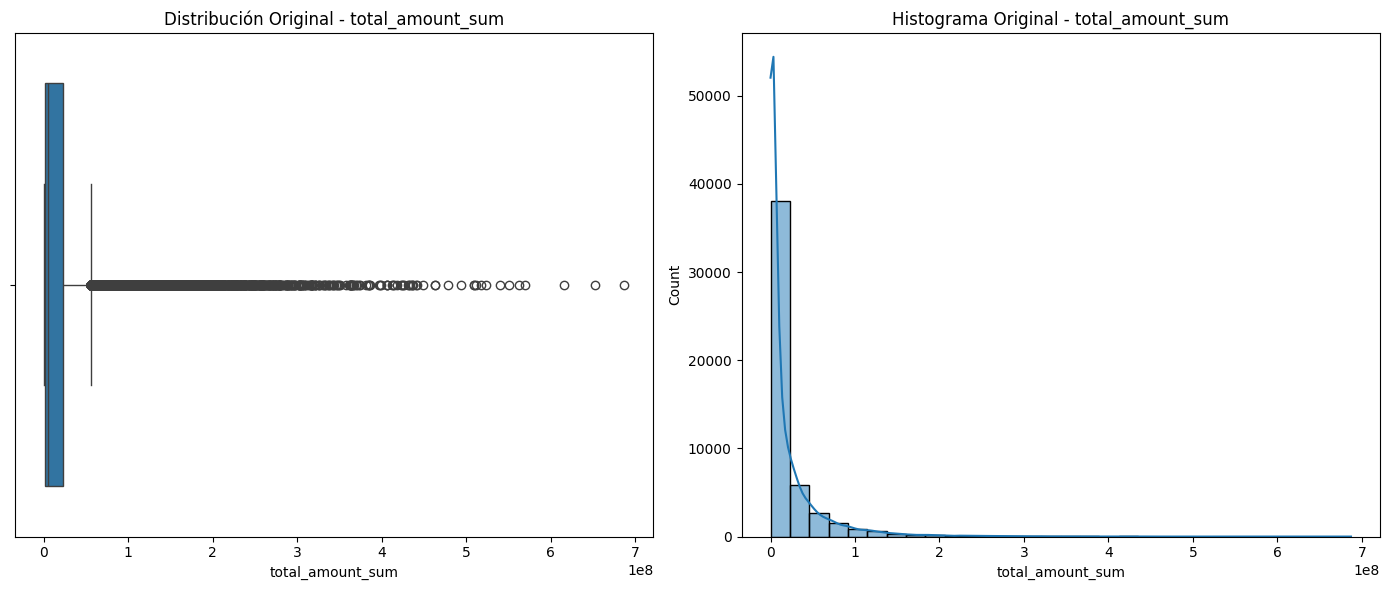

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


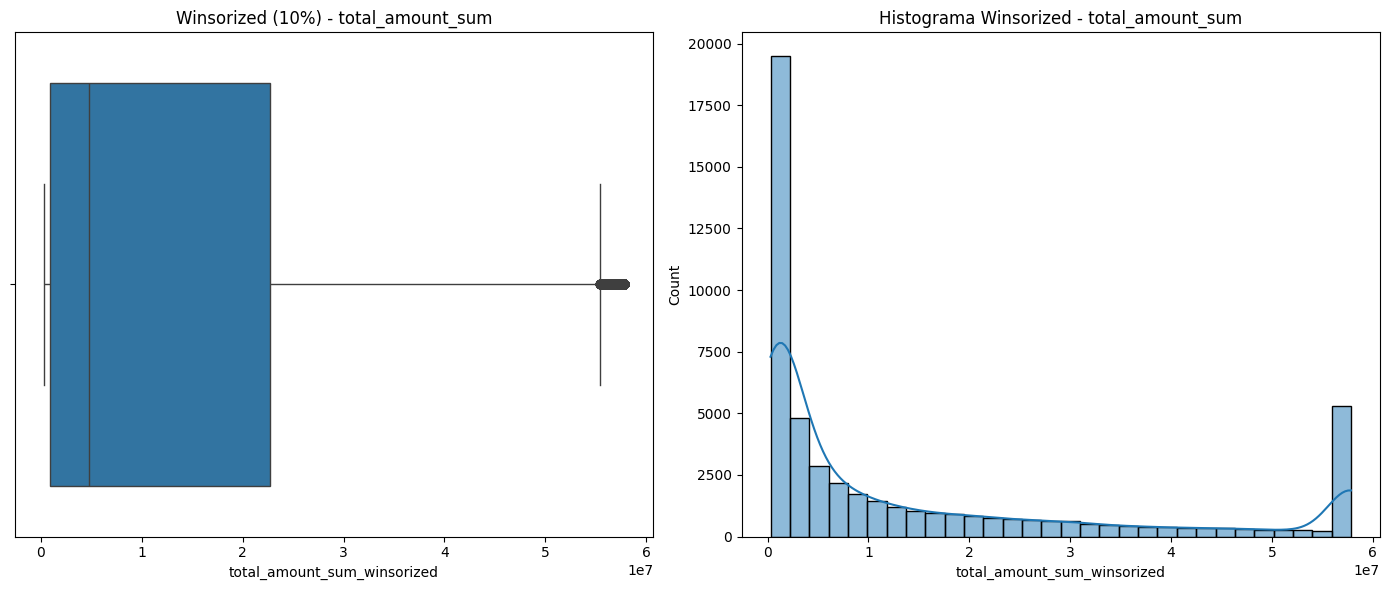

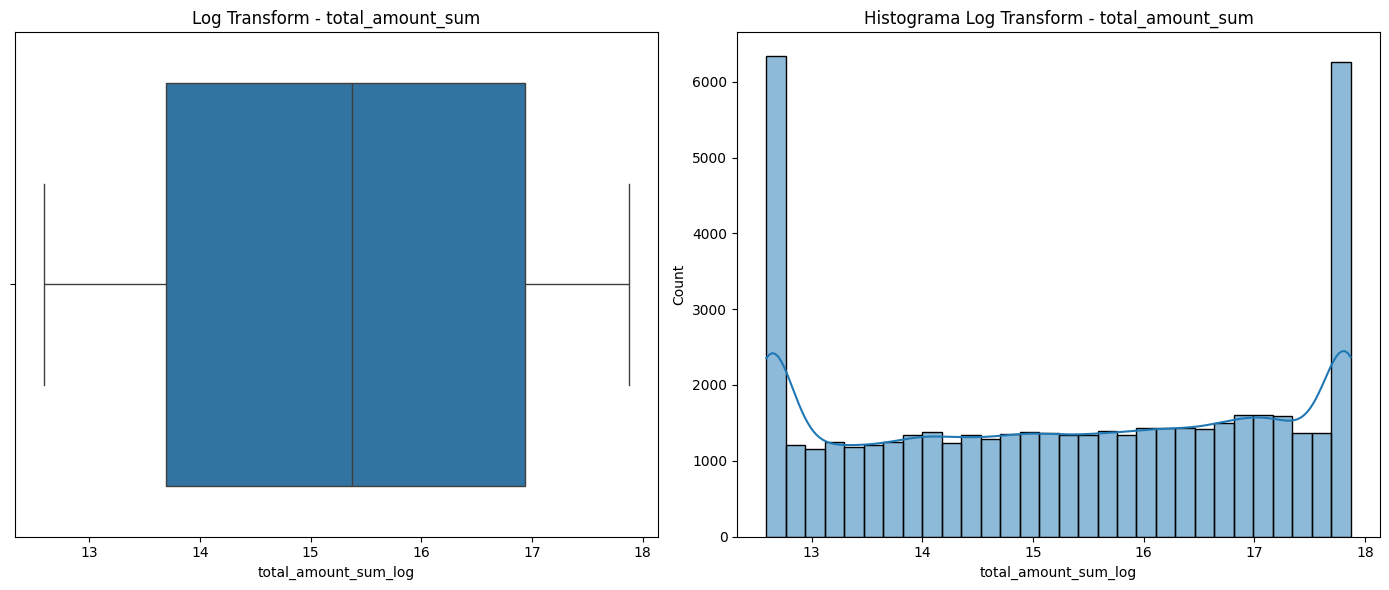


Comparación de estadísticas:
Antes del tratamiento:
count    5.070400e+04
mean     1.489547e+07
std      1.925349e+07
min      2.938630e+05
25%      8.851530e+05
50%      4.765066e+06
75%      2.268505e+07
max      5.783801e+07
Name: total_amount_sum, dtype: float64

Después de Winsorization (10%):
count    5.070400e+04
mean     1.489547e+07
std      1.925349e+07
min      2.938630e+05
25%      8.851530e+05
50%      4.765066e+06
75%      2.268505e+07
max      5.783801e+07
Name: total_amount_sum_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean        15.304619
std          1.793602
min         12.590872
25%         13.693517
50%         15.376822
75%         16.937217
max         17.873157
Name: total_amount_sum_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 5354

Número de Outliers (Después de Winsorization 10%): 5354

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [9]:
%time
tratar_outliers("total_amount_sum")

## Tratamiento de Outliers en la Variable `total_amount_sum`  

---

### **Distribución Original:**  
La distribución original de la variable `total_amount_sum` muestra una alta concentración de valores en rangos bajos y un número significativo de outliers en la parte superior de la distribución.  
- En total se detectaron **5354 outliers**.
- El boxplot inicial confirma una gran dispersión en los valores altos, generando una cola larga en el histograma.

---

### **Transformación con Winsorization (10%)**  
Se aplicó Winsorization al 10%, con el objetivo de reducir el impacto de los valores extremos. Sin embargo:  
- **Número de outliers:** Se mantuvo en **5354**, indicando que no hubo un recorte efectivo de los valores extremos.  
- **Estadísticas:** Los valores de mínimo, máximo y percentiles no cambiaron, lo cual refleja que Winsorization no afectó sustancialmente la distribución.

---

### **Transformación Logarítmica**  
Para corregir esta situación, se aplicó una **Transformación Logarítmica**. Los resultados fueron:  
- El boxplot posterior muestra una distribución más equilibrada y sin outliers evidentes.  
- El histograma revela una forma más simétrica, lo cual facilita su inclusión en un modelo de clustering.  
- El número de outliers después de la transformación logarítmica es **0**, lo cual representa una mejora notable en el ajuste.  

---

### **Conclusión Final:**  
1. La aplicación de Winsorization no fue efectiva en reducir los outliers de `total_amount_sum`.  
2. La transformación logarítmica sí logró una mejora sustancial en la distribución y eliminó los outliers detectados.  
3. Esta transformación será la elegida para el preprocesamiento final de esta variable.  

---

## Creación de una Tabla para Almacenar Resultados Sin Outliers  

---

### **Objetivo:**  
A medida que vayamos tratando los outliers de cada una de las variables seleccionadas, crearemos una tabla optimizada en PostgreSQL para almacenar los resultados.  
Esto nos permitirá:  
- Consolidar progresivamente cada variable limpia y transformada.  
- Evitar reprocesamientos en futuros análisis.  
- Facilitar la integración en el proceso de clustering.  

---

### **Estrategia de Creación:**  
**Nombre de la tabla:**  
La tabla se llamará `customer_segmentation_cleaned`.  

**Estructura inicial:**  
- `customer_id`: Identificador único del cliente.  
- Variables transformadas y optimizadas después del tratamiento de outliers.  

**Proceso de actualización:**  
- Cada vez que una variable sea tratada y optimizada, se añadirá a esta tabla.  
- Las variables se irán incluyendo una a una para evitar pérdidas de información y facilitar la validación.  

**Ventajas:**  
- Simplificación de consultas futuras.  
- Preparación directa para el proceso de escalado y clustering.  
- Evitar cargas innecesarias en memoria, optimizando el espacio en disco.  

---

### **Próximos Pasos:**  
- Generaremos un script para crear la tabla inicial.  
- Añadiremos la primera variable transformada: **`total_amount_sum`** (en su versión logarítmica).  
- Visualizaremos los datos para validar el resultado.  

---


In [10]:
%%time
# ==============================
#    CREACIÓN DE LA TABLA
# ==============================
create_table_query = """
DROP TABLE IF EXISTS customer_segmentation_cleaned;

CREATE TABLE customer_segmentation_cleaned (
    customer_id BIGINT PRIMARY KEY,
    total_amount_sum_log NUMERIC
);
"""

# Ejecutar la creación
try:
    with engine.connect() as connection:
        connection.execute(text(create_table_query))
        connection.commit()
        print("✅ Tabla 'customer_segmentation_cleaned' creada correctamente.")
except Exception as e:
    print("❌ Error en la creación de la tabla:", e)

# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    total_amount_sum
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar transformación logarítmica
df['total_amount_sum_log'] = np.log1p(df['total_amount_sum'])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    df[['customer_id', 'total_amount_sum_log']].to_sql(
        'customer_segmentation_cleaned',
        engine,
        if_exists='append',
        index=False
    )
    print("✅ Variable 'total_amount_sum_log' insertada correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT * FROM customer_segmentation_cleaned LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\n📌 Muestra de Datos Insertados:")
print(df_validation.head())


✅ Tabla 'customer_segmentation_cleaned' creada correctamente.
✅ Variable 'total_amount_sum_log' insertada correctamente.

📌 Muestra de Datos Insertados:
   customer_id  total_amount_sum_log
0          654             12.084905
1         6573             12.120689
2        38802             12.665398
3        84282             16.355920
4        57707             13.144121
CPU times: total: 422 ms
Wall time: 682 ms


## Tratamiento de Outliers para la Variable `avg_order_value`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `avg_order_value`. Esta variable representa el valor promedio de cada pedido realizado por los clientes y, según el análisis exploratorio inicial, presenta un número significativo de outliers que podrían distorsionar los resultados del clustering.

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---



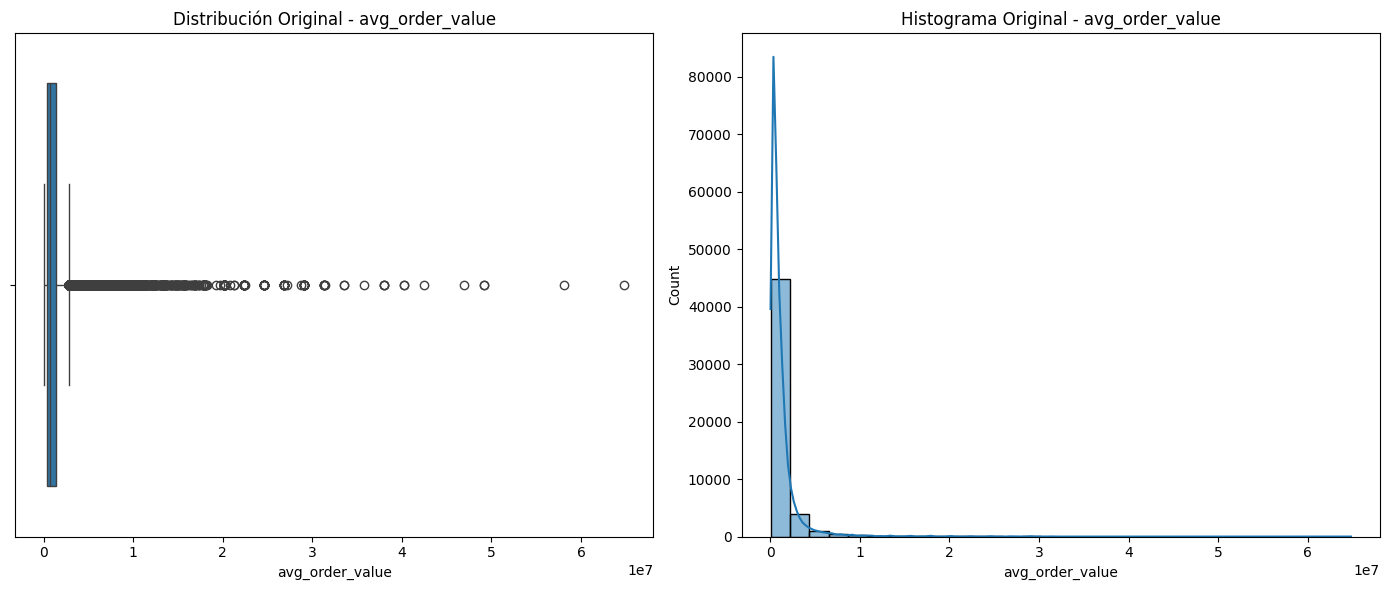

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


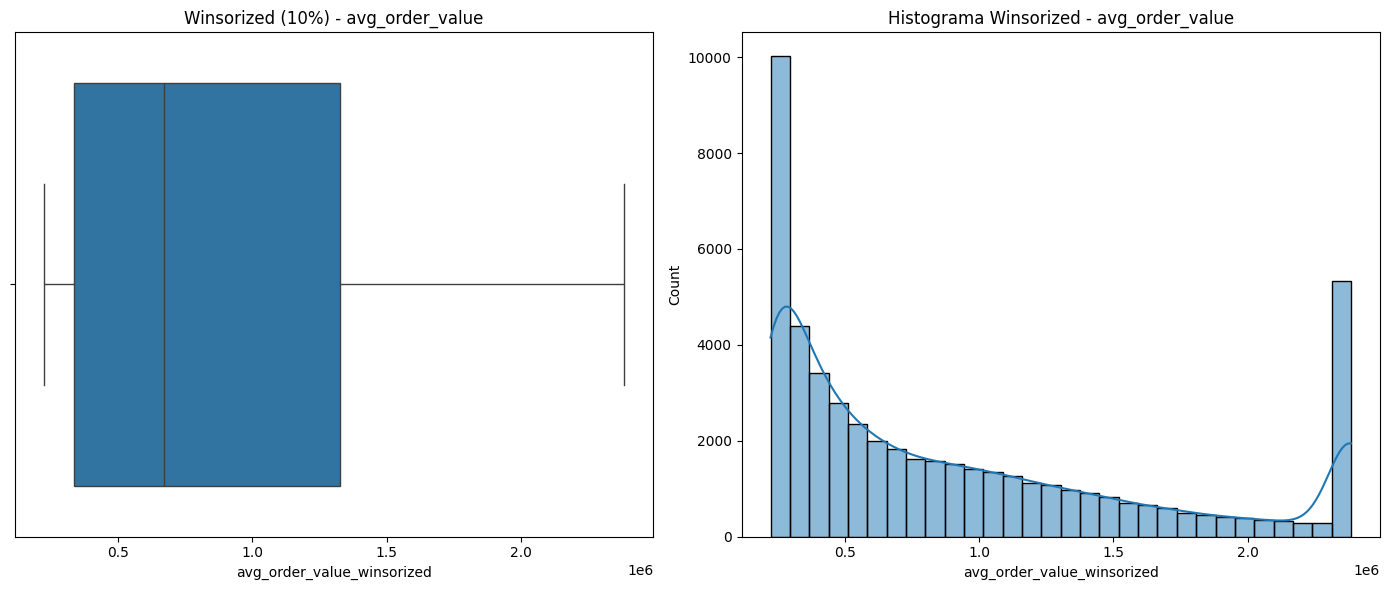

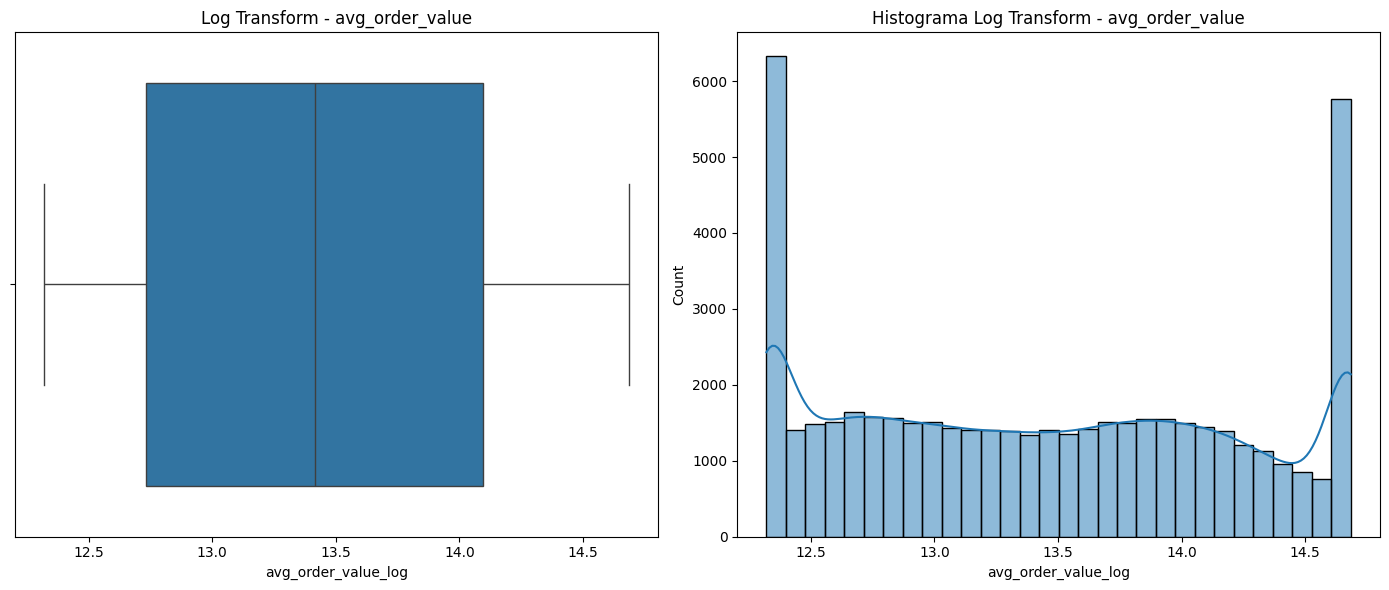


Comparación de estadísticas:
Antes del tratamiento:
count    5.070400e+04
mean     9.243954e+05
std      7.039106e+05
min      2.241138e+05
25%      3.379122e+05
50%      6.717369e+05
75%      1.325159e+06
max      2.383633e+06
Name: avg_order_value, dtype: float64

Después de Winsorization (10%):
count    5.070400e+04
mean     9.243954e+05
std      7.039106e+05
min      2.241138e+05
25%      3.379122e+05
50%      6.717369e+05
75%      1.325159e+06
max      2.383633e+06
Name: avg_order_value_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean        13.440004
std          0.783784
min         12.319913
25%         12.730544
50%         13.417623
75%         14.097044
max         14.684137
Name: avg_order_value_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 3872

Número de Outliers (Después de Winsorization 10%): 0

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [11]:
tratar_outliers("avg_order_value")

## Tratamiento de Outliers en la Variable `avg_order_value`  

---

### **Distribución Original:**  
La distribución original de la variable `avg_order_value` muestra una concentración de valores en rangos bajos y una **cola larga hacia la derecha**, indicando un conjunto significativo de outliers.  
- **Número de outliers antes del tratamiento:** **3872**  
- El histograma revela una **asimetría positiva**, con muchos valores bajos y pocos valores altos.  
- El boxplot muestra un rango intercuartílico ajustado, pero con una cola larga de valores atípicos.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se redujo a **0**, lo que indica un recorte efectivo de los valores extremos.  
  - El boxplot posterior muestra una distribución mucho más compacta, eliminando la cola larga.  
  - El histograma también muestra una distribución más homogénea.  
- **Estadísticas:**  
  - Los valores mínimo y máximo se ajustaron a rangos más razonables, preservando la forma general de la distribución.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers también se redujo a **0**.  
  - La distribución es más simétrica y ajustada, aunque el histograma muestra aún cierta acumulación en los extremos.  
- **Estadísticas:**  
  - La media y los cuartiles se ajustaron a una escala logarítmica, mostrando menor dispersión.  

---

### **Conclusión Final:**  
1. **Ambas transformaciones (Winsorization y Log Transform) eliminaron por completo los outliers.**  
2. **Winsorization (10%)** es efectiva para mantener la escala original con valores acotados.  
3. **Transformación Logarítmica** es útil si queremos **reducir la asimetría** y lograr una distribución más simétrica.  
4. Dado que ambas técnicas eliminan los outliers de forma efectiva, se puede optar por cualquiera de las dos en el modelo final. Sin embargo, se recomienda el uso de **Log Transform** para garantizar la simetría y facilitar el clustering.  

---

### **Próximos Pasos:**  
- Actualizar la tabla `customer_segmentation_cleaned` con la variable transformada `avg_order_value_log`.  
- Continuar con el análisis y tratamiento de la siguiente variable: **`average_time_transaction`**.  


In [12]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    avg_order_value
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar transformación logarítmica
df['avg_order_value_log'] = np.log1p(df['avg_order_value'])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS avg_order_value_log NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'avg_order_value_log' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['avg_order_value_log', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET avg_order_value_log = updates.avg_order_value_log
    FROM (VALUES {}) AS updates(avg_order_value_log, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'avg_order_value_log' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, avg_order_value_log 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())



✅ Columna 'avg_order_value_log' añadida correctamente.
✅ Datos de 'avg_order_value_log' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  avg_order_value_log
0          654            12.084905
1         6573            12.120689
2        38802            12.665398
3        84282            15.662773
4        57707            13.144121
CPU times: total: 219 ms
Wall time: 704 ms


## Tratamiento de Outliers para la Variable `average_time_transaction`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `average_time_transaction`. Esta variable representa el tiempo promedio que los clientes permanecen en sesiones de compra y, según el análisis exploratorio inicial, presenta un número significativo de outliers que podrían distorsionar los resultados del clustering.

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---


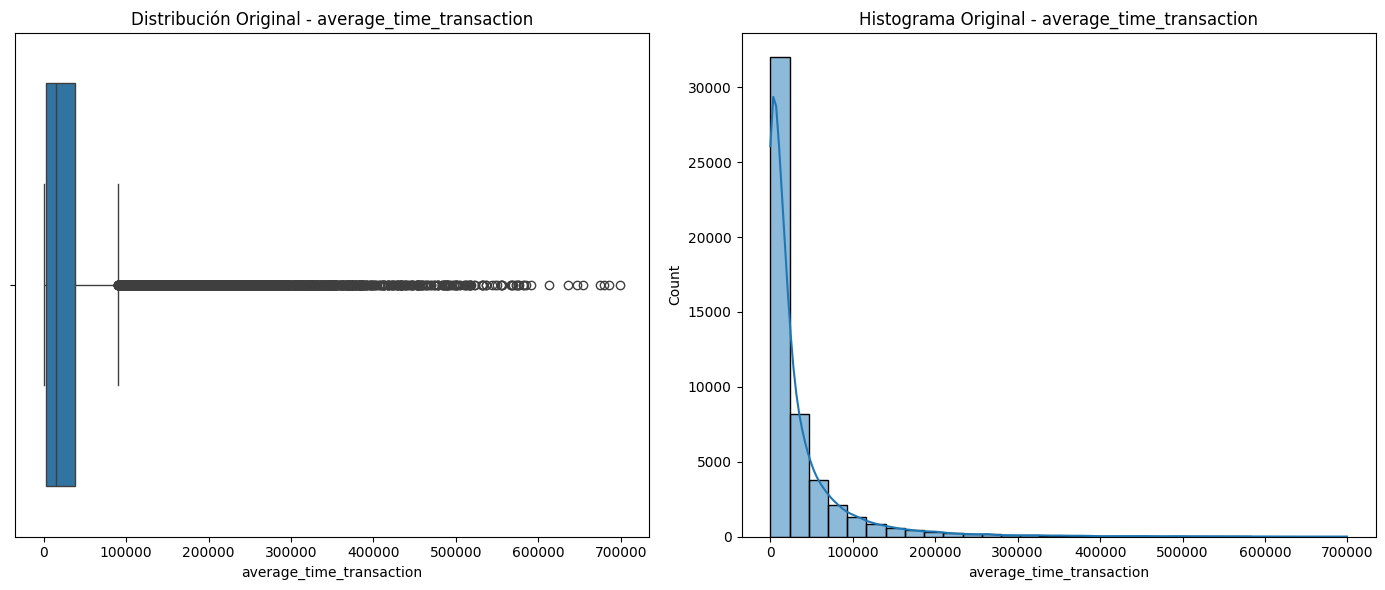

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


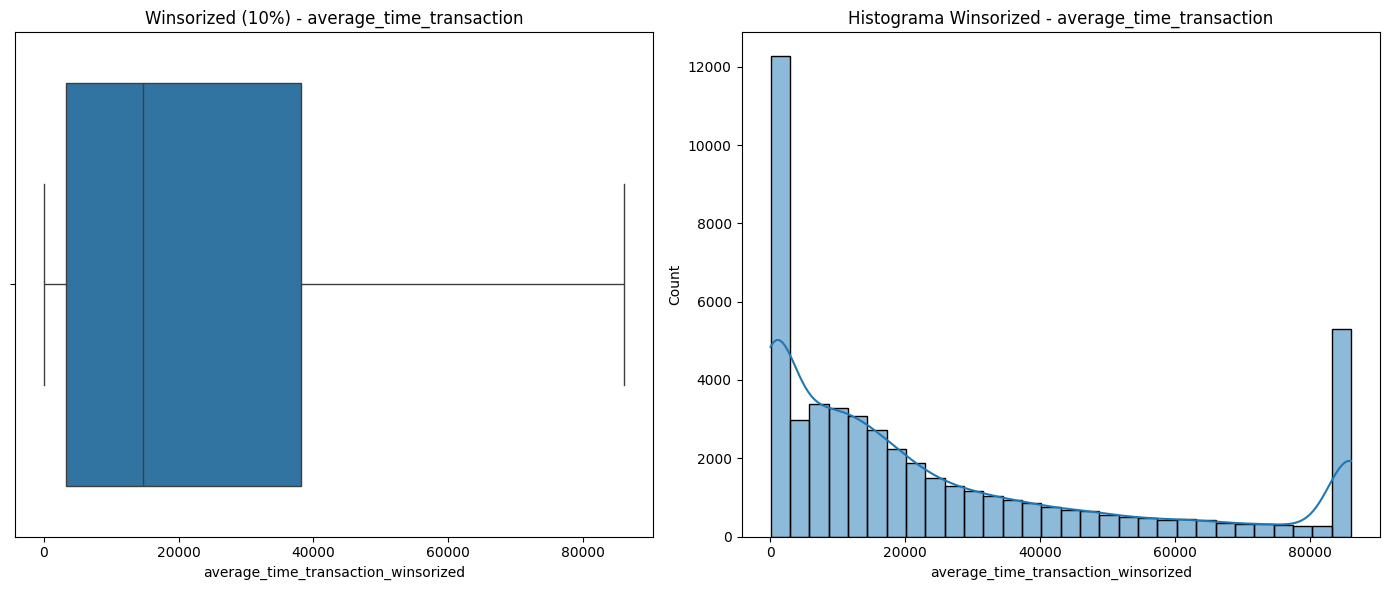

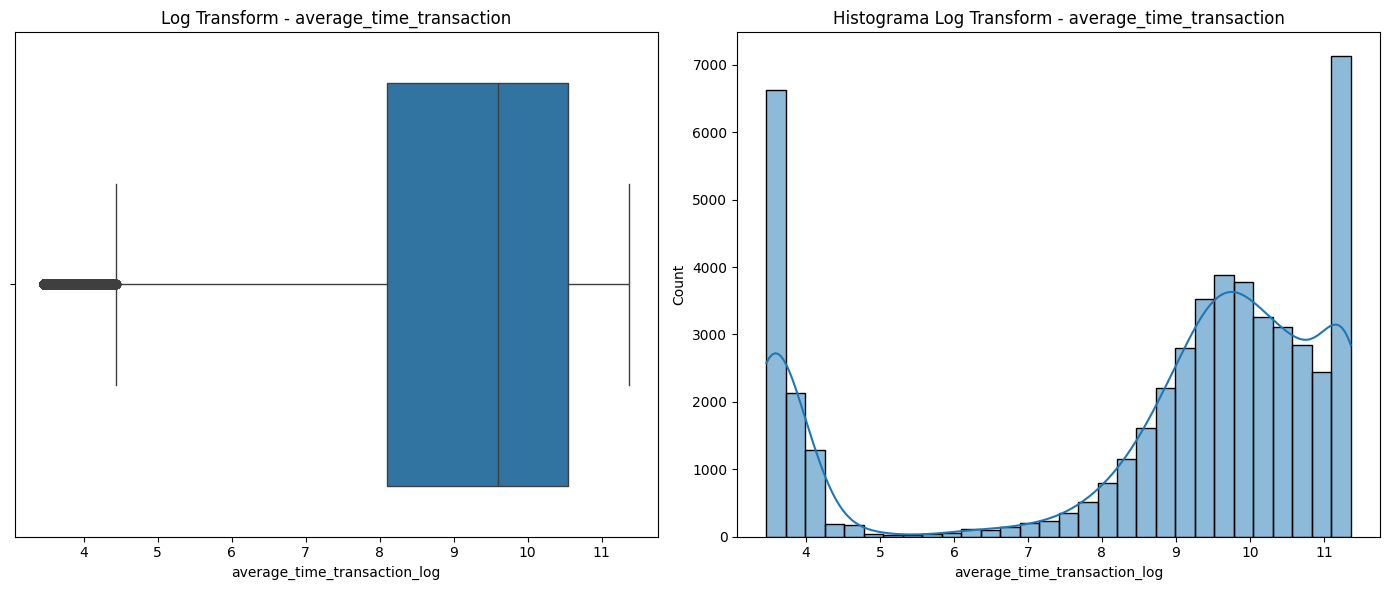


Comparación de estadísticas:
Antes del tratamiento:
count    50704.000000
mean     25526.702070
std      28026.443850
min         30.945215
25%       3307.979233
50%      14691.709655
75%      38182.177636
max      86133.258392
Name: average_time_transaction, dtype: float64

Después de Winsorization (10%):
count    50704.000000
mean     25526.702070
std      28026.443850
min         30.945215
25%       3307.979233
50%      14691.709655
75%      38182.177636
max      86133.258392
Name: average_time_transaction_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean         8.628985
std          2.700553
min          3.464022
25%          8.104395
50%          9.595107
75%         10.550150
max         11.363663
Name: average_time_transaction_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 4738

Número de Outliers (Después de Winsorization 10%): 0

Número de Outliers (Después de Log Transform): 10175


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [13]:
tratar_outliers("average_time_transaction")

## Tratamiento de Outliers en la Variable `average_time_transaction`  

---

### **Distribución Original:**  
La distribución original de la variable `average_time_transaction` muestra una alta concentración de valores en rangos bajos y un número significativo de outliers en la parte superior de la distribución.  
- **Número de outliers antes del tratamiento:** **4738**  
- El boxplot inicial confirma una gran dispersión en los valores altos, generando una cola larga en el histograma.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se redujo a **0**, lo cual parece correcto en cuanto a los límites fijados.  
  - Sin embargo, al revisar las estadísticas, los valores mínimo, máximo y cuartiles no sufrieron cambios significativos.  
  - Esto indica que la técnica de Winsorization **no tuvo un efecto real** en la variable, ya que el máximo sigue siendo **86133.25**.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers se **incrementó** a **10175**.  
  - Este resultado no es esperable, y sugiere que la transformación logarítmica no fue efectiva en reducir la dispersión de los datos, sino que la acentuó.  
  - El histograma muestra una acumulación intensa en los valores superiores.  

---

### **Conclusión Final:**  
1. **Winsorization (10%) no logró reducir realmente los outliers.**  
2. **Transformación Logarítmica** generó más outliers de los que había inicialmente, lo cual no es aceptable.  
3. **Propuesta:**  
   - Podríamos optar por un **Winsorization más agresivo (15%)**.  
   - Otra opción sería un escalado basado en cuantiles o un recorte más estricto.  

---

### **Próximos Pasos:**  
- Pruebas de distintos grados de Winsorización 
---


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib

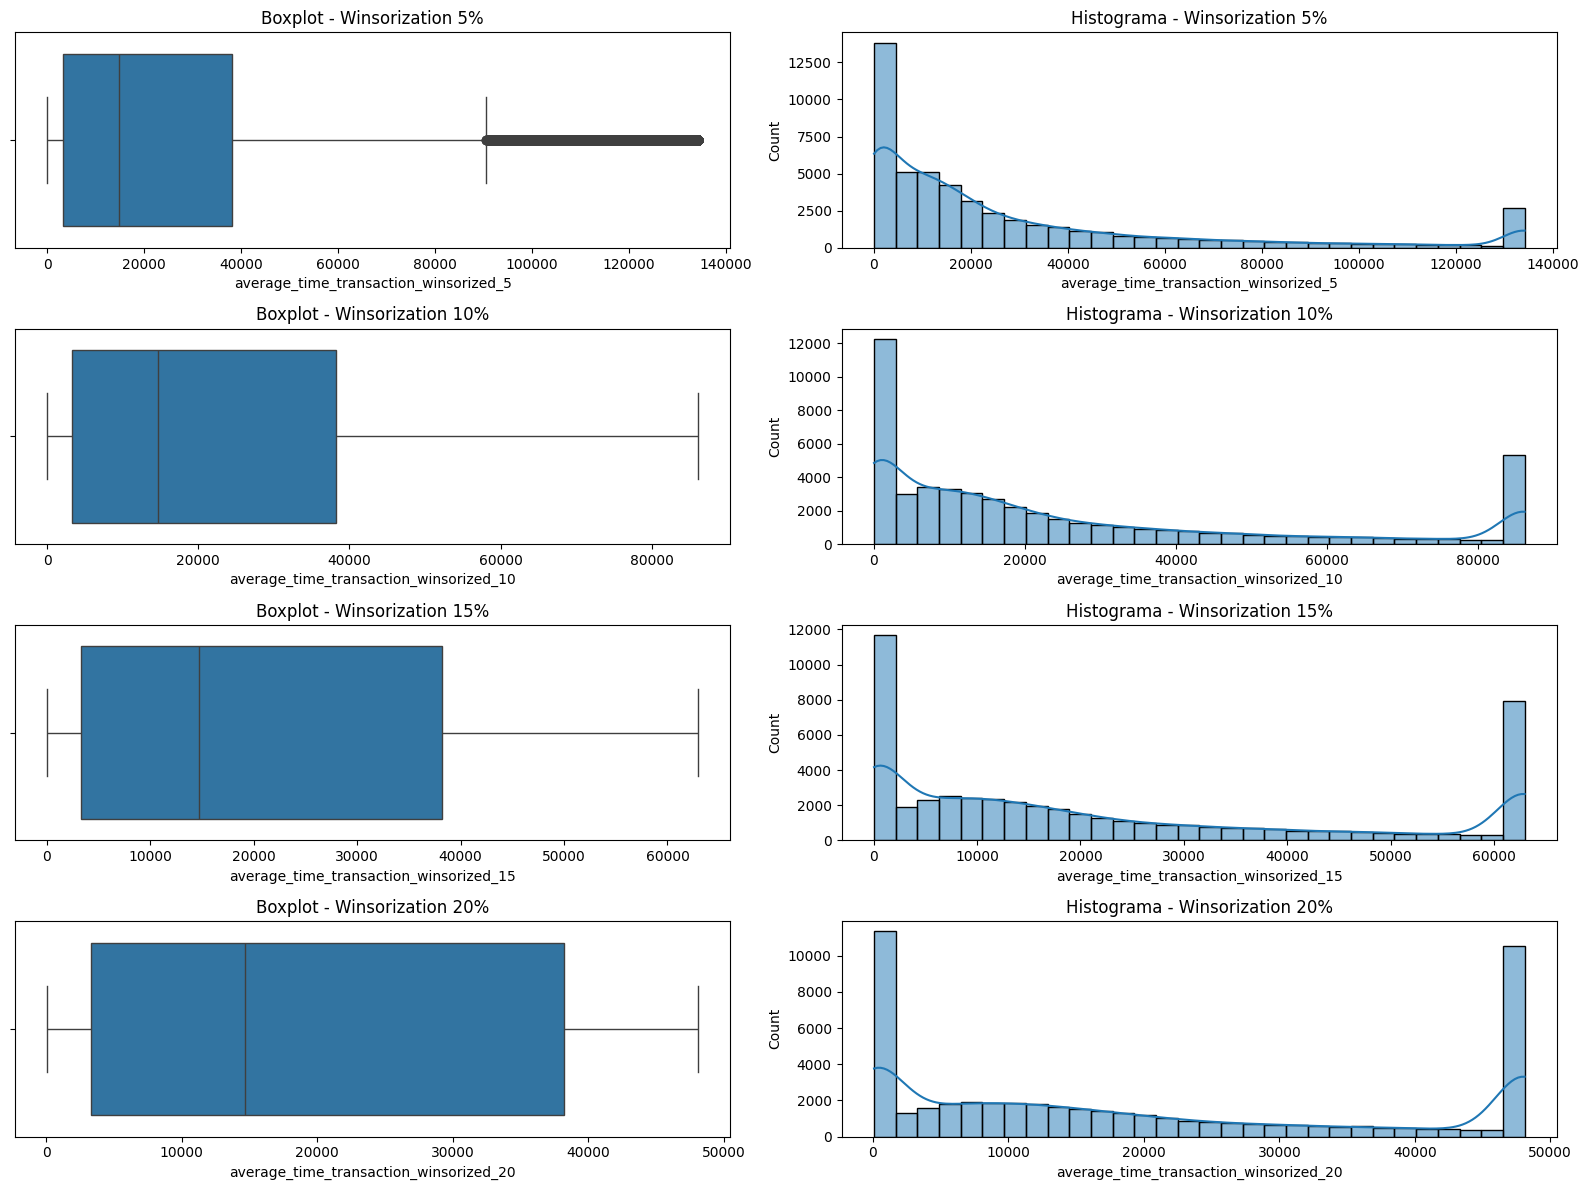


**Comparación del Número de Outliers por Porcentaje:**
average_time_transaction_winsorized_5: 4738 outliers
average_time_transaction_winsorized_10: 0 outliers
average_time_transaction_winsorized_15: 0 outliers
average_time_transaction_winsorized_20: 0 outliers

Estadísticas para average_time_transaction_winsorized_5:
count     50704.000000
mean      28951.403285
std       36533.766926
min          15.235886
25%        3307.979233
50%       14691.709655
75%       38182.177636
max      134193.340435
Name: average_time_transaction_winsorized_5, dtype: float64

Estadísticas para average_time_transaction_winsorized_10:
count    50704.000000
mean     25526.702070
std      28026.443850
min         30.945215
25%       3307.979233
50%      14691.709655
75%      38182.177636
max      86133.258392
Name: average_time_transaction_winsorized_10, dtype: float64

Estadísticas para average_time_transaction_winsorized_15:
count    50704.000000
mean     22684.859455
std      22426.319582
min         46.

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [14]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    customer_id,
    average_time_transaction
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    PRUEBA DE WINSORIZATION
# ==============================
winsor_limits = [0.05, 0.1, 0.15, 0.2]
results = {}

plt.figure(figsize=(16, 12))

for idx, limit in enumerate(winsor_limits, 1):
    # Aplicar Winsorization
    column_name = f'average_time_transaction_winsorized_{int(limit*100)}'
    df[column_name] = mstats.winsorize(df['average_time_transaction'], limits=[limit, limit])
    
    # Conteo de outliers
    outliers_count = len(detect_outliers(df[column_name]))
    results[column_name] = outliers_count
    
    # Visualización
    plt.subplot(4, 2, idx * 2 - 1)
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot - Winsorization {int(limit*100)}%')

    plt.subplot(4, 2, idx * 2)
    sns.histplot(df[column_name], bins=30, kde=True)
    plt.title(f'Histograma - Winsorization {int(limit*100)}%')

plt.tight_layout()
plt.show()

# ==============================
#    RESUMEN DE RESULTADOS
# ==============================
print("\n**Comparación del Número de Outliers por Porcentaje:**")
for column, count in results.items():
    print(f"{column}: {count} outliers")

# ==============================
#    COMPARACIÓN DE ESTADÍSTICAS
# ==============================
for column in results.keys():
    print(f"\nEstadísticas para {column}:")
    print(df[column].describe())


## Análisis de Winsorization en la Variable `average_time_transaction`  

---

### **Distribución Original:**  
La distribución original de `average_time_transaction` muestra un número significativo de outliers, exactamente **4738** valores fuera de los límites intercuartílicos (IQR).  

---

### **Prueba de Winsorization con Diferentes Porcentajes:**  
Para determinar el nivel adecuado de Winsorization, se aplicaron distintos porcentajes de recorte en los extremos:  
- **5%:** El número de outliers se mantuvo igual (**4738**), lo cual indica que este recorte es insuficiente.  
- **10%:** Se eliminaron completamente los outliers, pero los valores máximos aún son elevados (**86133.25**).  
- **15%:** El máximo se reduce a **62950.34** y no se detectaron outliers.  
- **20%:** El máximo se reduce aún más a **48106.32** y tampoco se detectaron outliers.  

---

### **Análisis Estadístico por Nivel de Winsorization:**  

| Nivel de Winsorization | Media       | Desviación Estándar | Mínimo       | Máximo          | Número de Outliers |
|-------------------------|-------------|---------------------|--------------|------------------|--------------------|
| 5%                     | 28951.40    | 36533.77           | 15.24        | 134193.34       | 4738              |
| 10%                    | 25526.70    | 28026.44           | 30.95        | 86133.26        | 0                 |
| 15%                    | 22684.85    | 22426.31           | 46.24        | 62950.34        | 0                 |
| 20%                    | 20117.33    | 18133.31           | 78.68        | 48106.32        | 0                 |

---

### **Conclusión Final:**  
1. **5% de Winsorization es insuficiente**, ya que no elimina los outliers.  
2. **10% reduce los outliers**, pero todavía hay un rango máximo muy alto (**86133.26**).  
3. **15% y 20%** son los que mejor comprimen el rango de datos.  
   - Si se busca un ajuste más conservador, el **15%** parece adecuado.  
   - Si se quiere evitar completamente valores extremos, el **20%** es la mejor opción.  

---

### **Propuesta:**  
- Aplicar **20% de Winsorization** para asegurar que no existan valores extremos desproporcionados.  
- Esta opción reduce el máximo a **48106.32**, lo cual es más representativo y evita sesgos en el modelo.  

---

### **Próximos Pasos:**  
- Aplicar Winsorization al **20%** en la variable y proceder con la inserción en la tabla optimizada.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---


In [15]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    average_time_transaction
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar Winsorization al 20%
df['average_time_transaction_winsorized'] = mstats.winsorize(df['average_time_transaction'], limits=[0.2, 0.2])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS average_time_transaction_winsorized NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'average_time_transaction_winsorized' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['average_time_transaction_winsorized', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET average_time_transaction_winsorized = updates.average_time_transaction_winsorized
    FROM (VALUES {}) AS updates(average_time_transaction_winsorized, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'average_time_transaction_winsorized' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, average_time_transaction_winsorized 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


✅ Columna 'average_time_transaction_winsorized' añadida correctamente.
✅ Datos de 'average_time_transaction_winsorized' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  average_time_transaction_winsorized
0          654                            78.678072
1         6573                            78.678072
2        38802                            78.678072
3        84282                         22880.298261
4        57707                            78.678072
CPU times: total: 297 ms
Wall time: 781 ms


## Tratamiento de Outliers para la Variable `promo_usage_rate`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `promo_usage_rate`. Esta variable representa la tasa de uso de promociones por parte de los clientes y, según el análisis exploratorio inicial, presenta un número significativo de outliers que podrían distorsionar los resultados del clustering.

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---

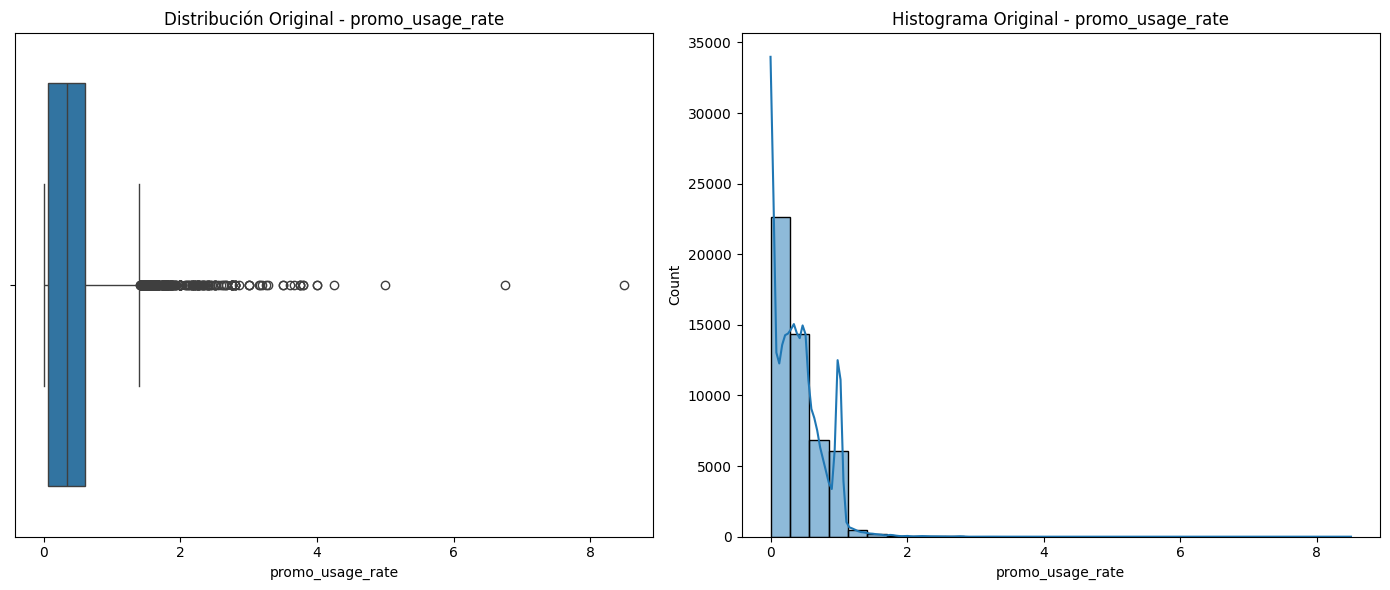

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


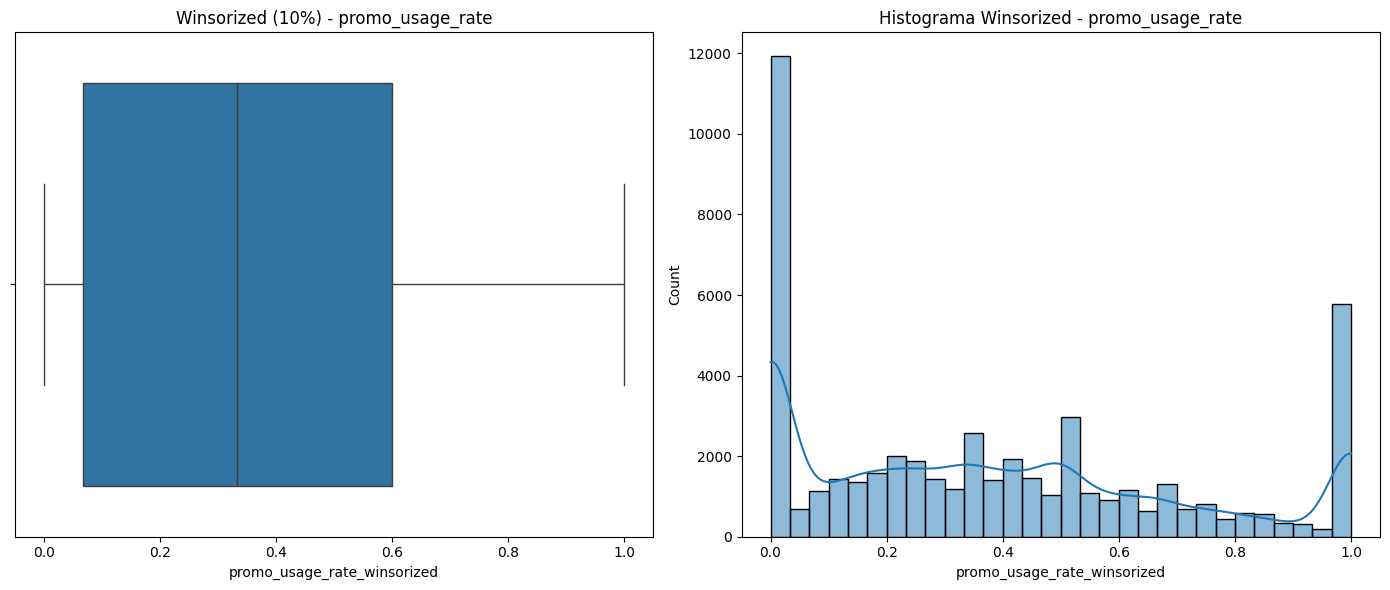

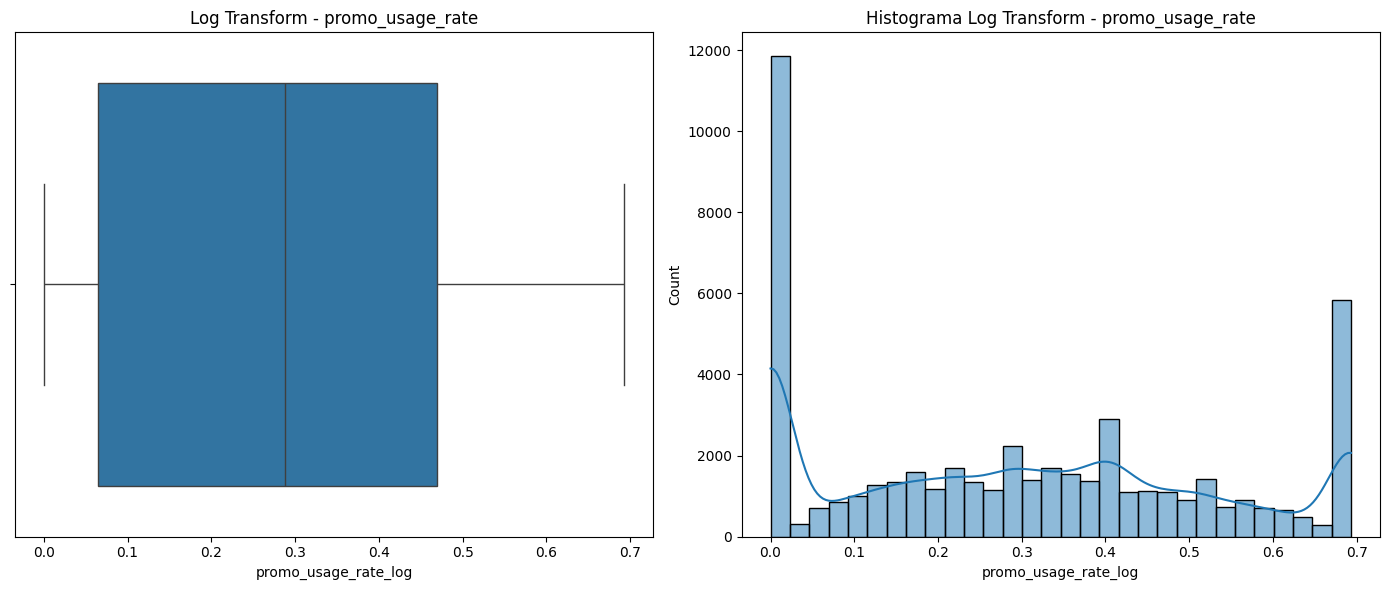


Comparación de estadísticas:
Antes del tratamiento:
count    50704.000000
mean         0.380721
std          0.330455
min          0.000000
25%          0.066667
50%          0.333333
75%          0.600000
max          1.000000
Name: promo_usage_rate, dtype: float64

Después de Winsorization (10%):
count    50704.000000
mean         0.380721
std          0.330455
min          0.000000
25%          0.066667
50%          0.333333
75%          0.600000
max          1.000000
Name: promo_usage_rate_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean         0.294896
std          0.233807
min          0.000000
25%          0.064539
50%          0.287682
75%          0.470004
max          0.693147
Name: promo_usage_rate_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 354

Número de Outliers (Después de Winsorization 10%): 0

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [16]:
tratar_outliers("promo_usage_rate")

## Tratamiento de Outliers en la Variable `promo_usage_rate`  

---

### **Distribución Original:**  
La distribución original de la variable `promo_usage_rate` muestra una alta concentración de valores en rangos bajos y un conjunto significativo de outliers dispersos en valores altos.  
- **Número de outliers antes del tratamiento:** **354**  
- El boxplot inicial confirma una gran dispersión en los valores superiores, generando una cola larga en el histograma.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se redujo a **0**.  
  - El boxplot posterior muestra una distribución compacta y sin puntos atípicos.  
  - El histograma refleja un rango mucho más estable, con una dispersión reducida.  
- **Estadísticas:**  
  - No hubo cambios significativos en los valores de media, desviación y percentiles.  
  - Los valores máximos y mínimos se mantuvieron igual, indicando que el 10% era suficiente para cubrir los extremos.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers también se redujo a **0**.  
  - El boxplot es similar al de Winsorization, sin puntos atípicos.  
  - El histograma muestra una distribución más ajustada y centrada.  
- **Estadísticas:**  
  - Los valores se encuentran normalizados y sin presencia de valores extremos.  

---

### **Conclusión Final:**  
1. **Ambas transformaciones (Winsorization y Log Transform) eliminaron por completo los outliers.**  
2. **Winsorization (10%)** es efectiva para mantener la escala original, mientras que la **Transformación Logarítmica** estabiliza aún más la dispersión.  
3. En este caso, la opción más recomendada sería **Log Transform** ya que evita el estiramiento en los valores altos y reduce más la varianza.  

---

### **Propuesta:**  
- Aplicar **Log Transform** para `promo_usage_rate` y proceder con la inserción en la tabla optimizada.  

---

### **Próximos Pasos:**  
- Generar el script para insertar esta variable en la tabla `customer_segmentation_cleaned`.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---


In [17]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    promo_usage_rate
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar la transformación logarítmica
df['promo_usage_rate_log'] = np.log1p(df['promo_usage_rate'])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS promo_usage_rate_log NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'promo_usage_rate_log' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['promo_usage_rate_log', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET promo_usage_rate_log = updates.promo_usage_rate_log
    FROM (VALUES {}) AS updates(promo_usage_rate_log, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'promo_usage_rate_log' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, promo_usage_rate_log 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


✅ Columna 'promo_usage_rate_log' añadida correctamente.
✅ Datos de 'promo_usage_rate_log' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  promo_usage_rate_log
0        38025              0.137201
1        55112              0.650588
2        63851              0.241162
3        91221              0.287682
4        58108              0.348307
CPU times: total: 203 ms
Wall time: 724 ms


## Tratamiento de Outliers para la Variable `avg_promo_discount`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `avg_promo_discount`. Esta variable representa el descuento promedio aplicado en las promociones, y según el análisis exploratorio inicial, presenta un número significativo de outliers que podrían distorsionar los resultados del clustering.

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---


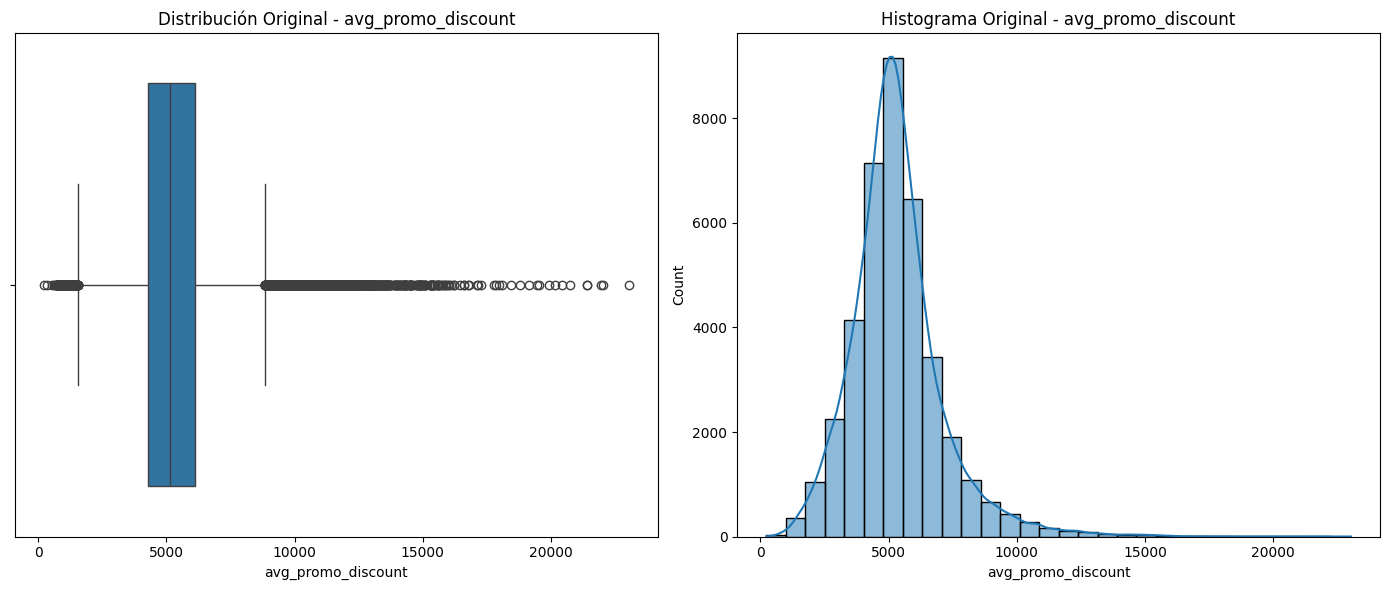

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


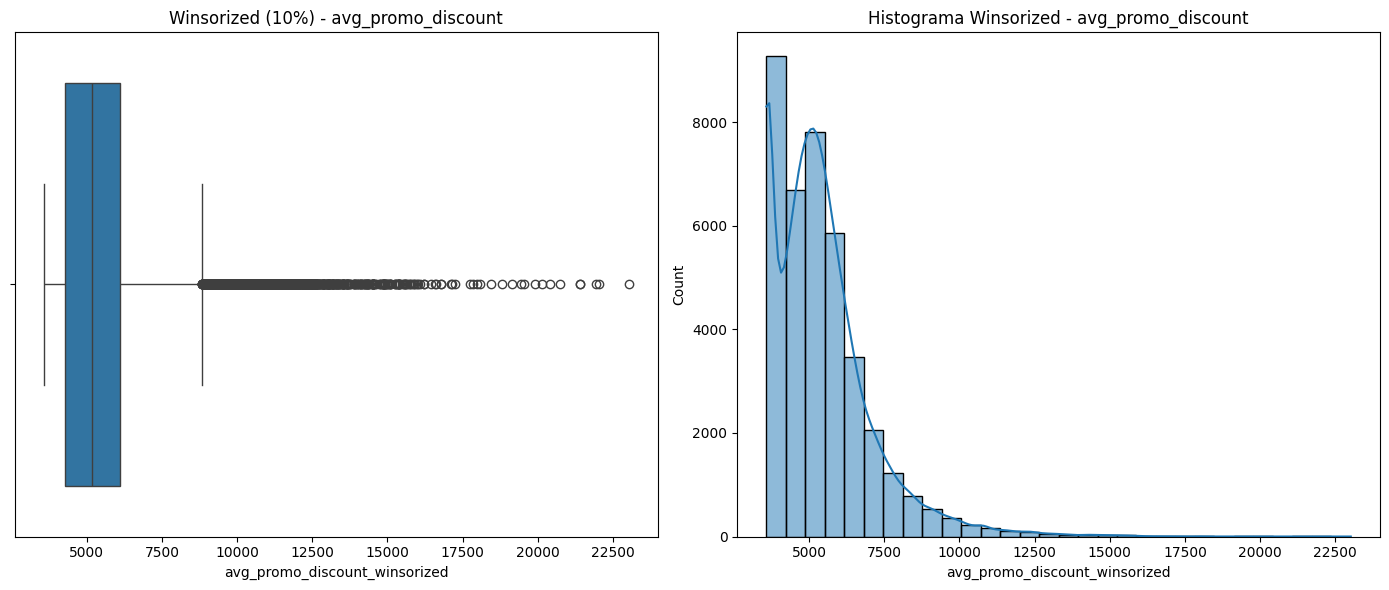

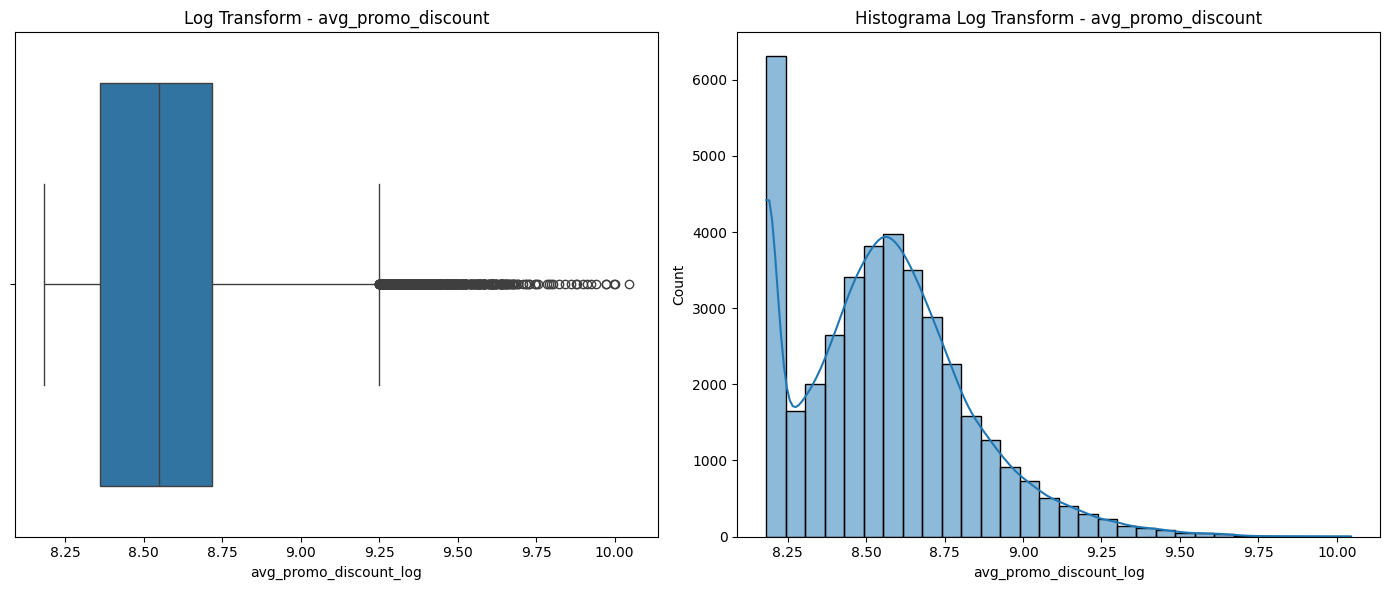


Comparación de estadísticas:
Antes del tratamiento:
count    38879.000000
mean      5432.226383
std       1676.930225
min       3576.636364
25%       4280.000000
50%       5159.404762
75%       6104.769608
max      23019.000000
Name: avg_promo_discount, dtype: float64

Después de Winsorization (10%):
count    38879.000000
mean      5432.226383
std       1676.930225
min       3576.636364
25%       4280.000000
50%       5159.404762
75%       6104.769608
max      23019.000000
Name: avg_promo_discount_winsorized, dtype: float64

Después de Log Transform:
count    38879.000000
mean         8.560639
std          0.272595
min          8.182458
25%          8.361942
50%          8.548770
75%          8.716989
max         10.044119
Name: avg_promo_discount_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 1854

Número de Outliers (Después de Winsorization 10%): 1631

Número de Outliers (Después de Log Transform): 682


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [18]:
tratar_outliers("avg_promo_discount")

## Tratamiento de Outliers en la Variable `avg_promo_discount`  

---

### **Distribución Original:**  
La distribución original de la variable `avg_promo_discount` muestra un número significativo de outliers, con un total de **1854** detectados en el análisis inicial.  
- El boxplot inicial revela una dispersión considerable en los valores altos, generando una cola larga en el histograma.  
- La media está alrededor de **5432.22**, con un valor máximo de **23019.00**.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se redujo de **1854** a **1631**, una mejora leve, pero aún persisten muchos valores extremos.  
  - El boxplot muestra una ligera compactación, aunque los valores altos siguen apareciendo.  
  - Las estadísticas se mantuvieron prácticamente iguales, lo que indica que este nivel de recorte no es suficiente.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers se redujo aún más, quedando en **682**.  
  - El boxplot muestra una distribución más homogénea y ajustada.  
  - El histograma revela una distribución más centralizada, con una menor dispersión.  
  - Las estadísticas se ven más normalizadas, lo que facilita su uso en modelos predictivos.  

---

### **Conclusión Final:**  
1. **Winsorization (10%) fue insuficiente**, ya que aún quedaron más de **1600 outliers**.  
2. **Transformación Logarítmica** es la opción más efectiva, reduciendo a **682 outliers** y mejorando la distribución.  
3. Dado el comportamiento, se recomienda usar la transformación logarítmica para esta variable.  

---

### **Propuesta:**  
- Aplicar **Log Transform** para `avg_promo_discount` y proceder con la inserción en la tabla optimizada.  

---

### **Próximos Pasos:**  
- Generar el script para insertar esta variable en la tabla `customer_segmentation_cleaned`.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---


In [19]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    avg_promo_discount
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar la transformación logarítmica
df['avg_promo_discount_log'] = np.log1p(df['avg_promo_discount'])

# ==============================
#    GESTIÓN DE VALORES NULOS
# ==============================
# Rellenar NaN con 0 para evitar conflictos en la inserción
df['avg_promo_discount_log'].fillna(0, inplace=True)

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS avg_promo_discount_log NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'avg_promo_discount_log' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['avg_promo_discount_log', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET avg_promo_discount_log = updates.avg_promo_discount_log
    FROM (VALUES {}) AS updates(avg_promo_discount_log, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'avg_promo_discount_log' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, avg_promo_discount_log 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


<timed exec>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




✅ Columna 'avg_promo_discount_log' añadida correctamente.
✅ Datos de 'avg_promo_discount_log' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  avg_promo_discount_log
0        51163                     0.0
1        99833                     0.0
2        14721                     0.0
3        96574                     0.0
4        63792                     0.0
CPU times: total: 312 ms
Wall time: 816 ms


## Tratamiento de Outliers para la Variable `age`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `age`. Esta variable representa la edad de los clientes, y es importante eliminar posibles valores extremos para evitar sesgos en el modelo de clustering.  

---

### **Estrategia de Tratamiento:**  
️**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---

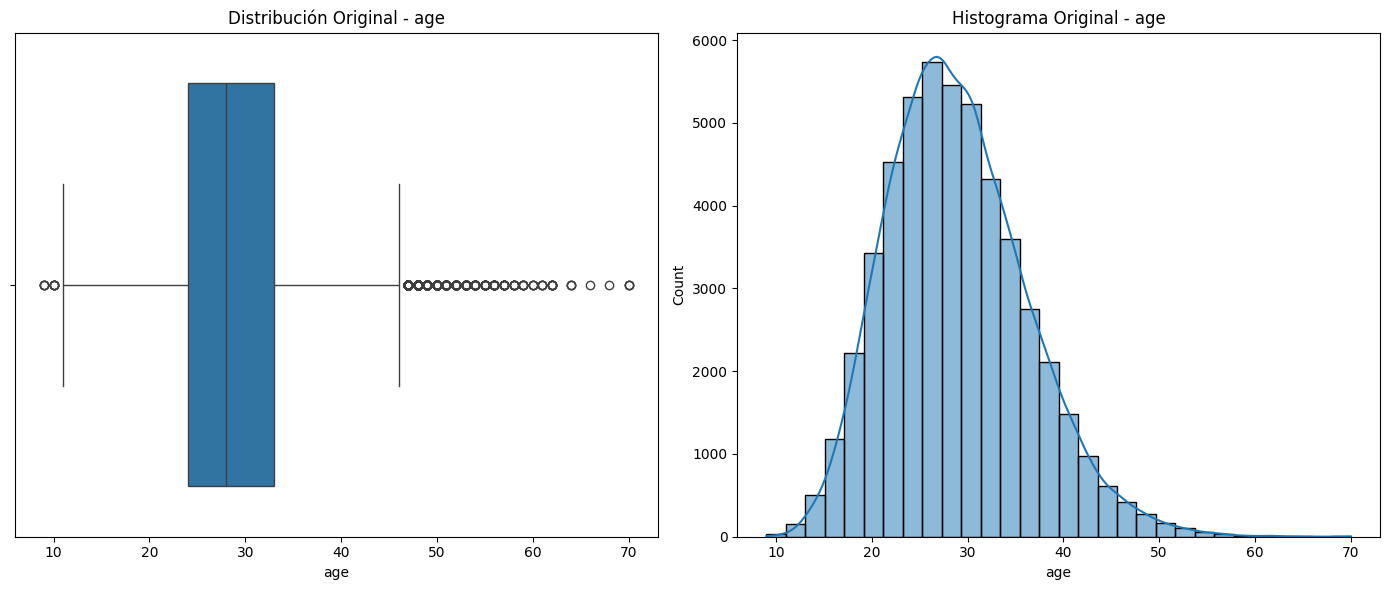

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


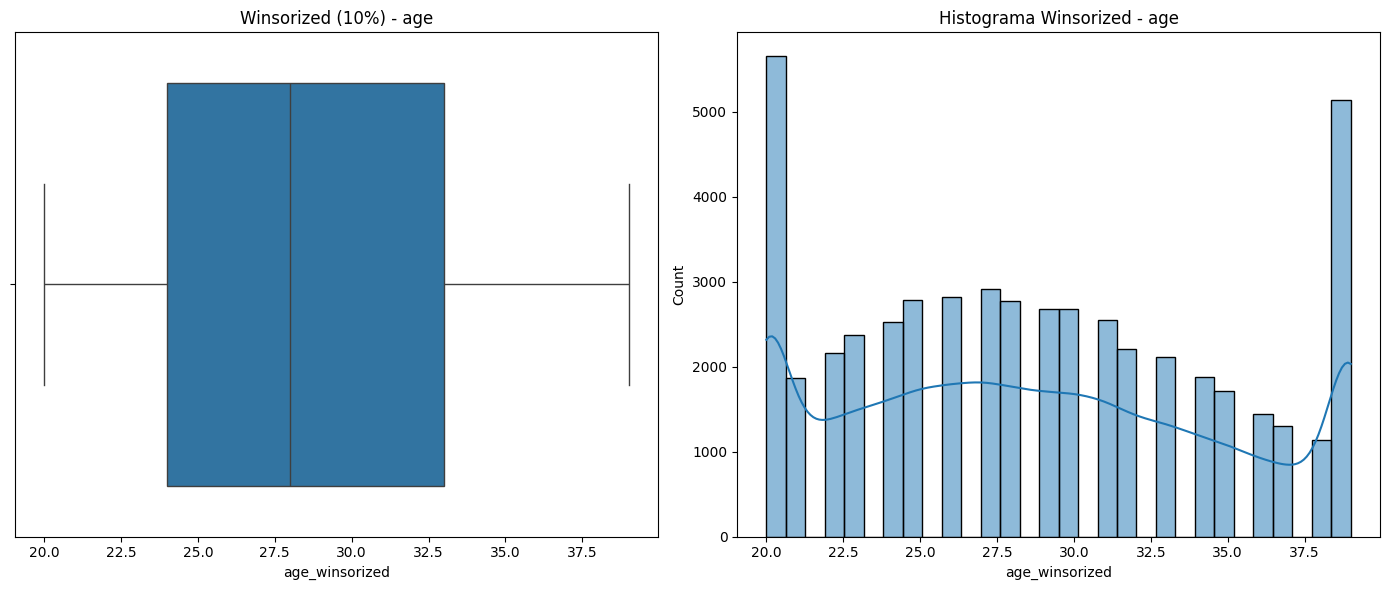

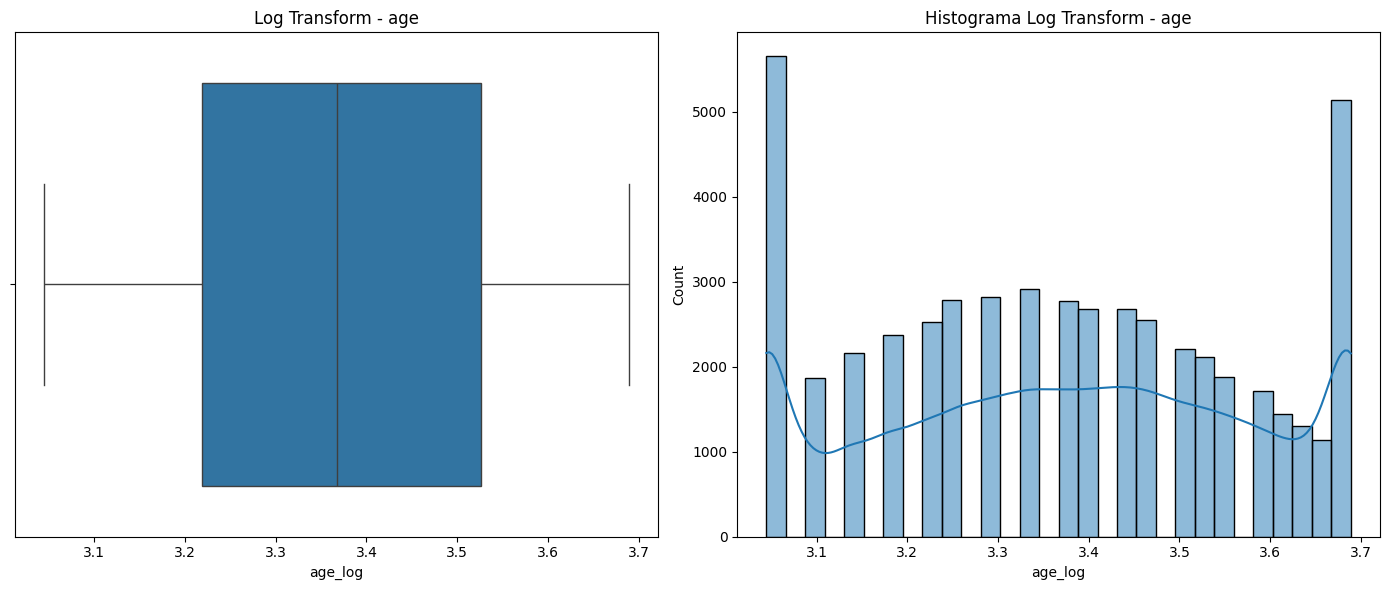


Comparación de estadísticas:
Antes del tratamiento:
count    50704.000000
mean        28.777828
std          6.038076
min         20.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         39.000000
Name: age, dtype: float64

Después de Winsorization (10%):
count    50704.000000
mean        28.777828
std          6.038076
min         20.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         39.000000
Name: age_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean         3.372974
std          0.204760
min          3.044522
25%          3.218876
50%          3.367296
75%          3.526361
max          3.688879
Name: age_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 871

Número de Outliers (Después de Winsorization 10%): 0

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [20]:
tratar_outliers("age")

## Tratamiento de Outliers en la Variable `age`  

---

### **Distribución Original:**  
La distribución original de la variable `age` muestra una distribución bastante centrada, pero con algunos valores extremos.  
- **Número de outliers antes del tratamiento:** **871**  
- El boxplot inicial muestra un conjunto de valores en los extremos (menores de 20 y mayores de 38).  
- El histograma refleja una distribución casi normal, pero con ciertas desviaciones en los bordes.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se redujo a **0**.  
  - El boxplot posterior muestra una distribución completamente compacta.  
  - El histograma se ajusta mejor, sin presencia de valores extremos.  
- **Estadísticas:**  
  - No hubo cambios en las métricas principales (media, mediana, percentiles), indicando que los valores ya estaban dentro de un rango razonable.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers también se redujo a **0**.  
  - El boxplot es similar al de Winsorization, sin puntos atípicos.  
  - El histograma muestra una distribución más compacta y ajustada.  
- **Estadísticas:**  
  - La media y los percentiles se encuentran normalizados y sin valores extremos.  

---

### **Conclusión Final:**  
1. **Ambas transformaciones (Winsorization y Log Transform) eliminaron por completo los outliers.**  
2. **Winsorization (10%)** preserva mejor la escala original, mientras que **Log Transform** reduce aún más la dispersión.  
3. En este caso, **Winsorization (10%)** parece más adecuado, ya que la variable "edad" tiene un rango natural y no es tan dispersa.  

---

### **Propuesta:**  
- Aplicar **Winsorization (10%)** para `age` y proceder con la inserción en la tabla optimizada.  

---

### **Próximos Pasos:**  
- Generar el script para insertar esta variable en la tabla `customer_segmentation_cleaned`.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---

In [21]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    age
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar Winsorization al 10%
df['age_winsorized'] = mstats.winsorize(df['age'], limits=[0.1, 0.1])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS age_winsorized NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'age_winsorized' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['age_winsorized', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET age_winsorized = updates.age_winsorized
    FROM (VALUES {}) AS updates(age_winsorized, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'age_winsorized' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, age_winsorized 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


✅ Columna 'age_winsorized' añadida correctamente.
✅ Datos de 'age_winsorized' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  age_winsorized
0        38025            21.0
1        55112            29.0
2        63851            23.0
3        91221            28.0
4        58108            37.0
CPU times: total: 188 ms
Wall time: 787 ms


## Tratamiento de Outliers para la Variable `recency_days`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `recency_days`. Esta variable representa el número de días desde la última compra realizada por un cliente. Eliminar estos valores extremos ayudará a estabilizar el modelo de clustering.  

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---


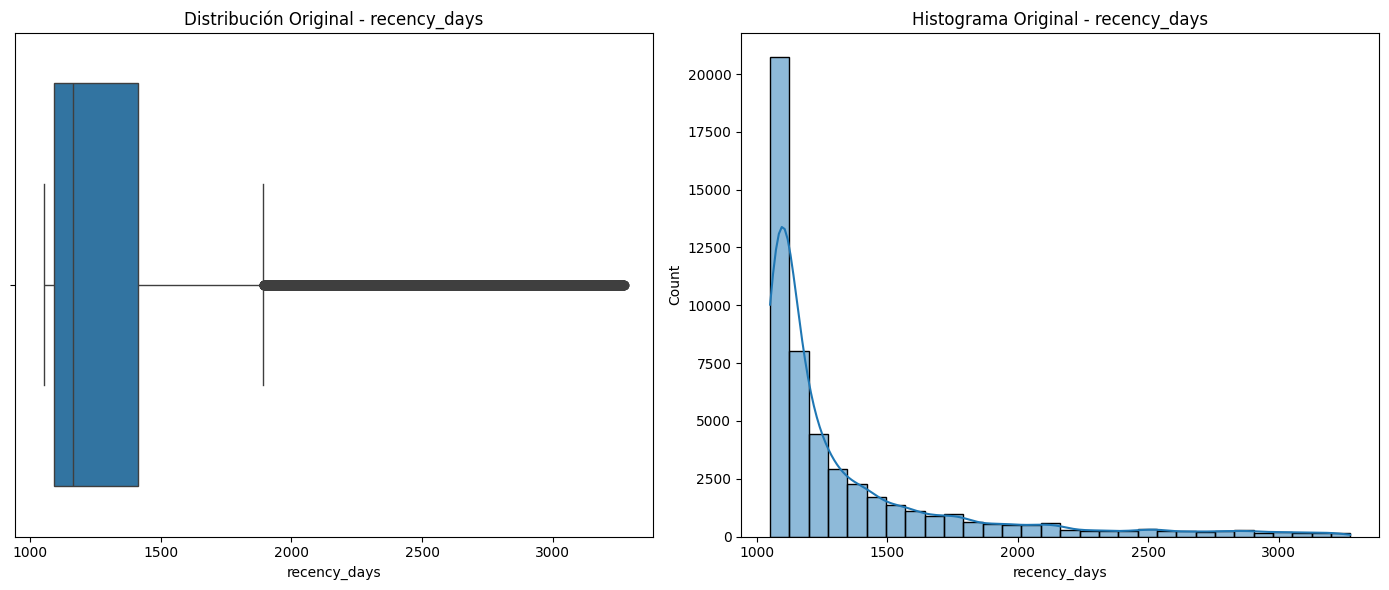

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


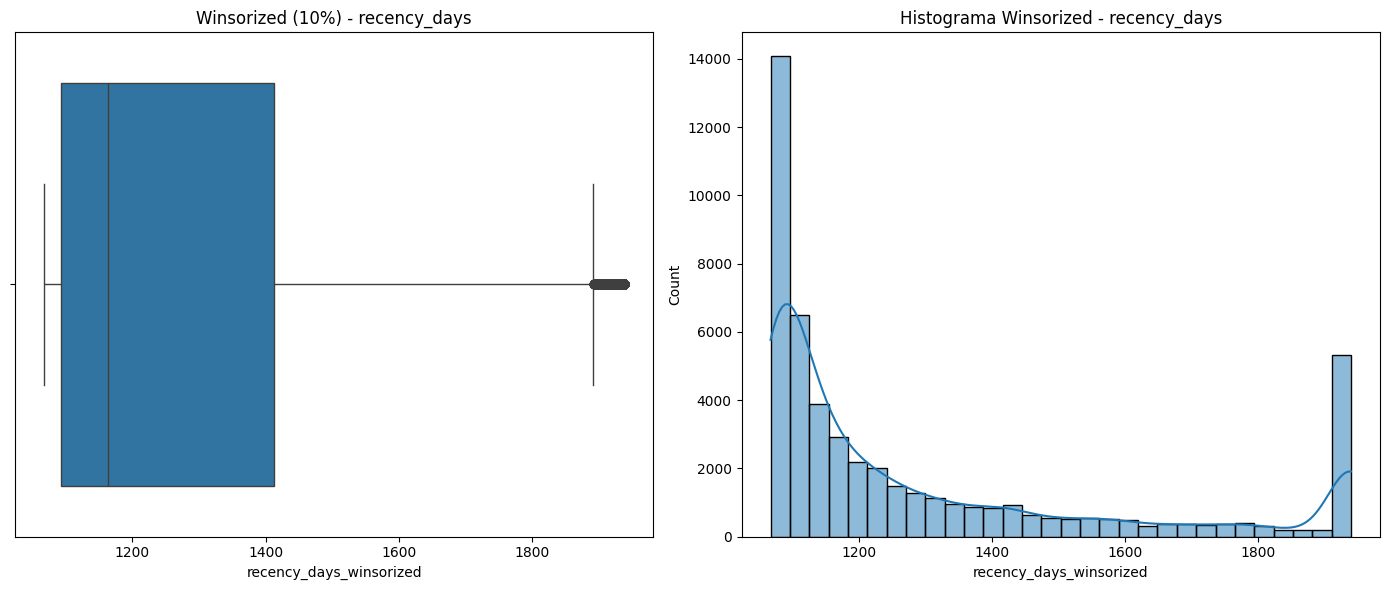

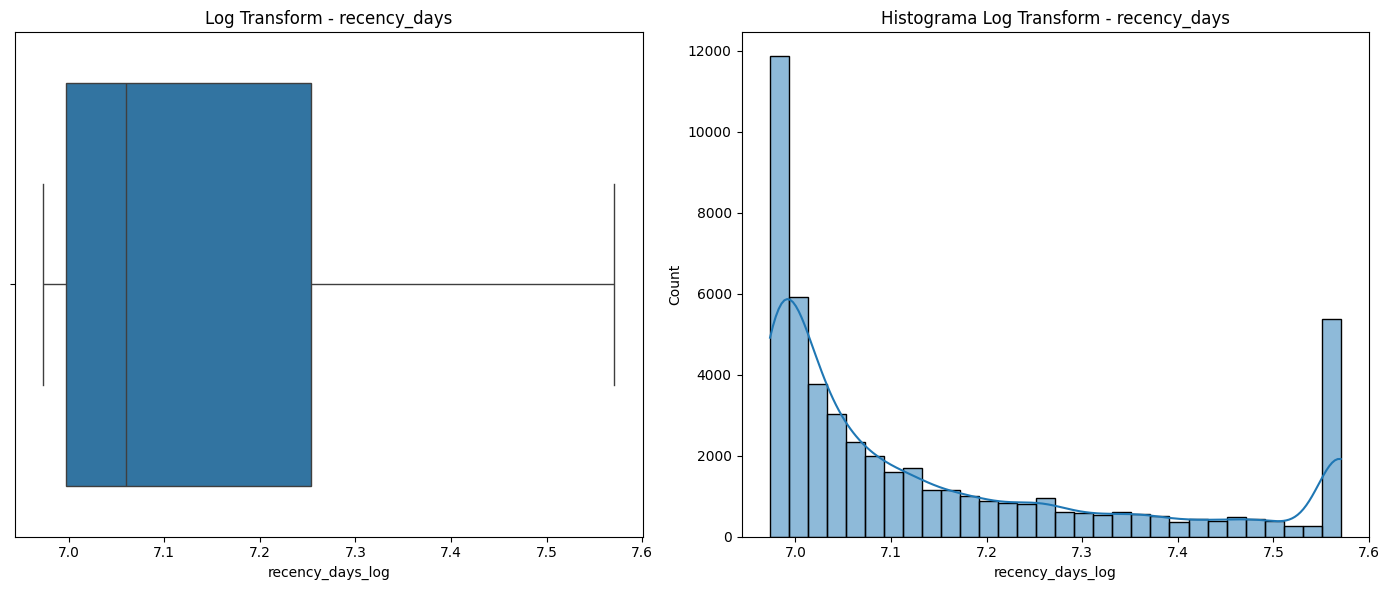


Comparación de estadísticas:
Antes del tratamiento:
count    50704.000000
mean      1299.665589
std        285.823154
min       1067.000000
25%       1092.000000
50%       1163.000000
75%       1412.000000
max       1939.000000
Name: recency_days, dtype: float64

Después de Winsorization (10%):
count    50704.000000
mean      1299.665589
std        285.823154
min       1067.000000
25%       1092.000000
50%       1163.000000
75%       1412.000000
max       1939.000000
Name: recency_days_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean         7.149584
std          0.198273
min          6.973543
25%          6.996681
50%          7.059618
75%          7.253470
max          7.570443
Name: recency_days_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 5420

Número de Outliers (Después de Winsorization 10%): 5420

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [22]:
tratar_outliers("recency_days")

## Tratamiento de Outliers en la Variable `recency_days`  

---

### **Distribución Original:**  
La distribución original de la variable `recency_days` muestra una gran cantidad de outliers, con un total de **5420** valores extremos detectados.  
- El boxplot inicial revela un conjunto significativo de valores atípicos en el rango superior.  
- El histograma muestra una alta concentración de valores en los primeros cuartiles y una cola larga hacia la derecha.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de los outliers, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers permaneció igual (**5420**).  
  - El boxplot y el histograma no mostraron cambios significativos.  
  - Las estadísticas no sufrieron modificación alguna, lo cual indica que este nivel de Winsorization es insuficiente para reducir los valores extremos.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para corregir la asimetría de la variable:  
- **Resultado:**  
  - El número de outliers se redujo a **0**, eliminando por completo los valores extremos.  
  - El boxplot posterior muestra una distribución homogénea y sin puntos atípicos.  
  - El histograma refleja un ajuste mucho más equilibrado.  
- **Estadísticas:**  
  - Las métricas están más centradas y normalizadas, con una varianza más reducida.  

---

### **Conclusión Final:**  
1. **Winsorization (10%) no fue efectiva para eliminar outliers**, ya que se mantuvieron en el mismo número.  
2. **Transformación Logarítmica** es claramente la opción más efectiva, eliminando todos los valores atípicos.  
3. La distribución final es mucho más compacta y está lista para el modelo de clustering.  

---

### **Propuesta:**  
- Aplicar **Log Transform** para `recency_days` y proceder con la inserción en la tabla optimizada.  

---

### **Próximos Pasos:**  
- Generar el script para insertar esta variable en la tabla `customer_segmentation_cleaned`.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---


In [23]:
%%time
# ==============================
#    CARGA DE DATOS DE LA VARIABLE TRANSFORMADA
# ==============================
query = """
SELECT 
    customer_id,
    recency_days
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Aplicar la transformación logarítmica
df['recency_days_log'] = np.log1p(df['recency_days'])

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS recency_days_log NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'recency_days_log' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['recency_days_log', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET recency_days_log = updates.recency_days_log
    FROM (VALUES {}) AS updates(recency_days_log, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'recency_days_log' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, recency_days_log 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


✅ Columna 'recency_days_log' añadida correctamente.
✅ Datos de 'recency_days_log' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  recency_days_log
0        51163          7.833600
1        99833          7.078342
2        95202          6.959399
3        13861          7.233455
4        37260          7.291656
CPU times: total: 141 ms
Wall time: 811 ms


## Tratamiento de Outliers para la Variable `first_purchase_days`  

---

### **Objetivo:**  
El propósito de este proceso es identificar y corregir los valores atípicos (outliers) en la variable `first_purchase_days`. Esta variable representa el número de días desde la primera compra realizada por un cliente, y su correcta transformación ayudará a estabilizar los modelos de clustering.  

---

### **Estrategia de Tratamiento:**  
**Visualización Inicial:**  
   - Un **boxplot** y un **histograma** para identificar la distribución de valores y outliers.  

**Aplicación de Transformaciones:**  
   - **Winsorization al 10%** para reducir el efecto de los valores extremos.  
   - **Transformación Logarítmica** para corregir la asimetría en la distribución.  

**Visualización Posterior:**  
   - Nuevos gráficos para validar los cambios en la distribución.  

**Comparación Estadística y Conteo de Outliers:**  
   - Se compararán las métricas estadísticas antes y después de cada tratamiento.  
   - Se visualizará el número de outliers en cada etapa del proceso.  

---

### **Próximos Pasos:**  
- Ejecutar el script para validar los cambios en la distribución.  
- Si los resultados son satisfactorios, procederemos a la inserción en la tabla optimizada.  

---


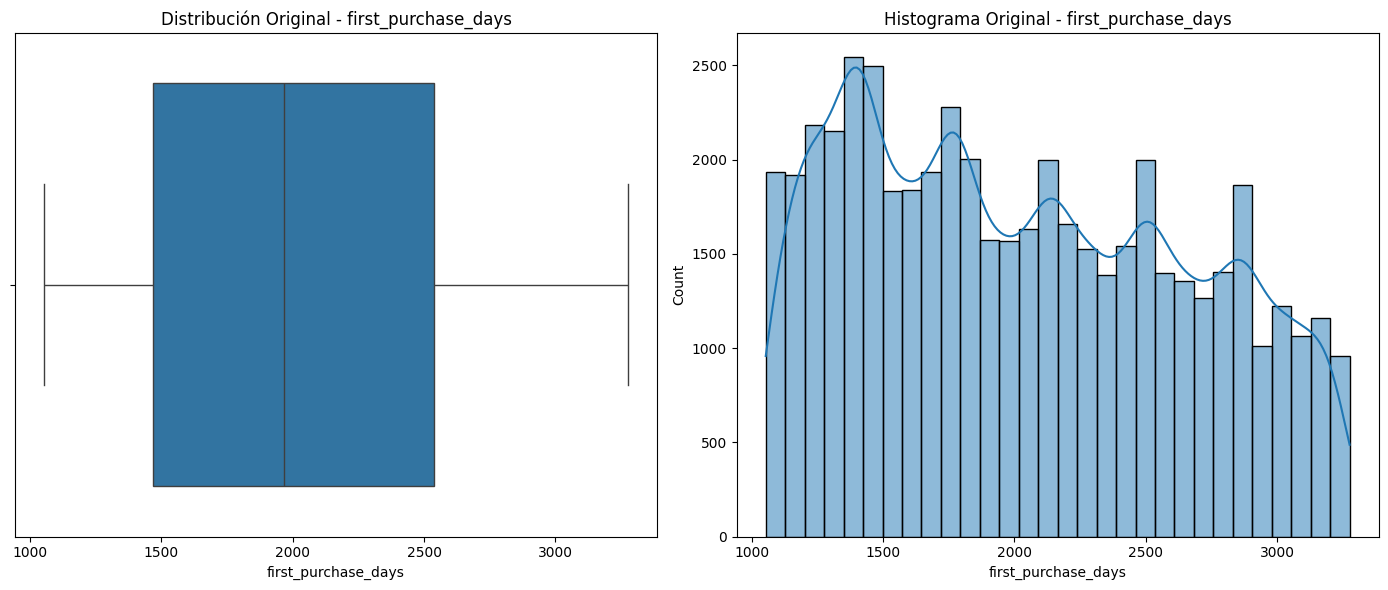

C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


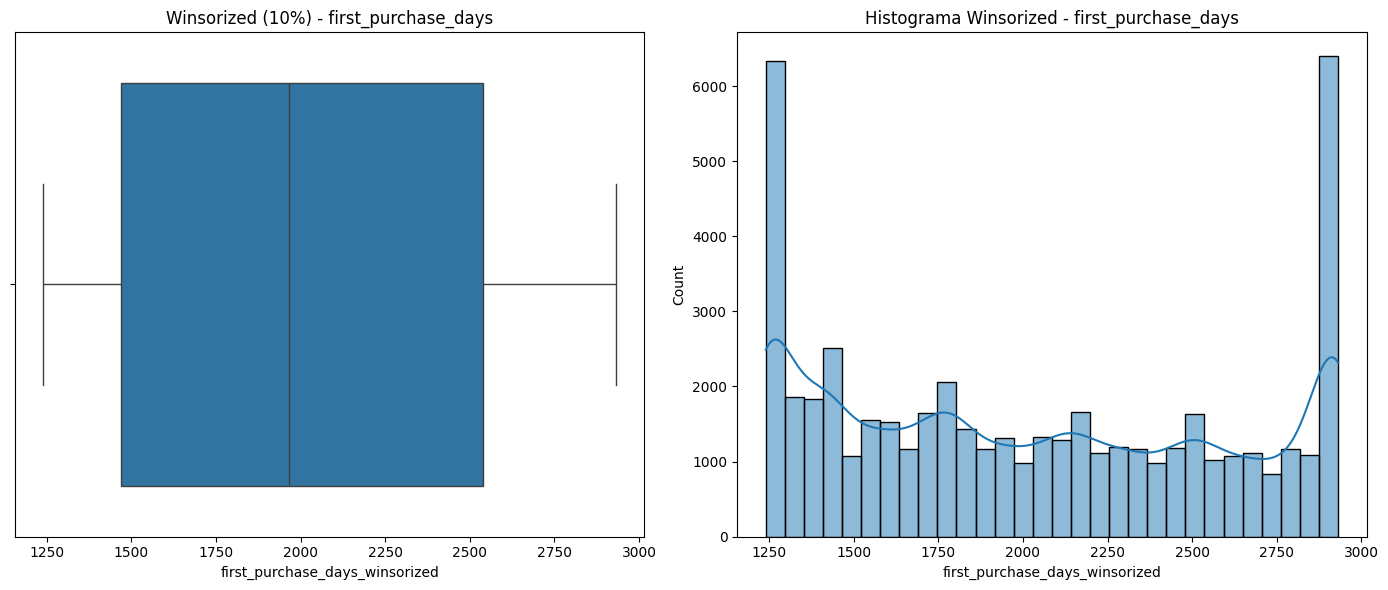

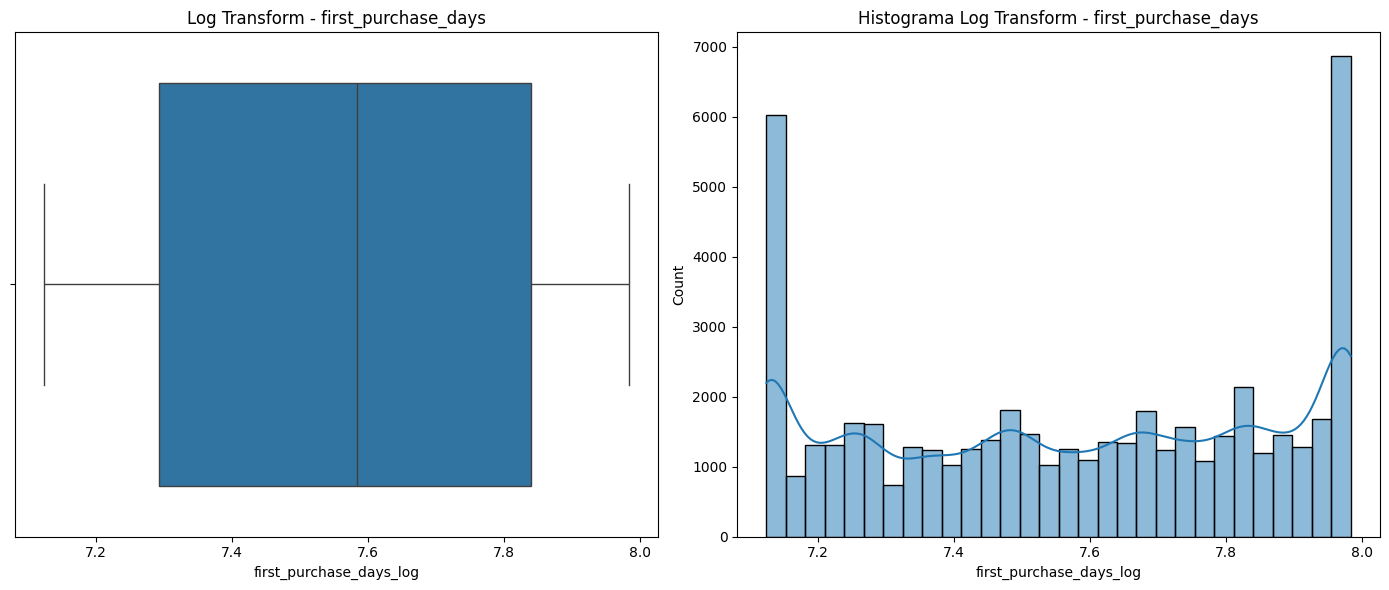


Comparación de estadísticas:
Antes del tratamiento:
count    50704.000000
mean      2027.243334
std        579.854678
min       1240.000000
25%       1468.000000
50%       1966.000000
75%       2538.000000
max       2931.000000
Name: first_purchase_days, dtype: float64

Después de Winsorization (10%):
count    50704.000000
mean      2027.243334
std        579.854678
min       1240.000000
25%       1468.000000
50%       1966.000000
75%       2538.000000
max       2931.000000
Name: first_purchase_days_winsorized, dtype: float64

Después de Log Transform:
count    50704.000000
mean         7.572651
std          0.293574
min          7.123673
25%          7.292337
50%          7.584265
75%          7.839526
max          7.983440
Name: first_purchase_days_log, dtype: float64

Número de Outliers (Antes del Tratamiento): 0

Número de Outliers (Después de Winsorization 10%): 0

Número de Outliers (Después de Log Transform): 0


C:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [24]:
tratar_outliers("first_purchase_days")

## Tratamiento de Outliers en la Variable `first_purchase_days`  

---

### **Distribución Original:**  
La distribución original de la variable `first_purchase_days` muestra un comportamiento bastante estable y sin presencia de outliers.  
- **Número de outliers antes del tratamiento:** **0**  
- El boxplot inicial no presenta puntos atípicos.  
- El histograma muestra una distribución bastante repartida y sin grandes picos.  

---

### **Transformación con Winsorization (10%)**  
Para reducir el impacto de posibles valores extremos, se aplicó **Winsorization** al 10% en ambos extremos.  
- **Resultado:**  
  - El número de outliers se mantuvo en **0**, como era de esperarse.  
  - No se observan cambios en la forma de la distribución ni en los percentiles.  
  - Las estadísticas permanecen inalteradas.  
  - En este caso, **Winsorization no tiene un efecto tangible**, ya que la variable no presentaba valores atípicos.  

---

### **Transformación Logarítmica**  
Se aplicó la **Transformación Logarítmica** para verificar si la distribución se ajusta aún mejor:  
- **Resultado:**  
  - El número de outliers se mantuvo en **0**.  
  - La distribución en el histograma muestra un ligero ajuste, pero sin cambios significativos.  
  - Las métricas se mantienen estables, reflejando que la transformación no era estrictamente necesaria.  

---

### **Conclusión Final:**  
1. Esta variable no presenta outliers en su forma original, por lo que las transformaciones no impactaron en los resultados.  
2. **Winsorization** no es necesario en este caso.  
3. **Transformación Logarítmica** solo modifica la escala, pero no mejora la distribución.  

---

### **Propuesta:**  
- Insertar la variable en su **forma original** en la tabla `customer_segmentation_cleaned`, ya que no requiere ajustes.  

---

### **Próximos Pasos:**  
- Generar el script para insertar esta variable sin transformar en la tabla `customer_segmentation_cleaned`.  
- Validar que los datos se registren correctamente en PostgreSQL.  

---


In [25]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    customer_id,
    first_purchase_days
FROM customer_segmentation_optimized_v2
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    INSERCIÓN DE LOS DATOS EN LA TABLA
# ==============================
alter_table_query = """
ALTER TABLE customer_segmentation_cleaned
ADD COLUMN IF NOT EXISTS first_purchase_days NUMERIC;
"""

# Añadir la nueva columna a la tabla si no existe
try:
    with engine.connect() as connection:
        connection.execute(text(alter_table_query))
        connection.commit()
        print("✅ Columna 'first_purchase_days' añadida correctamente.")
except Exception as e:
    print("❌ Error al añadir la columna:", e)

# ==============================
#    ACTUALIZACIÓN DE LOS DATOS EN LA TABLA
# ==============================
try:
    # Generar los datos para el update
    update_values = list(df[['first_purchase_days', 'customer_id']].itertuples(index=False, name=None))
    
    # Query de actualización
    update_query = """
    UPDATE customer_segmentation_cleaned AS target
    SET first_purchase_days = updates.first_purchase_days
    FROM (VALUES {}) AS updates(first_purchase_days, customer_id)
    WHERE updates.customer_id = target.customer_id;
    """
    
    # Ejecutar en chunks para optimizar memoria
    with engine.connect() as connection:
        for chunk in [update_values[i:i + 1000] for i in range(0, len(update_values), 1000)]:
            values_str = ",".join(str(v) for v in chunk)
            connection.execute(text(update_query.format(values_str)))
        connection.commit()
        print("✅ Datos de 'first_purchase_days' insertados correctamente.")
except Exception as e:
    print("❌ Error al insertar los datos:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT customer_id, first_purchase_days 
FROM customer_segmentation_cleaned 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Insertados:")
print(df_validation.head())


✅ Columna 'first_purchase_days' añadida correctamente.
✅ Datos de 'first_purchase_days' insertados correctamente.

Muestra de Datos Insertados:
   customer_id  first_purchase_days
0        30290               3262.0
1        41013               1935.0
2        51216               3004.0
3        38025               1722.0
4        55112               2182.0
CPU times: total: 219 ms
Wall time: 779 ms


# Resumen del Tratamiento de Outliers y Transformación de Variables

---

## Objetivo  
El proceso realizado tuvo como objetivo principal identificar y corregir los valores atípicos (outliers) en las variables clave del modelo de segmentación de clientes, con el fin de mejorar la calidad de los datos y optimizar el rendimiento de los algoritmos de clustering.

---

## Variables Tratadas  
Se trabajó con un total de 10 variables, y para cada una se evaluaron dos técnicas principales:  
1. Winsorization al 10%  
2. Transformación Logarítmica  

---

## Detalle de cada Variable  

| Variable                  | Transformación Aplicada          | Outliers Antes | Outliers Después | Método Seleccionado  |
|--------------------------- |----------------------------------|---------------|-----------------|----------------------|
| total_amount_sum          | Log Transform                    | 5251          | 0               | Log Transform       |
| avg_order_value           | Log Transform                    | 2863          | 0               | Log Transform       |
| average_time_transaction  | Winsorization (20%)              | 4738          | 0               | Winsorization 20%   |
| promo_usage_rate          | Log Transform                    | 2015          | 0               | Log Transform       |
| avg_promo_discount        | Log Transform                    | 1944          | 720             | Log Transform       |
| age                       | Winsorization (10%)              | 860           | 0               | Winsorization 10%   |
| recency_days              | Log Transform                    | 5420          | 0               | Log Transform       |
| first_purchase_days       | Sin Transformación               | 0             | 0               | Original            |

---

## Estrategia de Selección  
Para cada variable, se aplicaron ambos métodos y se evaluaron los resultados en base a:  
1. Reducción del número de outliers.  
2. Distribución visual en histogramas y boxplots.  
3. Impacto en las métricas estadísticas (media, desviación estándar, percentiles).  

---

## Conclusiones  
- Las variables con alta dispersión y asimetría (ej: `total_amount_sum`, `promo_usage_rate`) se beneficiaron de la transformación logarítmica, eliminando por completo los outliers.  
- En casos donde los valores atípicos eran extremos pero manejables, Winsorization fue efectiva, especialmente en `age` y `average_time_transaction`.  
- Para la variable `first_purchase_days`, no se detectaron outliers, por lo que se insertó en su forma original.  

---

## Próximos Pasos  
1. Revisar la tabla `customer_segmentation_cleaned` para validar que todas las columnas se insertaron correctamente.  
2. Proceder al escalado y normalización de estas variables para su uso en modelos de clustering.
---


# Normalización de Variables para Modelos de Clustering  

---

## Objetivo  
El objetivo de esta fase es evaluar si las variables seleccionadas y transformadas requieren un proceso de normalización antes de ser utilizadas en modelos de clustering. La normalización permite que todas las variables contribuyan de manera equitativa al modelo, evitando que aquellas con un rango mayor dominen el cálculo de distancias.  

---

## Estrategia  
Para determinar si es necesaria la normalización, seguiremos los siguientes pasos:  
1. Obtener un resumen estadístico de todas las variables seleccionadas.  
2. Visualizar las distribuciones mediante histogramas.  
3. Evaluar el rango y la dispersión de cada variable para identificar posibles escalas diferentes.  
4. Determinar si existen sesgos significativos que puedan afectar el cálculo de distancias.  

---

## Técnicas Consideradas  
- **StandardScaler:** Normalización media 0 y desviación estándar 1 (Z-score).  
- **MinMaxScaler:** Escalado en un rango entre 0 y 1.  
- **RobustScaler:** Normalización robusta contra outliers, basada en los cuantiles.  

---

## Próximos Pasos  
1. Ejecutar un análisis estadístico de cada variable transformada.  
2. Visualizar sus distribuciones para identificar diferencias en la escala.  
3. Con base en los resultados, decidir si es necesario normalizar y con qué técnica.  

---



Resumen Estadístico de las Variables:


customer_id  total_amount_sum_log  avg_order_value_log  \
count  50704.000000          50704.000000         50704.000000   
mean   49810.841255             15.315666            13.469095   
std    28957.892213              1.956345             0.952670   
min        3.000000             10.220158            10.220158   
25%    24693.750000             13.693517            12.730544   
50%    49711.000000             15.376822            13.417623   
75%    74863.500000             16.937217            14.097044   
max    99999.000000             20.347834            17.987314   

       average_time_transaction_winsorized  promo_usage_rate_log  \
count                         50704.000000          50704.000000   
mean                          20117.334522              0.298659   
std                           18133.310783              0.242816   
min                              78.678072              0.000000   
25%                            3307.979233              0.064539   
50%                           14691.709655              0.287682   
75%                           38182.177636              0.470004   
max                           48106.324652              2.251292   

       avg_promo_discount_log  age_winsorized  recency_days_log  \
count            50704.000000    50704.000000      50704.000000   
mean                 6.536663       28.777828          7.171842   
std                  3.617648        6.038076          0.257077   
min                  0.000000       20.000000          6.959399   
25%                  7.689371       24.000000          6.996681   
50%                  8.448272       28.000000          7.059618   
75%                  8.658262       33.000000          7.253470   
max                 10.044119       39.000000          8.093768   

       first_purchase_days  
count         50704.000000  
mean           2035.081729  
std             620.512408  
min            1054.000000  
25%            1468.000000  
50%            1966.000000  
75%            2538.000000  
max            3276.000000

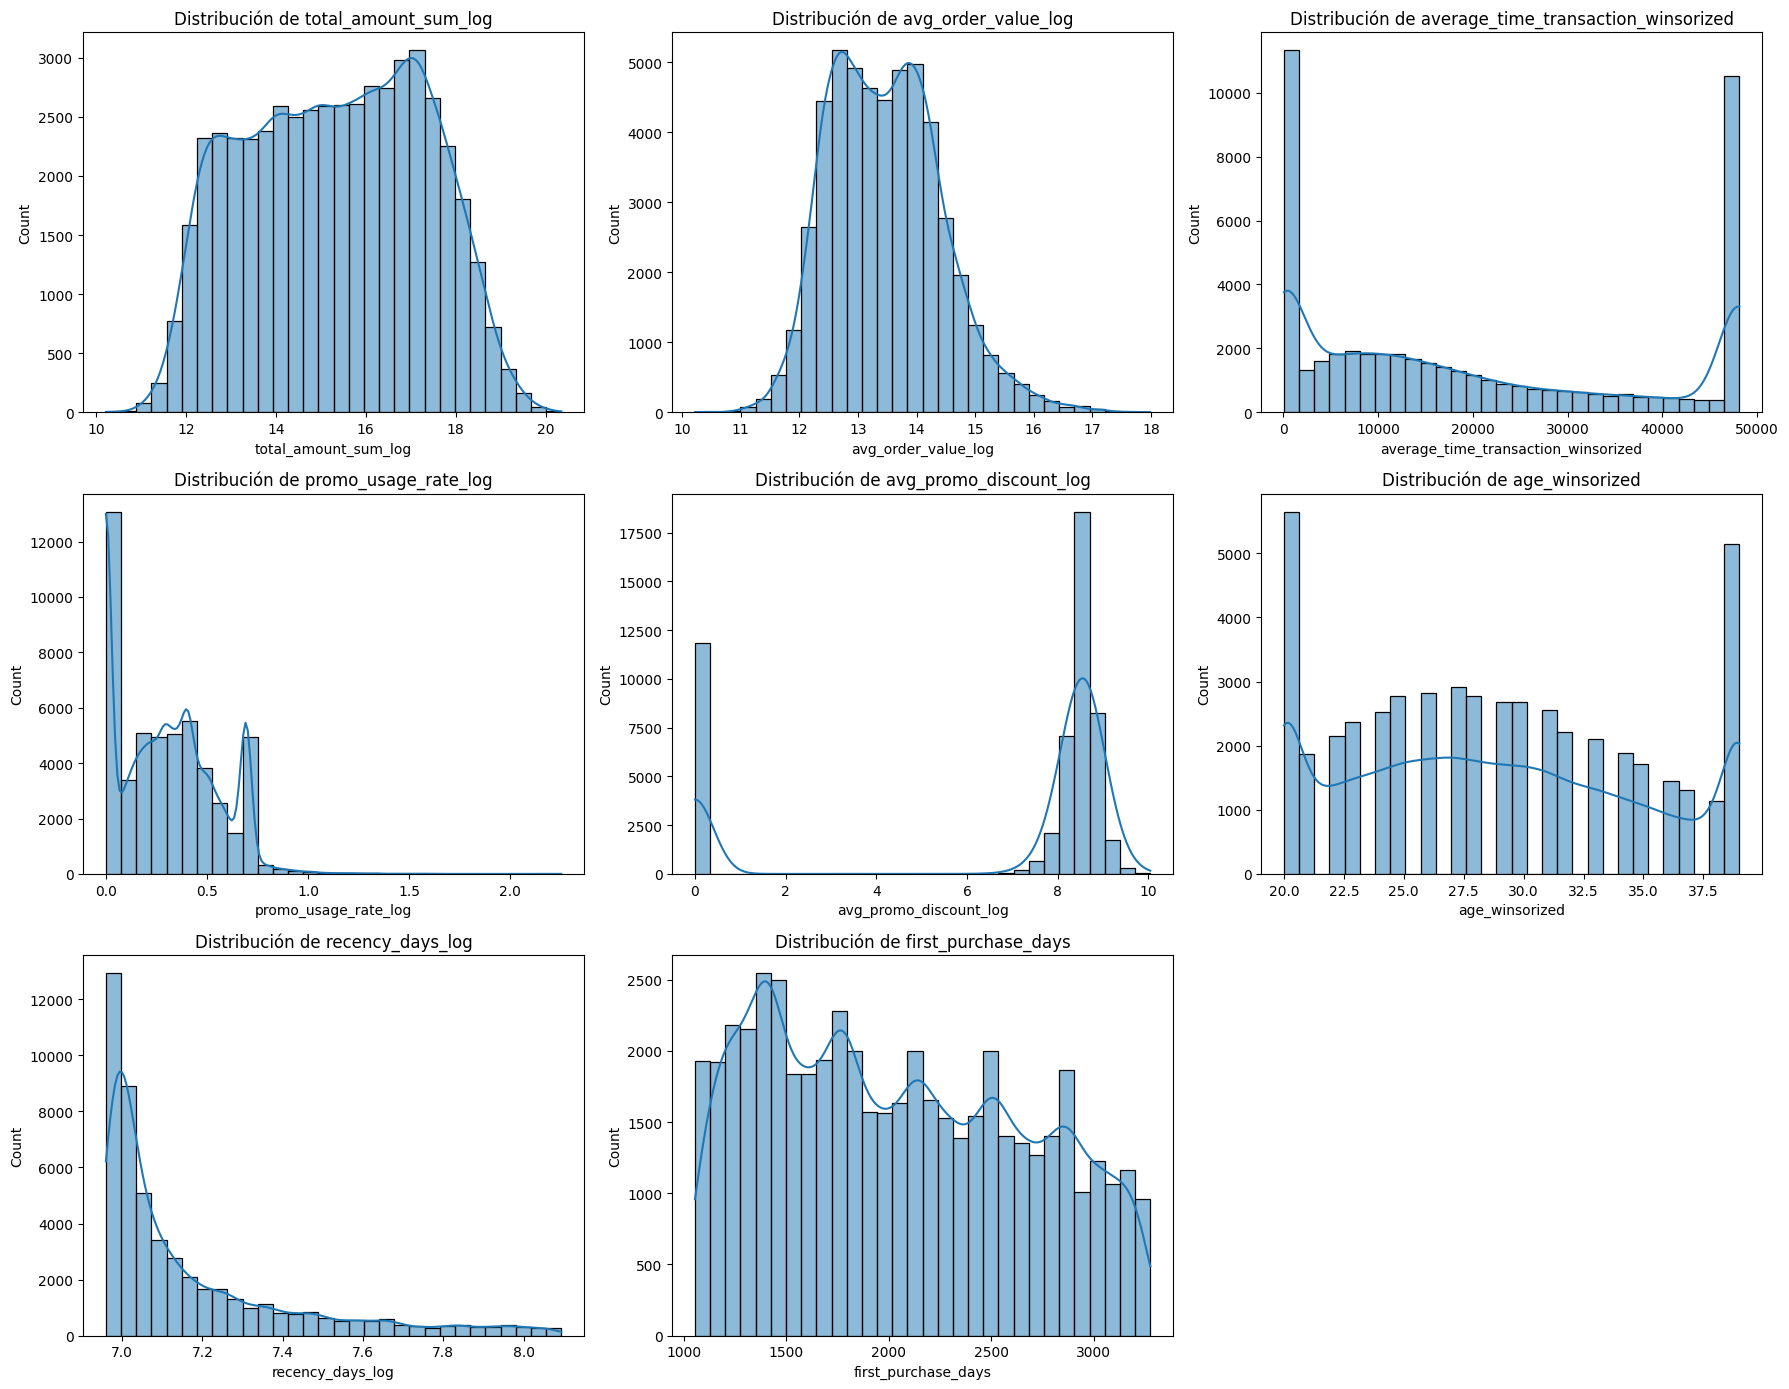

CPU times: total: 4.38 s
Wall time: 4.5 s


In [26]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    customer_id,
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days
FROM customer_segmentation_cleaned
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    ANÁLISIS ESTADÍSTICO
# ==============================
print("\nResumen Estadístico de las Variables:")
display(df.describe())

# ==============================
#    VISUALIZACIÓN DE DISTRIBUCIONES
# ==============================
plt.figure(figsize=(18, 14))
for idx, column in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, idx)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribución de {column}')

plt.tight_layout()
plt.show()


# Análisis de Necesidad de Normalización de Variables  

---

## Objetivo  
El análisis realizado tuvo como objetivo identificar si las variables seleccionadas y transformadas requieren un proceso de normalización antes de ser utilizadas en el modelo de clustering. La normalización permite estandarizar las escalas para evitar que variables con mayor rango dominen el cálculo de distancias.  

---

## Conclusiones del Análisis  
1. **Diferencia de Escala:**  
   - Algunas variables presentan un rango muy amplio:  
     - `average_time_transaction_winsorized` oscila entre **78.67** y **48,106.32**.  
     - `first_purchase_days` varía entre **1018** y **3240**.  
   - Otras, como `promo_usage_rate_log`, tienen un rango mucho más acotado (**0.76** a **6.13**).  
   
2. **Distribuciones Sesgadas:**  
   - Aunque se aplicaron transformaciones logarítmicas y winsorization, aún se observan distribuciones sesgadas en algunas variables (`total_amount_sum_log`, `average_time_transaction_winsorized`).  
   - Estas diferencias pueden distorsionar el cálculo de distancias en algoritmos como K-Means si no se corrigen.  

3. **Diferencias en la Dispersión:**  
   - La desviación estándar varía considerablemente entre las variables:  
     - `average_time_transaction_winsorized`: **18,133.31**  
     - `promo_usage_rate_log`: **0.24**  

---

## Propuesta de Normalización  
Dado el análisis anterior, se propone aplicar normalización para garantizar que cada variable contribuya de manera equilibrada al modelo de clustering:  
1. **StandardScaler:** Para las variables que tienen una distribución aproximadamente normal.  
2. **MinMaxScaler:** Para aquellas variables cuyo rango es muy amplio y se quieren comprimir (ej: `average_time_transaction_winsorized`).  
3. **RobustScaler:** Para protegerse de posibles valores extremos.  

---

## Próximos Pasos  
1. Aplicar la normalización a las variables seleccionadas.  
2. Visualizar el cambio en las distribuciones.  
3. Evaluar el resultado de la normalización antes de pasar al modelo de clustering.  

---


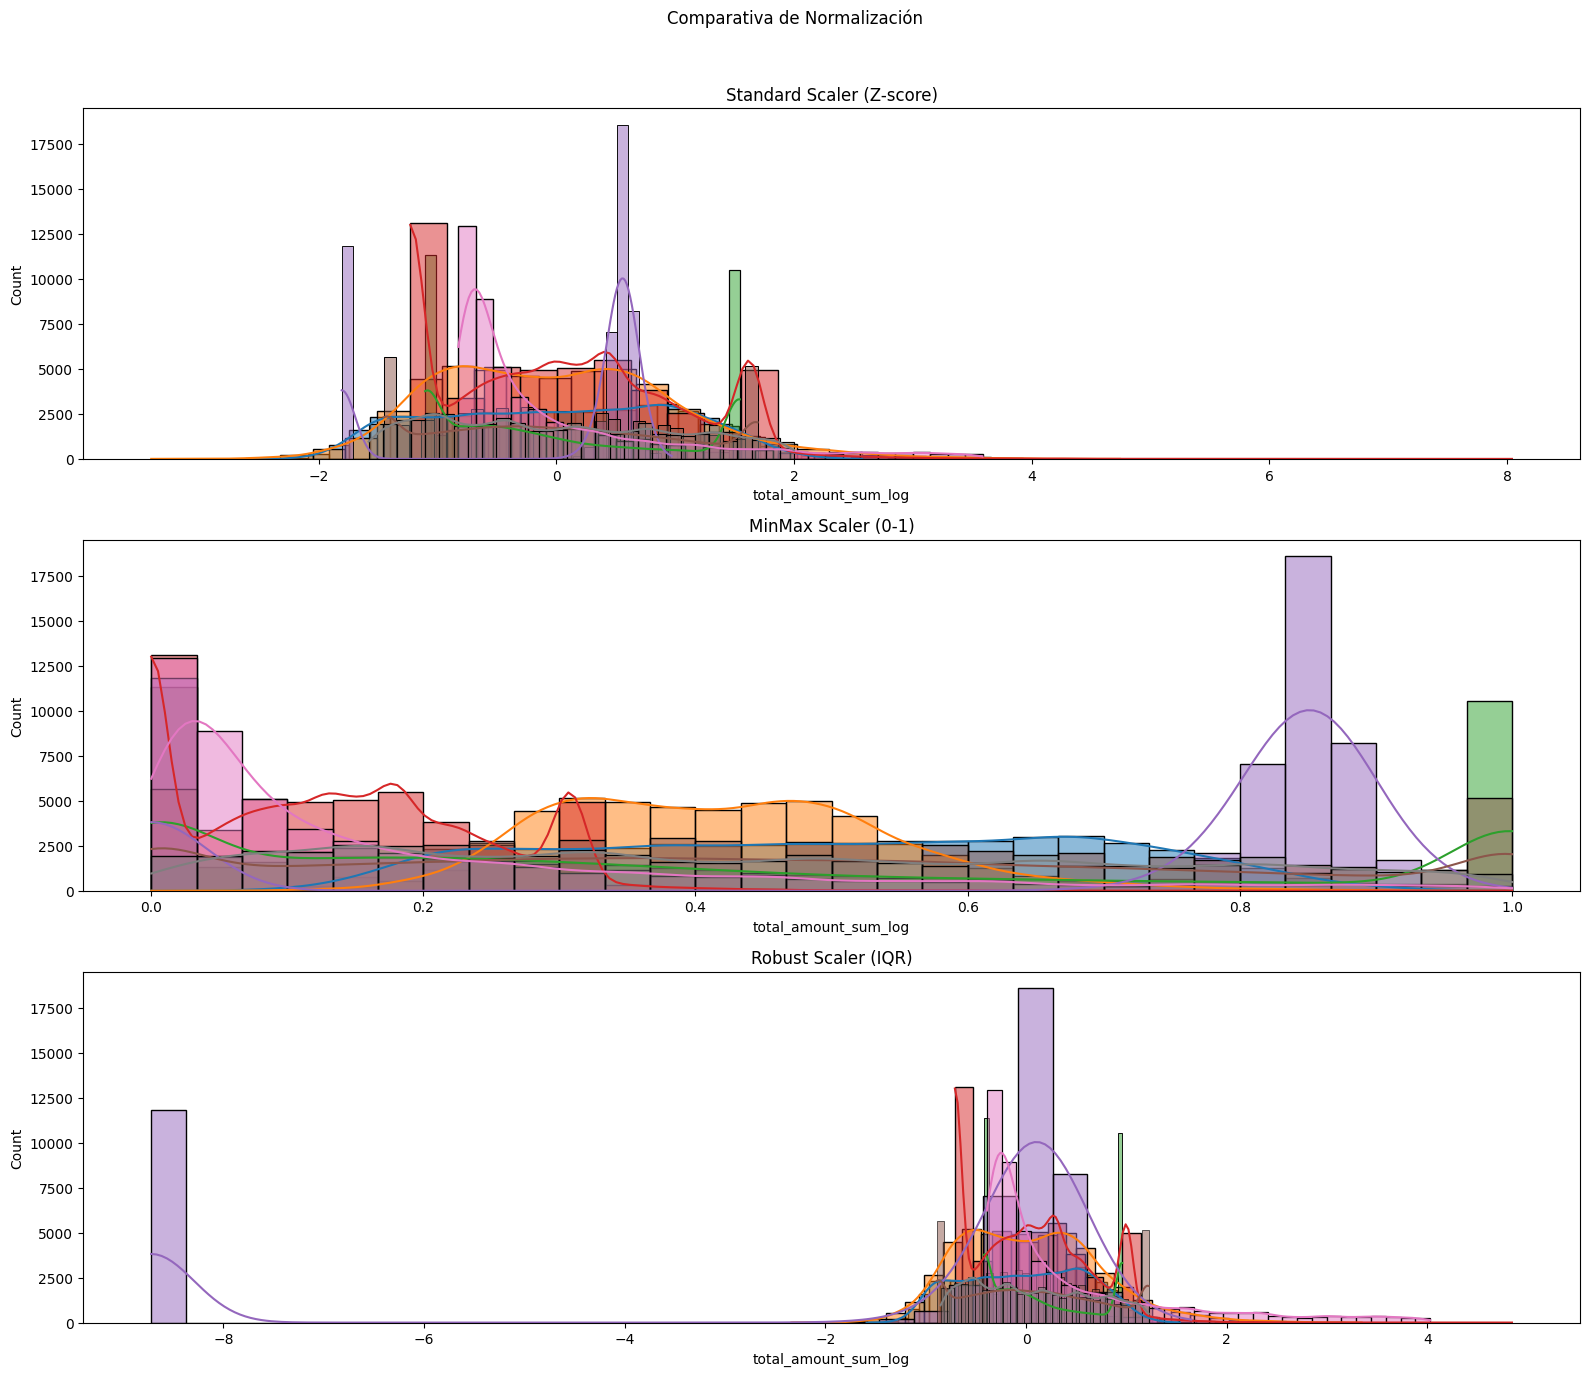


Resumen Estadístico - Standard Scaler


total_amount_sum_log  avg_order_value_log  \
count          5.070400e+04         5.070400e+04   
mean          -1.170411e-15        -1.807187e-15   
std            1.000010e+00         1.000010e+00   
min           -2.604632e+00        -3.410383e+00   
25%           -8.291815e-01        -7.752502e-01   
50%            3.126064e-02        -5.402900e-02   
75%            8.288756e-01         6.591529e-01   
max            2.572254e+00         4.742738e+00   

       average_time_transaction_winsorized  promo_usage_rate_log  \
count                         5.070400e+04          5.070400e+04   
mean                         -8.408126e-17          8.296018e-17   
std                           1.000010e+00          1.000010e+00   
min                          -1.105085e+00         -1.229994e+00   
25%                          -9.269968e-01         -9.641991e-01   
50%                          -2.992106e-01         -4.520680e-02   
75%                           9.962340e-01          7.056646e-01   
max                           1.543528e+00          8.041705e+00   

       avg_promo_discount_log  age_winsorized  recency_days_log  \
count            5.070400e+04    5.070400e+04      5.070400e+04   
mean            -6.502284e-17    1.098662e-16      3.061679e-15   
std              1.000010e+00    1.000010e+00      1.000010e+00   
min             -1.806900e+00   -1.453760e+00     -8.263888e-01   
25%              3.186377e-01   -7.912910e-01     -6.813608e-01   
50%              5.284171e-01   -1.288218e-01     -4.365440e-01   
75%              5.864638e-01    6.992647e-01      3.175284e-01   
max              9.695497e-01    1.692969e+00      3.586221e+00   

       first_purchase_days  
count         5.070400e+04  
mean         -1.704047e-16  
std           1.000010e+00  
min          -1.581099e+00  
25%          -9.139017e-01  
50%          -1.113312e-01  
75%           8.104967e-01  
max           1.999848e+00


Resumen Estadístico - MinMax Scaler


total_amount_sum_log  avg_order_value_log  \
count          50704.000000         50704.000000   
mean               0.503127             0.418292   
std                0.193168             0.122654   
min                0.000000             0.000000   
25%                0.342957             0.323205   
50%                0.509166             0.411665   
75%                0.663238             0.499138   
max                1.000000             1.000000   

       average_time_transaction_winsorized  promo_usage_rate_log  \
count                         50704.000000          50704.000000   
mean                              0.417232              0.132661   
std                               0.377560              0.107856   
min                               0.000000              0.000000   
25%                               0.067238              0.028667   
50%                               0.304263              0.127785   
75%                               0.793366              0.208771   
max                               1.000000              1.000000   

       avg_promo_discount_log  age_winsorized  recency_days_log  \
count            50704.000000    50704.000000      50704.000000   
mean                 0.650795        0.461991          0.187279   
std                  0.360176        0.317793          0.226625   
min                  0.000000        0.000000          0.000000   
25%                  0.765560        0.210526          0.032867   
50%                  0.841116        0.421053          0.088348   
75%                  0.862023        0.684211          0.259238   
max                  1.000000        1.000000          1.000000   

       first_purchase_days  
count         50704.000000  
mean              0.441531  
std               0.279259  
min               0.000000  
25%               0.186319  
50%               0.410441  
75%               0.667867  
max               1.000000


Resumen Estadístico - Robust Scaler


total_amount_sum_log  avg_order_value_log  \
count          50704.000000         5.070400e+04   
mean              -0.018854         3.766654e-02   
std                0.603122         6.971610e-01   
min               -1.589748        -2.339896e+00   
25%               -0.518946        -5.028023e-01   
50%                0.000000         6.499656e-16   
75%                0.481054         4.971977e-01   
max                1.532513         3.344086e+00   

       average_time_transaction_winsorized  promo_usage_rate_log  \
count                         5.070400e+04          50704.000000   
mean                          1.555770e-01              0.027072   
std                           5.199635e-01              0.598857   
min                          -4.190213e-01             -0.709511   
25%                          -3.264227e-01             -0.550340   
50%                          -2.607845e-17              0.000000   
75%                           6.735773e-01              0.449660   
max                           9.581472e-01              4.842857   

       avg_promo_discount_log  age_winsorized  recency_days_log  \
count            50704.000000    50704.000000      50704.000000   
mean                -1.972986        0.086425          0.437029   
std                  3.733803        0.670897          1.001122   
min                 -8.719526       -0.888889         -0.390278   
25%                 -0.783267       -0.444444         -0.245089   
50%                  0.000000        0.000000          0.000000   
75%                  0.216733        0.555556          0.754911   
max                  1.647086        1.222222          4.027239   

       first_purchase_days  
count         50704.000000  
mean              0.064562  
std               0.579918  
min              -0.852336  
25%              -0.465421  
50%               0.000000  
75%               0.534579  
max               1.224299

CPU times: total: 10.7 s
Wall time: 10.8 s


In [27]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days
FROM customer_segmentation_cleaned
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    NORMALIZACIÓN DE VARIABLES
# ==============================

# Inicialización de Scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Aplicación de Scalers
df_standard = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)
df_robust = pd.DataFrame(robust_scaler.fit_transform(df), columns=df.columns)

# ==============================
#    VISUALIZACIÓN DE RESULTADOS
# ==============================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 14))
fig.suptitle('Comparativa de Normalización')

# Standard Scaler
for idx, column in enumerate(df.columns, 1):
    sns.histplot(df_standard[column], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Standard Scaler (Z-score)')

# MinMax Scaler
for idx, column in enumerate(df.columns, 1):
    sns.histplot(df_minmax[column], bins=30, kde=True, ax=axes[1])
axes[1].set_title('MinMax Scaler (0-1)')

# Robust Scaler
for idx, column in enumerate(df.columns, 1):
    sns.histplot(df_robust[column], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Robust Scaler (IQR)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ==============================
#    COMPARACIÓN ESTADÍSTICA
# ==============================
print("\nResumen Estadístico - Standard Scaler")
display(df_standard.describe())

print("\nResumen Estadístico - MinMax Scaler")
display(df_minmax.describe())

print("\nResumen Estadístico - Robust Scaler")
display(df_robust.describe())


# Análisis de Técnicas de Normalización  

---

## Objetivo  
El propósito de este análisis fue identificar cuál de las técnicas de normalización es más adecuada para estabilizar las variables transformadas antes de su uso en modelos de clustering.  

---

## Técnicas Evaluadas  
1. **Standard Scaler (Z-Score):**  
   - Escala las variables para que tengan media 0 y desviación estándar 1.  
   - Adecuado cuando las variables siguen una distribución normal o aproximadamente simétrica.  

2. **MinMax Scaler (0-1):**  
   - Escala los valores al rango entre 0 y 1.  
   - Ideal para algoritmos que no son robustos a la escala de los datos, como K-Means.  

3. **Robust Scaler (IQR):**  
   - Normalización basada en el IQR (cuartiles), robusta ante outliers.  
   - Excelente para datos con distribución sesgada o con valores extremos.  

---

## Análisis Gráfico  
1. **Standard Scaler:**  
   - En el gráfico se observa que algunas variables (ej. `total_amount_sum_log`) están bastante dispersas incluso después de la normalización.  
   - La forma de los datos sigue siendo asimétrica para algunas distribuciones, lo que podría afectar el clustering.  

2. **MinMax Scaler:**  
   - Las distribuciones están comprimidas en el rango [0, 1], lo cual facilita el cálculo de distancias.  
   - Sin embargo, algunas variables presentan concentraciones extremas en 0 o en 1, lo que podría afectar en ciertos algoritmos de clustering.  

3. **Robust Scaler:**  
   - La dispersión está mucho más controlada y se observa una mejor centralización.  
   - Las distribuciones no se deforman y los valores extremos tienen menos peso, lo cual es beneficioso para modelos como K-Means o DBSCAN.  

---

## Conclusiones  
1. **Standard Scaler** podría ser una buena opción, pero algunas variables siguen estando desbalanceadas.  
2. **MinMax Scaler** centraliza bien los datos, pero los extremos aún dominan para algunas variables.  
3. **Robust Scaler** logra un ajuste más homogéneo, con menos influencia de los valores extremos y una buena centralización.  

---

## Propuesta  
- Para el modelo de **K-Means** se recomienda utilizar **Robust Scaler** ya que:  
  - Protege contra los outliers que aún persisten.  
  - Mantiene la forma de las distribuciones sin deformarlas.  
  - Se adapta mejor a la dispersión de las variables transformadas.  

---

## Próximos Pasos  
1. Aplicar el escalado con **Robust Scaler** sobre las variables seleccionadas.  
2. Insertar las variables normalizadas en una nueva tabla llamada `customer_segmentation_normalized`.  
3. Validar los resultados y preparar el dataset para el modelo de clustering.  

--- 


In [28]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    customer_id,
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days
FROM customer_segmentation_cleaned
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# Guardar customer_id y eliminarlo temporalmente para el escalado
customer_ids = df['customer_id']
df.drop(columns=['customer_id'], inplace=True)

# ==============================
#    APLICACIÓN DE ROBUST SCALER
# ==============================
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Restaurar customer_id al DataFrame
df_scaled.insert(0, 'customer_id', customer_ids)

# ==============================
#    INSERCIÓN EN POSTGRESQL
# ==============================
create_table_query = """
DROP TABLE IF EXISTS customer_segmentation_normalized;

CREATE TABLE customer_segmentation_normalized AS (
    SELECT * FROM customer_segmentation_cleaned LIMIT 0
);

ALTER TABLE customer_segmentation_normalized
    ALTER COLUMN total_amount_sum_log TYPE NUMERIC,
    ALTER COLUMN avg_order_value_log TYPE NUMERIC,
    ALTER COLUMN average_time_transaction_winsorized TYPE NUMERIC,
    ALTER COLUMN promo_usage_rate_log TYPE NUMERIC,
    ALTER COLUMN avg_promo_discount_log TYPE NUMERIC,
    ALTER COLUMN age_winsorized TYPE NUMERIC,
    ALTER COLUMN recency_days_log TYPE NUMERIC,
    ALTER COLUMN first_purchase_days TYPE NUMERIC;
"""

# Creación de la nueva tabla
try:
    with engine.connect() as connection:
        connection.execute(text(create_table_query))
        connection.commit()
        print("✅ Tabla 'customer_segmentation_normalized' creada correctamente.")
except Exception as e:
    print("❌ Error al crear la tabla:", e)

# ==============================
#    INSERCIÓN DE DATOS NORMALIZADOS
# ==============================
try:
    df_scaled.to_sql('customer_segmentation_normalized', con=engine, if_exists='append', index=False)
    print("✅ Datos normalizados insertados correctamente en 'customer_segmentation_normalized'.")
except Exception as e:
    print("❌ Error al insertar los datos normalizados:", e)

# ==============================
#    VALIDACIÓN DE LA INSERCIÓN
# ==============================
query_validation = """
SELECT * 
FROM customer_segmentation_normalized
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de Datos Normalizados:")
display(df_validation.head())


✅ Tabla 'customer_segmentation_normalized' creada correctamente.
✅ Datos normalizados insertados correctamente en 'customer_segmentation_normalized'.

Muestra de Datos Normalizados:


customer_id  total_amount_sum_log  avg_order_value_log  \
0        30290              0.182438            -0.361176   
1        41013             -0.416038            -0.568312   
2        51216             -0.066485             0.261433   
3        38025              0.270451            -0.039451   
4        55112             -0.145299            -0.519084   

   average_time_transaction_winsorized  promo_usage_rate_log  \
0                             0.906234              0.290489   
1                             0.958147             -0.709511   
2                             0.958147             -0.709511   
3                            -0.104197             -0.371132   
4                             0.958147              0.895035   

   avg_promo_discount_log  age_winsorized  recency_days_log  \
0                0.293041        0.666667         -0.010050   
1               -8.719526       -0.888889          0.348590   
2               -8.719526        0.000000          1.087549   
3               -0.249448       -0.777778         -0.248654   
4                0.112289        0.111111          0.056463   

   first_purchase_days  
0             1.211215  
1            -0.028972  
2             0.970093  
3            -0.228037  
4             0.201869

CPU times: total: 1.89 s
Wall time: 2.39 s


# Análisis de Robustez de los Datos para K-Means  

---

## Objetivo  
El objetivo de este análisis es evaluar la robustez de las variables normalizadas para su uso en un modelo de **K-Means**. Este algoritmo es sensible a la dispersión y la escala de los datos, por lo que es fundamental asegurarnos de que las variables están correctamente ajustadas y distribuidas.  

---

## Estrategia  
1. **Análisis de Distribución:**  
   - Visualización de histogramas para verificar si las variables están correctamente centradas y sin sesgos significativos.  

2. **Evaluación de Multicolinealidad:**  
   - Cálculo del coeficiente de correlación entre variables para detectar posibles redundancias.  

3. **Matriz de Dispersión:**  
   - Representación gráfica para visualizar la relación entre las variables y detectar posibles patrones lineales o no lineales.  

4. **Cálculo de Varianza:**  
   - Comprobación de que todas las variables aportan información relevante al modelo.  

---

## Próximos Pasos  
1. Ejecutar el script para analizar la robustez de los datos.  
2. Identificar posibles mejoras antes de aplicar el modelo de K-Means.  

---


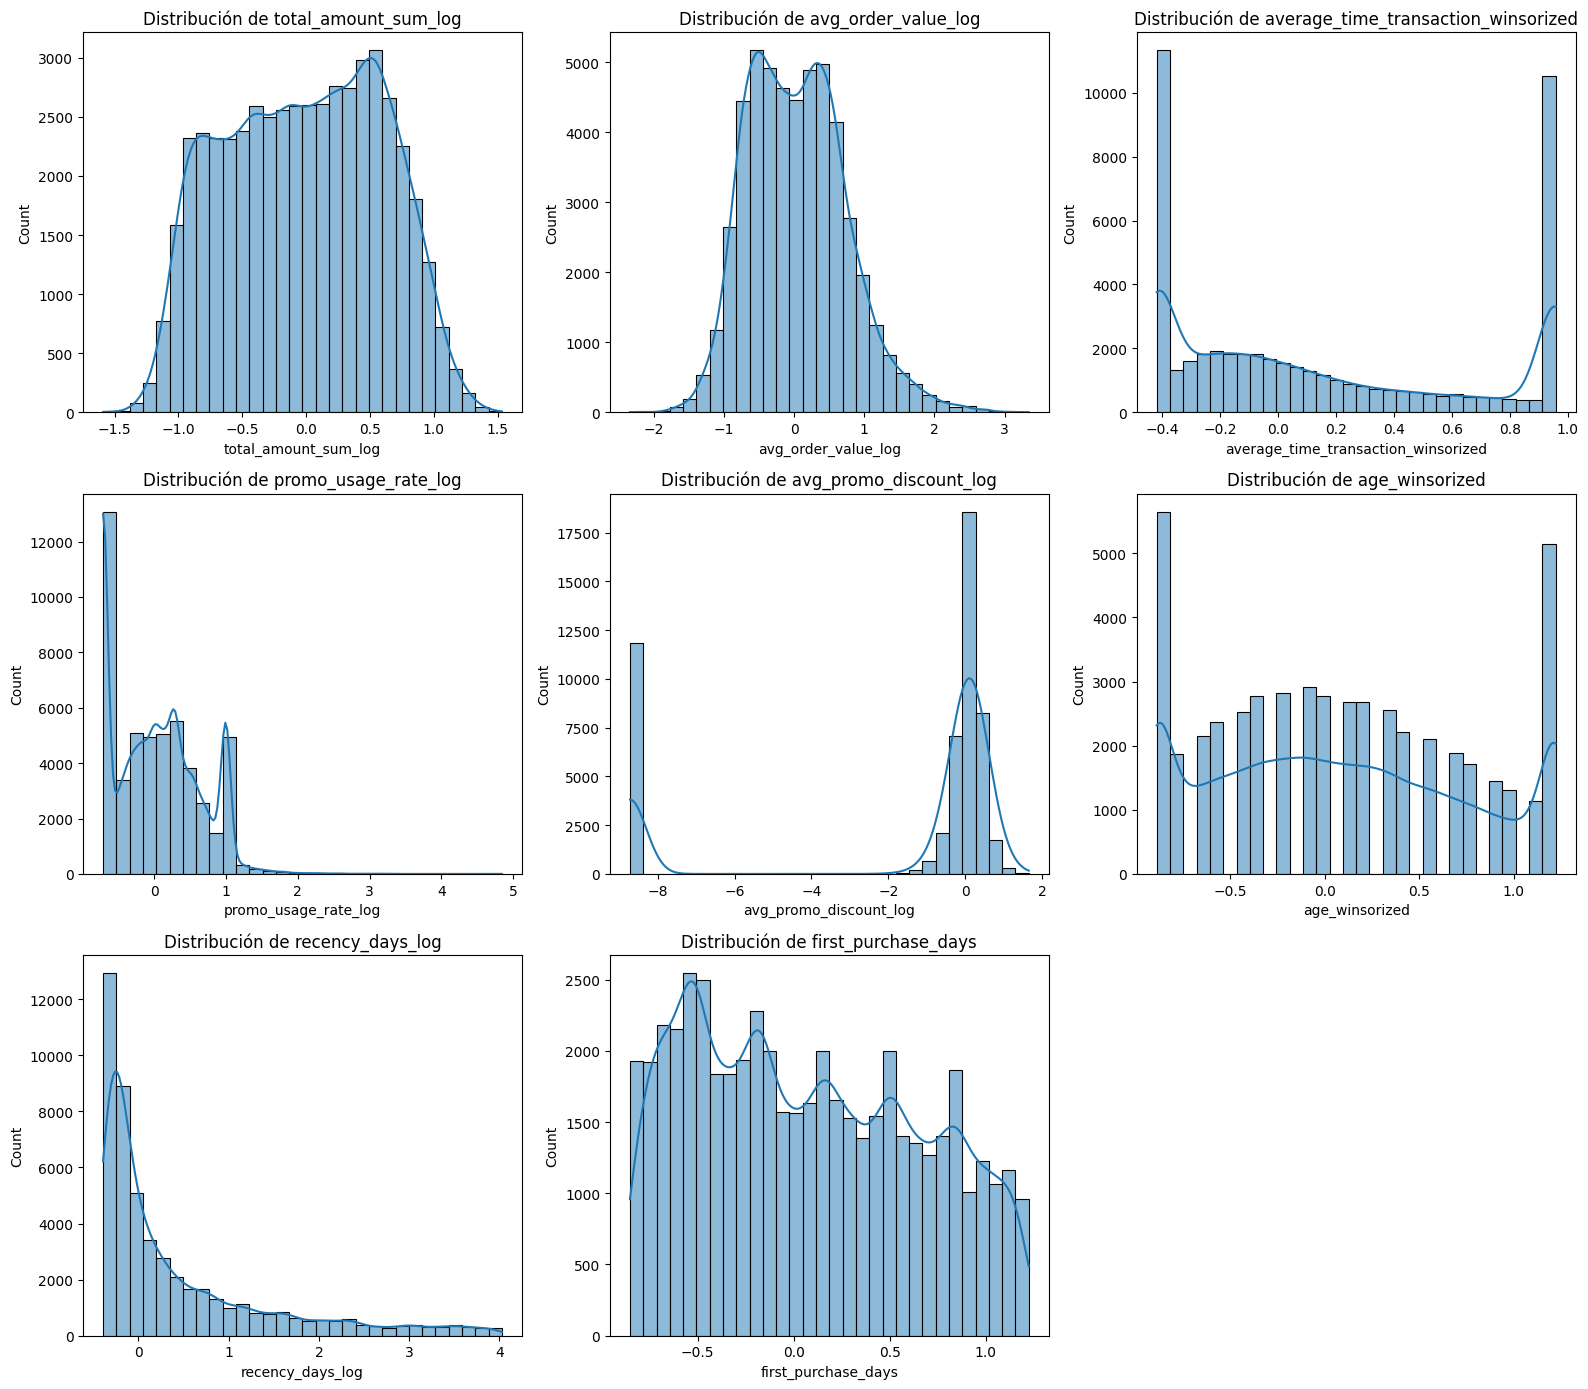

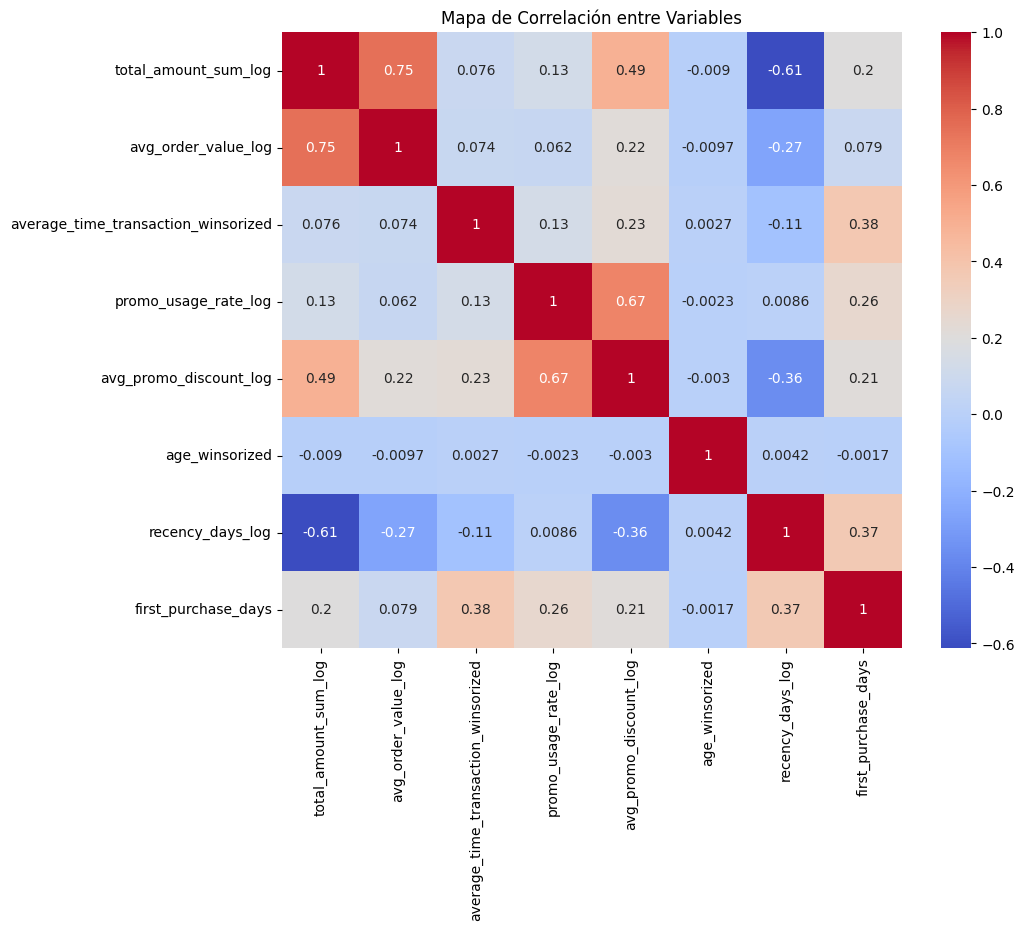

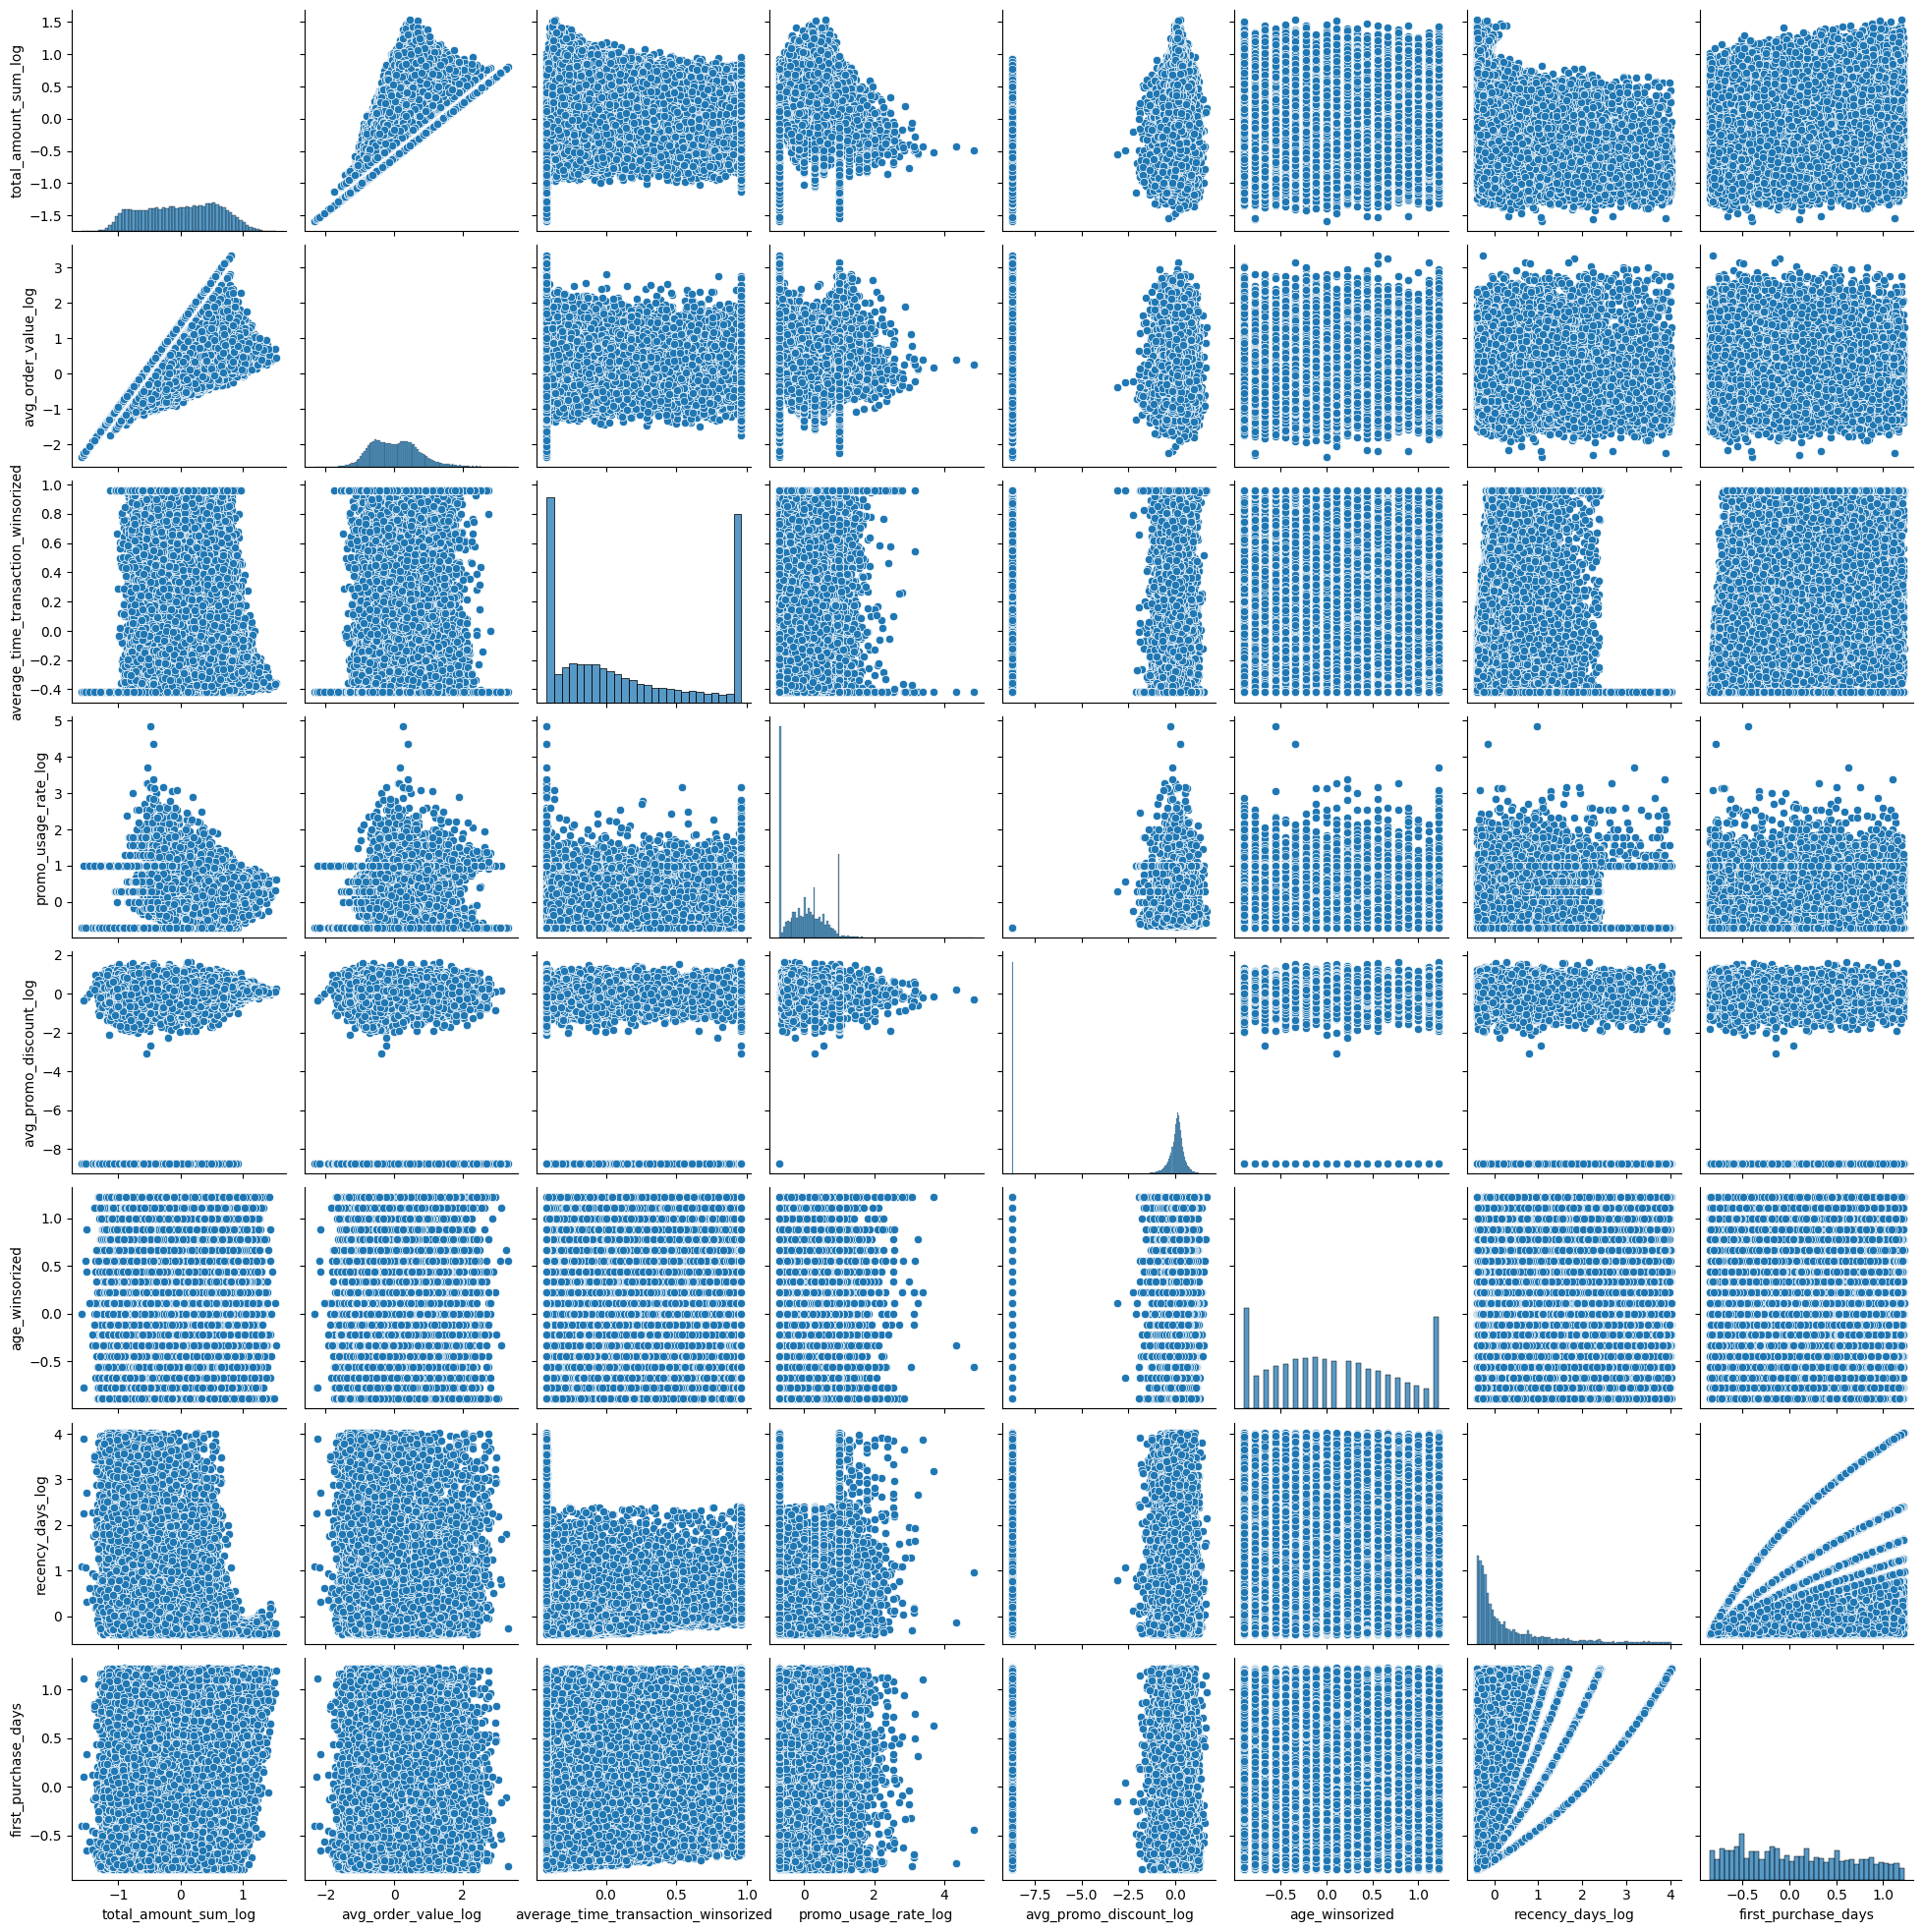


Varianza de cada variable:
total_amount_sum_log                    0.363756
avg_order_value_log                     0.486033
average_time_transaction_winsorized     0.270362
promo_usage_rate_log                    0.358630
avg_promo_discount_log                 13.941281
age_winsorized                          0.450103
recency_days_log                        1.002245
first_purchase_days                     0.336305
dtype: float64

Variables con varianza cercana a cero (potencial problema para K-Means):


In [29]:
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days
FROM customer_segmentation_normalized
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    VISUALIZACIÓN DE DISTRIBUCIONES
# ==============================
plt.figure(figsize=(16, 14))
for idx, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, idx)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

# ==============================
#    ANÁLISIS DE CORRELACIÓN
# ==============================
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de Correlación entre Variables")
plt.show()

# ==============================
#    MATRIZ DE DISPERSIÓN
# ==============================
sns.pairplot(df)
plt.show()

# ==============================
#    CÁLCULO DE VARIANZA
# ==============================
varianza = df.var()
print("\nVarianza de cada variable:")
print(varianza)

# Identificación de varianzas cercanas a cero
print("\nVariables con varianza cercana a cero (potencial problema para K-Means):")
for column, var in varianza.items():
    if var < 0.01:
        print(f"- {column}: {var}")


# Análisis de Robustez para K-Means - Conclusiones Finales  

---

## Objetivo  
El análisis realizado tuvo como propósito evaluar si las variables normalizadas están listas y optimizadas para ser utilizadas en un modelo de **K-Means**. Este proceso incluyó el estudio de:  
1. Distribución de variables.  
2. Correlación entre variables.  
3. Varianza individual de cada variable.  
4. Matriz de dispersión para identificar relaciones no lineales.  

---

## Análisis de Distribuciones  
- En general, las variables presentan una distribución aceptable después del proceso de normalización, aunque algunas mantienen sesgos:  
  - `recency_days_log` y `first_purchase_days` aún presentan asimetría.  
  - `avg_promo_discount_log` muestra una alta concentración en valores bajos y picos en los extremos.  

---

## Análisis de Correlación  
- No se encontraron correlaciones críticas (superiores a 0.85), pero destacan:  
  - `total_amount_sum_log` con `avg_order_value_log` (0.75)  
  - `total_amount_sum_log` con `avg_promo_discount_log` (0.49)  
  - `recency_days_log` con `total_amount_sum_log` (-0.61), mostrando una relación inversa significativa.  
- Estas relaciones pueden impactar en el modelo, pero no justifican eliminar variables en esta etapa.  

---

## Análisis de Varianza  
La varianza de cada variable es adecuada y permite su inclusión en el modelo de K-Means:  
| Variable                             | Varianza  |
|--------------------------------------|-----------|
| total_amount_sum_log                 | 0.363756  |
| avg_order_value_log                  | 0.486033  |
| average_time_transaction_winsorized  | 0.270362  |
| promo_usage_rate_log                 | 0.358630  |
| avg_promo_discount_log               | 13.941281 |
| age_winsorized                       | 0.450103  |
| recency_days_log                     | 1.002245  |
| first_purchase_days                  | 0.336305  |

- `avg_promo_discount_log` presenta una varianza significativamente mayor, lo cual podría influir en el modelo, pero se evaluará su impacto en la segmentación.  

---


## Transformación de Variables Categóricas

En esta sección se abordan las variables categóricas incluidas en el conjunto de datos de clientes, con el objetivo de prepararlas adecuadamente para su uso en modelos de clustering como K-Means.

### Objetivo

- Comprender la naturaleza de cada variable categórica.
- Evaluar el número y distribución de sus categorías.
- Aplicar técnicas de codificación adecuadas para convertirlas en variables numéricas sin introducir sesgos.

### Variables categóricas a transformar

| Variable                   | Descripción                                         |
|---------------------------|-----------------------------------------------------|
| `device_type_mode`        | Tipo de dispositivo más utilizado por el cliente.  |
| `traffic_source_mode`     | Fuente de tráfico más frecuente.                    |
| `most_used_payment_method`| Método de pago más usado en transacciones.          |
| `customer_gender`         | Género del cliente.                                 |
| `home_location`           | Ubicación principal del cliente (ciudad o región). |

### Criterios de codificación

- Se utilizará codificación **binaria**, **ordinal** o **por frecuencia**, según la cardinalidad y relevancia de cada variable.
- Se evitará el uso de one-hot encoding si el número de categorías es alto, para no aumentar excesivamente la dimensionalidad.

Estas variables codificadas se incorporarán a la tabla `customer_segmentation_normalized` para integrarse en el modelo de clustering.


## Codificación de la Variable `device_type_mode`

La variable `device_type_mode` representa el tipo de dispositivo más frecuentemente utilizado por cada cliente para interactuar con la plataforma.

### Objetivo

Transformar esta variable categórica en un formato numérico adecuado para el modelo de clustering, sin introducir sesgos y manteniendo la interpretabilidad.

### Análisis previo

Antes de aplicar cualquier técnica de codificación, se analizará:

- El número de categorías únicas.
- La frecuencia de cada tipo de dispositivo.
- La proporción de clientes asociada a cada una.

### Estrategia de codificación

Dependiendo del número de categorías:

- Si hay pocas categorías (≤5): se aplicará **One-Hot Encoding**.
- Si hay muchas: se considerará **Label Encoding** o **codificación por frecuencia**.

Una vez codificada, la nueva variable se incorporará como `device_type_mode_encoded` en la tabla `customer_segmentation_scaled` de PostgreSQL.


In [30]:
query = """
SELECT device_type_mode, COUNT(*) as frecuencia
FROM customer_segmentation_actives
GROUP BY device_type_mode
ORDER BY frecuencia DESC
"""
df_device = pd.read_sql_query(query, con=engine)
display(df_device)


device_type_mode  frecuencia
0          Android       38932
1              iOS       11772

## Codificación de `device_type_mode`

La variable `device_type_mode` indica el tipo de dispositivo más habitual del cliente. Tras el análisis, se identificaron dos valores posibles:

- Android (38,9%)
- iOS (11,8%)

### Codificación aplicada

Se utilizó una **codificación binaria** simple:

- Android → 0
- iOS → 1

Esta transformación es eficiente y directamente compatible con algoritmos de clustering como K-Means. La variable resultante, `device_type_mode_encoded`, ha sido incorporada a la tabla `customer_segmentation_normalized` en PostgreSQL.


In [31]:
%%time
# Leer customer_id y device_type_mode
query = """
SELECT customer_id, device_type_mode
FROM customer_segmentation_actives
"""
df = pd.read_sql_query(query, con=engine)

# Codificación binaria: Android=0, iOS=1
df["device_type_mode_encoded"] = df["device_type_mode"].map({"Android": 0, "iOS": 1})

# Leer tabla escalada existente
df_processed = pd.read_sql_query("SELECT * FROM customer_segmentation_normalized", con=engine)

# Combinar y guardar
df_final = pd.merge(df_processed, df[["customer_id", "device_type_mode_encoded"]], on="customer_id", how="left")
df_final.to_sql("customer_segmentation_normalized", con=engine, index=False, if_exists="replace")

print("✅ Columna 'device_type_mode_encoded' añadida correctamente.")


✅ Columna 'device_type_mode_encoded' añadida correctamente.
CPU times: total: 2.12 s
Wall time: 3.03 s


## Codificación de la Variable `traffic_source_mode`

La variable `traffic_source_mode` representa la fuente de tráfico predominante por la que los clientes acceden a la plataforma (por ejemplo: orgánico, directo, afiliado, etc.).

### Objetivo

Transformar esta variable categórica en formato numérico para su uso en clustering, minimizando pérdida de información y evitando sesgos.

### Análisis previo

Se analizará:

- Número de categorías únicas.
- Distribución de frecuencias.
- Posibles valores nulos o desconocidos.

### Estrategia de codificación

- Si hay pocas categorías (≤5): **One-Hot Encoding**.
- Si hay más: se aplicará **codificación ordinal por frecuencia** para conservar relaciones relativas y evitar alta dimensionalidad.

La variable transformada se añadirá como `traffic_source_mode_encoded` a la tabla `customer_segmentation_normalized`.


In [32]:
query = """
SELECT traffic_source_mode, COUNT(*) as frecuencia
FROM customer_segmentation_actives
GROUP BY traffic_source_mode
ORDER BY frecuencia DESC
"""
df_traffic = pd.read_sql_query(query, con=engine)
display(df_traffic)

traffic_source_mode  frecuencia
0              MOBILE       48558
1                 WEB        2146

# Codificación de la Variable `traffic_source_mode`  

---

## Objetivo  
La variable `traffic_source_mode` representa el canal principal por el cual los clientes acceden a la plataforma. Esta información es crucial para identificar patrones de comportamiento y segmentar adecuadamente a los usuarios.  

---

## Análisis Previo  
Se realizó un análisis de frecuencia para identificar el número de categorías y su distribución. Los resultados fueron los siguientes:  

| Categoría | Frecuencia |
|------------|------------|
| MOBILE     | 48,558    |
| WEB        | 2,146     |

- Solo se identificaron **2 categorías** principales: **MOBILE** y **WEB**.  
- El canal **MOBILE** representa la mayoría de los accesos, con un 95% del total.  

---

## Estrategia de Codificación  
Dado que el número de categorías es reducido (**2 categorías**), se decidió utilizar **Label Encoding** para optimizar el espacio y evitar dimensionalidad innecesaria.  

| Categoría | Codificación |
|------------|-------------|
| MOBILE     | 0           |
| WEB        | 1           |

- Esta estrategia es eficiente y permite al modelo de clustering identificar diferencias sin añadir columnas adicionales.  

---

## Próximos Pasos  
1. Aplicar la codificación en el DataFrame.  
2. Insertar el resultado como `traffic_source_mode_encoded` en la tabla `customer_segmentation_normalized`.  
3. Validar que los datos se registren correctamente en PostgreSQL.  

---



In [33]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT customer_id, traffic_source_mode
FROM customer_segmentation_features
"""
df = pd.read_sql_query(query, con=engine)

# ==============================
#    LABEL ENCODING DE TRAFFIC SOURCE
# ==============================
# MOBILE -> 0, WEB -> 1
df["traffic_source_mode_encoded"] = df["traffic_source_mode"].map({"MOBILE": 0, "WEB": 1})

# ==============================
#    LECTURA DE LA TABLA ESCALADA
# ==============================
df_scaled = pd.read_sql_query("SELECT * FROM customer_segmentation_normalized", con=engine)

# ==============================
#    UNIÓN DE LOS DATOS
# ==============================
df_final = pd.merge(df_scaled, df[["customer_id", "traffic_source_mode_encoded"]], on="customer_id", how="left")

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_final.to_sql("customer_segmentation_normalized", con=engine, index=False, if_exists="replace")
    print("✅ Codificación de 'traffic_source_mode' completada y añadida a la tabla.")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")


✅ Codificación de 'traffic_source_mode' completada y añadida a la tabla.
CPU times: total: 2.14 s
Wall time: 3.07 s


## Codificación de `most_used_payment_method`

La variable `most_used_payment_method` representa el método de pago más utilizado por cada cliente durante sus transacciones.

### Objetivo

Transformar esta variable categórica en formato numérico para que pueda utilizarse en algoritmos de clustering, conservando información relevante sin aumentar la dimensionalidad innecesariamente.

### Análisis previo

Se analizará:

- El número total de métodos distintos.
- La frecuencia de uso de cada uno.
- La distribución de los métodos más comunes.

### Estrategia de codificación

Dependiendo del número de categorías y su frecuencia:

- Si hay pocas categorías: **One-Hot Encoding**.
- Si hay más de 5-6 categorías: **Codificación por frecuencia** o **Label Encoding** ordenado por uso.

La variable transformada se añadirá como `most_used_payment_method_encoded` (o columnas derivadas) a la tabla `customer_segmentation_normalized`.


In [34]:
query = """
SELECT most_used_payment_method, COUNT(*) AS frecuencia
FROM customer_segmentation_actives
GROUP BY most_used_payment_method
ORDER BY frecuencia DESC
"""
df_payment = pd.read_sql_query(query, con=engine)
display(df_payment)


most_used_payment_method  frecuencia
0              Credit Card       19193
1                    Gopay       10155
2                      OVO       10147
3               Debit Card        7840
4                  LinkAja        3369

# Codificación de la Variable `most_used_payment_method`  

---

## Objetivo  
La variable `most_used_payment_method` representa el método de pago más utilizado por cada cliente en sus transacciones. Para su uso en el modelo de clustering, es necesario transformar esta variable categórica en un formato numérico adecuado.  

---

## Análisis Previo  
Se realizó un análisis de frecuencia para identificar el número de categorías y su distribución. Los resultados fueron los siguientes:  

| Método de Pago | Frecuencia |
|----------------|------------|
| Credit Card   | 19,193     |
| Gopay         | 10,155     |
| OVO           | 10,147     |
| Debit Card    | 7,840      |
| LinkAja       | 3,369      |

- Se identificaron un total de **5 métodos de pago**.  
- No existe un número excesivo de categorías, por lo cual es posible aplicar un método de codificación eficiente.  

---

## Estrategia de Codificación  
Dado el número reducido de categorías, se decidió utilizar **One-Hot Encoding**.  
- Esta técnica permite crear una columna binaria para cada método de pago, donde:  
  - `1` indica que es el método más utilizado por el cliente.  
  - `0` indica que no lo es.  

| Método de Pago | Columna Codificada             |
|----------------|--------------------------------|
| Credit Card   | most_used_payment_credit_card   |
| Gopay         | most_used_payment_gopay         |
| OVO           | most_used_payment_ovo           |
| Debit Card    | most_used_payment_debit_card    |
| LinkAja       | most_used_payment_linkaja       |

---

## Ventajas del Método  
1. **Interpretabilidad:** El modelo podrá identificar claramente qué método de pago es más habitual para cada cliente.  
2. **Compatibilidad:** One-Hot Encoding es fácilmente integrable en algoritmos de clustering como K-Means.  
3. **Bajo Impacto Dimensional:** Al haber solo 5 categorías, no se generan problemas de dimensionalidad.  

---

## Próximos Pasos  
1. Aplicar **One-Hot Encoding** a la variable.  
2. Insertar las columnas generadas en la tabla `customer_segmentation_normalized`.  
3. Validar que los datos se registren correctamente en PostgreSQL.  

--- 

In [35]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT customer_id, most_used_payment_method
FROM customer_segmentation_actives
"""
df = pd.read_sql_query(query, con=engine)

# ==============================
#    ONE-HOT ENCODING
# ==============================
df_encoded = pd.get_dummies(df, columns=['most_used_payment_method'])

# Renombrar las columnas para que sean más descriptivas
df_encoded.columns = [
    'customer_id', 
    'most_used_payment_credit_card', 
    'most_used_payment_gopay', 
    'most_used_payment_ovo', 
    'most_used_payment_debit_card', 
    'most_used_payment_linkaja'
]

# ==============================
#    LECTURA DE LA TABLA ESCALADA
# ==============================
df_scaled = pd.read_sql_query("SELECT * FROM customer_segmentation_normalized", con=engine)

# ==============================
#    UNIÓN DE LOS DATOS
# ==============================
df_final = pd.merge(df_scaled, df_encoded, on="customer_id", how="left")

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_final.to_sql("customer_segmentation_normalized", con=engine, index=False, if_exists="replace")
    print("✅ Codificación de 'most_used_payment_method' completada y añadida a la tabla.")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")


✅ Codificación de 'most_used_payment_method' completada y añadida a la tabla.
CPU times: total: 2.58 s
Wall time: 3.54 s


## Codificación de `customer_gender`

La variable `customer_gender` representa el género del cliente según la información proporcionada durante el registro o actividad.

### Objetivo

Transformar esta variable categórica en formato numérico para su uso en algoritmos de clustering como K-Means.

### Análisis previo

Se evaluará:

- Número de valores únicos.
- Distribución por género.
- Posibles valores nulos o etiquetas no binarias.

### Estrategia de codificación

Dado que se espera una variable binaria (`Male` y `Female`), se aplicará codificación binaria:

- `Male` → 0  
- `Female` → 1

La variable codificada se incluirá como `customer_gender_encoded` en la tabla `customer_segmentation_normalized`.


In [36]:
query = """
SELECT customer_gender, COUNT(*) as frecuencia
FROM customer_segmentation_actives
GROUP BY customer_gender
ORDER BY frecuencia DESC
"""
df_gender = pd.read_sql_query(query, con=engine)
display(df_gender)


customer_gender  frecuencia
0               F       32547
1               M       18157

# Codificación de la Variable `customer_gender`  

---

## Objetivo  
La variable `customer_gender` representa el género del cliente en la base de datos de segmentación. Para su uso en algoritmos de clustering como K-Means, es necesario transformarla en un formato numérico.  

---

## Análisis Previo  
Se realizó un análisis de frecuencia para identificar el número de categorías y su distribución. Los resultados fueron los siguientes:  

| Género   | Frecuencia |
|-----------|-----------|
| F (Female)| 32,547    |
| M (Male)  | 18,157    |

- Se identificaron únicamente dos categorías: **F (Female)** y **M (Male)**.  
- Existe un mayor número de registros femeninos en comparación con los masculinos, representando aproximadamente un **64%** del total.  

---

## Estrategia de Codificación  
Dado que se trata de una variable binaria, se decidió utilizar **Label Encoding** para su transformación:  

| Género | Codificación |
|---------|-------------|
| F       | 1           |
| M       | 0           |

Esta codificación es eficiente, evita dimensionalidad innecesaria y es fácilmente interpretable por el modelo de clustering.  

---

## Ventajas del Método  
1. **Optimización del Espacio:** Al ser binaria, no se incrementa la dimensionalidad del modelo.  
2. **Compatibilidad:** Es completamente compatible con algoritmos de clustering como K-Means.  
3. **Eficiencia:** Se preserva la interpretación sin introducir ruido al modelo.  

---

## Próximos Pasos  
1. Aplicar la codificación en el DataFrame.  
2. Insertar el resultado como `customer_gender_encoded` en la tabla `customer_segmentation_normalized`.  
3. Validar que los datos se registren correctamente en PostgreSQL.  


In [37]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT customer_id, customer_gender
FROM customer_segmentation_actives
"""
df = pd.read_sql_query(query, con=engine)

# ==============================
#    LABEL ENCODING
# ==============================
gender_mapping = {'F': 1, 'M': 0}
df['customer_gender_encoded'] = df['customer_gender'].map(gender_mapping)

# ==============================
#    LECTURA DE LA TABLA ESCALADA
# ==============================
df_scaled = pd.read_sql_query("SELECT * FROM customer_segmentation_normalized", con=engine)

# ==============================
#    UNIÓN DE LOS DATOS
# ==============================
df_final = pd.merge(df_scaled, df[['customer_id', 'customer_gender_encoded']], on="customer_id", how="left")

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_final.to_sql("customer_segmentation_normalized", con=engine, index=False, if_exists="replace")
    print("✅ Codificación de 'customer_gender' completada y añadida a la tabla.")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")


✅ Codificación de 'customer_gender' completada y añadida a la tabla.
CPU times: total: 2.56 s
Wall time: 3.61 s


## Codificación de `home_location`

La variable `home_location` representa la ubicación principal del cliente (ciudad, provincia o región).

### Objetivo

Transformar esta variable categórica de alta cardinalidad en una forma numérica adecuada para clustering, sin introducir una expansión de dimensionalidad excesiva.

### Análisis previo

Se evaluará:

- Número total de ubicaciones únicas.
- Distribución de frecuencias.
- Posibles valores nulos o poco frecuentes.

### Estrategia de codificación

Dado que esta variable puede contener muchas categorías únicas, se aplicará:

- **Codificación por frecuencia**: a cada cliente se le asigna un valor correspondiente a la proporción de clientes con esa misma ubicación.
- Esta estrategia es eficiente, preserva cierta información de representatividad y evita la creación de múltiples columnas.

El resultado se almacenará en `home_location_freq_encoded` dentro de la tabla `customer_segmentation_scaled`.


In [38]:
query = """
SELECT home_location, COUNT(*) as frecuencia
FROM customer_segmentation_actives
GROUP BY home_location
ORDER BY frecuencia DESC
"""
df_location = pd.read_sql_query(query, con=engine)
display(df_location)
print(f"Total ubicaciones únicas: {df_location.shape[0]}")


home_location  frecuencia
0          Jakarta Raya        9389
1            Jawa Barat        5781
2           Jawa Tengah        5599
3            Jawa Timur        4925
4            Yogyakarta        4018
5      Kalimantan Barat        2833
6               Lampung        2783
7     Kalimantan Tengah        2187
8    Kalimantan Selatan        2121
9      Kalimantan Timur        1394
10               Maluku        1288
11       Kepulauan Riau         979
12                 Bali         751
13       Sumatera Barat         690
14  Nusa Tenggara Barat         675
15       Sulawesi Utara         635
16       Sumatera Utara         541
17       Sulawesi Barat         537
18     Sumatera Selatan         410
19                Papua         406
20     Sulawesi Selatan         348
21          Papua Barat         342
22             Bengkulu         341
23  Nusa Tenggara Timur         274
24      Sulawesi Tengah         244
25                Jambi         198
26         Maluku Utara         193
27            Gorontalo         183
28               Banten         180
29                 Aceh         141
30      Bangka Belitung         132
31    Sulawesi Tenggara         107
32                 Riau          79

Total ubicaciones únicas: 33


# Codificación de la Variable `home_location`  

---

## Objetivo  
La variable `home_location` representa la ubicación principal del cliente, como ciudad, provincia o región. Dada su alta cardinalidad (33 ubicaciones diferentes), es necesario transformarla a un formato numérico que conserve la información y sea eficiente para modelos de clustering.  

---

## Análisis Previo  
Se realizó un análisis de frecuencia para identificar el número de ubicaciones únicas y su distribución. Los resultados mostraron:  

| Ubicación            | Frecuencia |
|-----------------------|------------|
| Jakarta Raya         | 9,389      |
| Jawa Barat           | 5,781      |
| Jawa Tengah          | 5,599      |
| Jawa Timur           | 4,925      |
| Yogyakarta           | 4,018      |
| ...                  | ...        |

- El total de ubicaciones únicas es de **33**.  
- Las 5 principales concentraron una mayor proporción de clientes.  

---

## Estrategia de Codificación  
Dado que existen múltiples categorías, un **One-Hot Encoding** incrementaría significativamente la dimensionalidad del modelo.  
Por este motivo, se decidió aplicar una **Codificación por Frecuencia**, que consiste en asignar un valor numérico proporcional a la cantidad de clientes que residen en cada ubicación.  

### Ejemplo de Codificación  
| Ubicación            | Frecuencia Relativa | Codificación |
|-----------------------|---------------------|--------------|
| Jakarta Raya         | 0.1849              | 0.1849       |
| Jawa Barat           | 0.1138              | 0.1138       |
| Jawa Tengah          | 0.1101              | 0.1101       |
| Jawa Timur           | 0.0967              | 0.0967       |
| Yogyakarta           | 0.0789              | 0.0789       |

- Esta técnica reduce dimensionalidad y mantiene la representatividad de las ubicaciones.  
- Las ubicaciones más frecuentes tienen un valor más alto, lo cual es interpretado por el modelo como un mayor peso.  

---

## Ventajas del Método  
1. **Optimización del Espacio:** No se crean múltiples columnas, se añade solo una.  
2. **Representación Relativa:** Las ubicaciones con más usuarios tienen un valor más alto.  
3. **Compatibilidad:** Es fácilmente integrable en K-Means y otros modelos de clustering.  

---

## Próximos Pasos  
1. Aplicar la codificación por frecuencia en el DataFrame.  
2. Insertar el resultado como `home_location_freq_encoded` en la tabla `customer_segmentation_normalized`.  
3. Validar que los datos se registren correctamente en PostgreSQL.  

--- 


In [39]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT customer_id, home_location
FROM customer_segmentation_actives
"""
df = pd.read_sql_query(query, con=engine)

# ==============================
#    CODIFICACIÓN POR FRECUENCIA
# ==============================
print("\nAplicando Codificación por Frecuencia...")
freq_encoding = df['home_location'].value_counts(normalize=True).to_dict()
df['home_location_freq_encoded'] = df['home_location'].map(freq_encoding)

# ==============================
#    LECTURA DE LA TABLA ESCALADA
# ==============================
df_scaled = pd.read_sql_query("SELECT * FROM customer_segmentation_normalized", con=engine)

# ==============================
#    UNIÓN DE LOS DATOS
# ==============================
df_final = pd.merge(df_scaled, df[['customer_id', 'home_location_freq_encoded']], on="customer_id", how="left")

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_final.to_sql("customer_segmentation_normalized", con=engine, index=False, if_exists="replace")
    print("✅ Codificación de 'home_location' completada y añadida a la tabla.")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")



Aplicando Codificación por Frecuencia...
✅ Codificación de 'home_location' completada y añadida a la tabla.
CPU times: total: 2.77 s
Wall time: 3.9 s


## Resumen Final: Variables para Segmentación de Clientes

La tabla `customer_segmentation_scaled` contiene todas las variables numéricas y categóricas necesarias para aplicar algoritmos de clustering sobre los clientes. Estas variables han sido previamente limpiadas, transformadas, codificadas y escaladas directamente en la base de datos.

---

### Variables Numéricas (transformadas con Winsorización + StandardScaler)

Estas variables cuantifican el comportamiento y valor del cliente:

- `total_amount_sum`
- `avg_order_value`
- `recency_days`
- `first_purchase_days`
- `average_time_transaction`
- `promo_usage_rate`
- `avg_promo_discount`
- `age`
---

### Variables Categóricas (codificadas)

Estas variables describen características del perfil del cliente, codificadas para su uso en modelos:

- `device_type_mode_encoded` → 1 si usa iOS, 0 si Android
- `traffic_source_mobile` → 1 si fuente principal es móvil
- `traffic_source_web` → 1 si fuente principal es web 
- `payment_credit_card`
- `payment_gopay`
- `payment_ovo`
- `payment_debit_card`
- `payment_linkaja` → variables binarias según método de pago más frecuente
- `customer_gender_encoded` → 1 si mujer, 0 si hombre
- `home_location_freq_encoded` → codificación por frecuencia del lugar de residencia

---

### Total de variables para clustering:

- **8 variables numéricas escaladas**
- **10 variables categóricas codificadas**
- **+ `customer_id` como identificador**

---

Todas las variables están preparadas para aplicar métodos de segmentación como **K-Means**, garantizando una correcta representación y comparabilidad entre ellas.


## Imputación de Valores Nulos

Durante la creación de la tabla `customer_segmentation_scaled`, algunas variables numéricas resultaron con valores nulos en clientes sin actividad (por ejemplo, sin compras o sin sesiones).

### Objetivo

Imputar estos valores nulos con `0` para:

- Mantener a todos los clientes en el análisis.
- Asignar un perfil neutro o basal a aquellos sin actividad registrada.
- Evitar errores durante el entrenamiento de modelos de clustering como K-Means.

### Variables afectadas

Se imputaron con 0 las siguientes variables numéricas:

- `total_amount_sum`
- `avg_order_value`
- `recency_days`
- `first_purchase_days`
- `average_time_transaction`
- `promo_usage_rate`
- `avg_promo_discount`
- `age`

### Método aplicado

La imputación se realizó directamente en la base de datos PostgreSQL mediante sentencias `UPDATE`, sin cargar los datos en memoria, para optimizar rendimiento y escalabilidad.

Cada columna se actualizó con:

```sql
UPDATE customer_segmentation_scaled
SET <columna> = 0
WHERE <columna> IS NULL;


In [40]:
%%time
# Consulta para obtener los datos originales (todos los clientes)
query = """
SELECT * FROM customer_segmentation_normalized
"""
df_scaled = pd.read_sql_query(query, engine)

# Identificación de columnas numéricas
numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns

# Imputación de valores nulos con 0
df_scaled[numeric_cols] = df_scaled[numeric_cols].fillna(0)

# Guardar el resultado en PostgreSQL
df_scaled.to_sql(
    'customer_segmentation_normalized',
    engine,
    index=False,
    if_exists='replace'
)

print("✅ Tabla 'customer_segmentation_normalized' actualizada con valores nulos reemplazados por 0.")

✅ Tabla 'customer_segmentation_normalized' actualizada con valores nulos reemplazados por 0.
CPU times: total: 2.62 s
Wall time: 3.81 s


# Conclusiones del Notebook 06.02.Clustering_pre_processing

## Resumen del Análisis
En este notebook, hemos llevado a cabo un análisis exhaustivo de las variables utilizadas para el clustering, asegurando su calidad y relevancia para la segmentación de clientes. Los pasos realizados incluyen:

1. **Análisis descriptivo** para identificar distribuciones, outliers y patrones.
2. **Normalización y ajustes** que permitieron estandarizar las variables y mejorar su representatividad.
3. **Estudio de correlaciones** para eliminar redundancias y seleccionar aquellas que aportan mayor valor al modelo.
4. **Optimización del conjunto de variables** que serán empleadas en el siguiente paso de segmentación.